<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/procgen_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq procgen faiss-cpu vector-quantize-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 327.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
# @title faiss
import faiss
import numpy as np

# d = 256 # dimension
# res = faiss.StandardGpuResources()  # use a single GPU
# nlist = 100
# m = 8
# index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
# index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
# # index = faiss.IndexIVFPQ(index, d, nlist, m, 8) # each sub-vector is encoded as 8 bits # 3-IVFPQ.py
# # index = faiss.index_cpu_to_gpu(res, 0, index) # 4-GPU.py
# # index = faiss.index_cpu_to_all_gpus(index) # 5-Multiple-GPUs.py


# import torch
# ltmk = torch.rand(1000,d)
# ltmv = torch.rand(1000,d)

def makefaissindex(vert_store):
    d = vert_store.shape[-1]
    nlist = 100
    index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
    if not index.is_trained: index.train(vert_store)
    index.add(vert_store)
    return index
# index = makefaissindex(ltmk)


def vecsearch(query, index, k=5, treshold=36): # k nearest neighbors
    # index.nprobe = 5 # 1
    D, I = index.search(query, k) # dist, idx
    D, I = D[0], I[0]
    mask = I[D<treshold]
    return mask

# import torch
# query = torch.rand(1,d)

# mask = vecsearch(query, index, k=5, treshold=37)
# print(mask)
# rag = ltmk[mask]
# print(rag)


# removing = torch.tensor([998, 769, 643])
# index.remove_ids(removing)



In [ ]:
# @title mem
import faiss
import pickle
import torch

class Stm():
    def __init__(self): # [batch_size, len_ltm, d_model]
        self.stmk, self.stmv = torch.tensor([], device=device), torch.tensor([], device=device)

    def __call__(self, query): # [batch_size, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, 1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, 1, len_ltm]
        x = attention @ self.stmv
        return x.squeeze(1) # [batch_size, d_model]

    def add(self, k, v): # [batch_size, 1, d_model]
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)


class Mem():
    def __init__(self, batch_size=1):
        self.index = None
        self.ltmk, self.ltmv = torch.tensor([]), torch.tensor([])
        # self.stmk, self.stmv, self.meta = torch.tensor([]), torch.tensor([]), torch.tensor([])
        # self.ltmk, self.ltmv = torch.tensor([], device=device), torch.tensor([], device=device)
        self.stmk, self.stmv, self.meta = torch.tensor([], device=device), torch.tensor([], device=device), torch.tensor([], device=device)
        self.batch_size = batch_size

    def __call__(self, query, a=0.5):
        return a*self.Stm(query) + (1-a)*self.Ltm(query.cpu()).to(device)

    def Stm(self, query): # [1, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query @ self.stmk.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ self.stmv # [1, len_ltm] @ [len_ltm, d_model] = [1, d_model]
        self.meta = self.meta + attn.squeeze(0) # attention # [len_ltm]
        return x # [1, d_model]

    def Ltm(self, query, k=5, treshold=36): # [batch_size, d_model] or [d_model]
        if self.index: rag = self.vecsearch(query, k, treshold)
        else: rag = self.ltmk
        if len(rag)==0: return torch.zeros(1)
        # print("ltm call", query.shape, rag.shape)
        attn = query @ rag.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ rag
        return x # [1, d_model]

    def add(self, k, v): # [batch_size, d_model] or [d_model]
        # print("add", k.shape,self.stmk.shape)
        self.stmk = torch.cat([self.stmk, k], dim=0)
        self.stmv = torch.cat([self.stmv, v], dim=0)
        self.meta = torch.cat([self.meta, torch.ones((1), device=device)], dim=-1)
        if torch.rand(1)<0.1:
            self.pop()
            self.decay()

    def decay(self, g=0.9, k=256): # remove unimportant mem in stm
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        if len(self.meta)>k:
            topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
            self.meta = topk.values # cap stm size
            self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5): # transfer from stm to ltm
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        k, v = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask] # remove from stm
        self.meta = self.meta[~mask]
        # print("pop", k.shape, self.ltmk.shape, k)
        k, v = k.cpu(), v.cpu()
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        self.ltmk = torch.cat([self.ltmk, k], dim=0) # add to ltm
        self.ltmv = torch.cat([self.ltmv, v], dim=0)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.01:
                self.index.train(self.ltmk)
        else:
            if len(self.ltmk)>=100:
                self.index = makefaissindex(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        rag = self.ltmk[mask] # [len_rag, d_model]
        return rag

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(self, file='mem.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta), f)

    def load(self, file='mem.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta = pickle.load(f)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# print(get_res(256).to(device))
# model = get_res(256).to(device)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [2]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)

class Deconv(torch.nn.Module):
    def __init__(self, d_model = 1024):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.decoder = nn.Sequential(
            nn.Linear(d_model,4*d_list[4]), nn.ReLU(),
            # nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.decoder(x)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # input = torch.rand((4,1,256,256), device=device)
# out = conv(input)
# print(out.shape)

# conv = Deconv(256).to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,256), device=device)
# out = conv(input)
# print(out.shape)


In [1]:
# @title vector quantize
# https://github.com/lucidrains/vector-quantize-pytorch?tab=readme-ov-file#finite-scalar-quantization
import torch
from vector_quantize_pytorch import FSQ
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantizer = FSQ(levels = [3,3,2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py

# # x = torch.randn(1, 1024, 3) # last dim is num levels
# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]
# # print(xhat[0])
# # print(indices[0])

# # assert torch.all(xhat == quantizer.indices_to_codes(indices))


In [ ]:
# @title intrinsic cost
import faiss
import torch

class ICost():
    def __init__(self, d_model, n=100):
        self.recent=[]
        # self.linmul = torch.linspace(0,1/n,n).unsqueeze(-1) # 1/n so that sum to 1
        self.linsx = torch.zeros((n, d_model), device=device)
        self.n = n
        self.p=(n-1)/n

    def boredom(self, lsx, linsx=None): # lsx: [len_seq, d_model]; for simulate only
        if linsx==None: linsx = self.linsx.clone()
        lsx, linsx = F.normalize(lsx, dim=-1), F.normalize(linsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        linsx = linsx[mask]
        bore = (linsx[:-1]@lsx[-1].T).sum()/(self.n-1)
        return bore#.squeeze()

    def update(self, lsx): # lsx: []
        # self.linsx = torch.cat([lsx, self.linsx[:-lsx.shape[0]]], dim=0)
        lsx = F.normalize(lsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([self.linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        self.linsx = linsx[mask]


    # def curiousity(self, sx):
    #     lin= nn.Linear(d_model, 100)#, bias=False)
    #     with torch.no_grad():
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)

    #         n,d=10,2
    #         data=torch.rand(n,d)

    #         index = faiss.IndexFlatIP(d) # IndexFlatL2, IndexFlatIP
    #         index = faiss.IndexIDMap(index)
    #         ids=torch.arange(n)
    #         index.add_with_ids(data,ids)
    #         a=torch.rand(1,2)
    #         id=torch.tensor([0])
    #         index.remove_ids(id) # https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#supported-operations
    #         index.add_with_ids(a,id)

    #         D, I = index.search(a, 20)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         curious = 1-torch.clamp(priority, 0, 1)
    #         D.sum(-1)
    #         curious = 1-torch.clamp(, max=1) # IP


    # def __call__(self, st, a): # [batch_size, d_model]
    def __call__(self, x): # [batch_size, d_model**2]
        return 0

# pain, death, boredom, empathy


In [ ]:
# @title procgen
# https://github.com/openai/procgen
import gym
# env = gym.make("procgen:procgen-coinrun-v0")
# env = gym.make("procgen:procgen-coinrun-v0", start_level=0, num_levels=1)

# from procgen import ProcgenGym3Env
# env = ProcgenGym3Env(num=1, env_name="coinrun")

env_name="procgen:procgen-{}-v0".format("bigfish") # https://github.com/openai/procgen/blob/master/procgen/gym_registration.py#L29
# env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array")
env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array", use_backgrounds=False, restrict_themes=True, use_monochrome_assets=True)


ENV_NAMES = ["bigfish", "bossfight", "caveflyer", "chaser", "climber", "coinrun", "dodgeball", "fruitbot", "heist", "jumper", "leaper", "maze", "miner", "ninja", "plunder", "starpilot",]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
        super(JEPA, self).__init__()
        # self.enc = nn.Sequential(nn.Linear(in_dim, d_model), nn.ReLU(),)
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc = Conv(d_model)

        self.pred = nn.Sequential(
            nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model),
            )
        # self.pred = gru(emb_dim, rnn_units, num_layers)
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        self.dim_z = dim_z
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν
        self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        # return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        return std_loss, cov_loss

    def argm(self, sx, a, sy, lr=1e5): # 3e3
        batch=sx.size(dim=0)
        z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
        optim = torch.optim.SGD([z], lr=lr)
        lossfn = torch.nn.MSELoss()
        sx, a, sy = sx.detach(), a.detach(), sy.detach()
        num_steps = 5 # 10
        for i in range(num_steps):
            sxaz = torch.cat([sx, a, z], dim=-1)
            sy_ = self.pred(sxaz)
            # print("y_, y",y_.shape, y.shape)
            loss = lossfn(sy_, sy)
            loss.backward()
            optim.step()
            optim.zero_grad()
            # print("argm in",loss.item())
        # print(z.squeeze())
        if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        return z#.detach()

    def loss(self, x, y, a, z=None):
        sx, sy = self.enc(x), self.enc(y)
        z = self.argm(sx, a, sy)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        repr_loss = self.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
        # v_c_loss = self.v_creg(self.exp(sx))
        vx, vy = self.exp(sx), self.exp(sy)
        v_c_loss = self.v_creg(vx) + self.v_creg(vy)
        return repr_loss + v_c_loss

    def forward(self, sx, a): # state, ctrl
        batch=sx.size(dim=0)
        z=torch.zeros((batch,self.dim_z),device=device)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        return sy_ # state1


# d_model=16
# dim_z= 1#-5
# dim_v=32
# dim_a=4
# model = JEPA(in_dim, d_model, dim_a, dim_z, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# y=torch.rand(1, in_dimy)
# loss = model.loss(x,y)
# distance = torch.norm(embeddings.weight.data - my_sample, dim=-1)
# nearest = torch.argmin(distance)


In [ ]:
# @title agent
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = get_res(d_model)
        self.sense.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.critic = GRU(
        # self.critic = nn.Sequential(
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            # nn.Linear(d_model, d_model),
            # )
        # self.actor = nn.Sequential( # -> goal sx/ssx/sssx/...
        #     nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.quantizer = FSQ(levels = [3,3,2])
        self.conv = Conv()

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            sx = self.jepa.enc(self.world_state.flatten()).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        # a, act = la[0][0], lact[0][0]
        # return act
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        # print("get", state.shape)
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        # current = self.sense(state.unsqueeze(-1)) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            _mem = Stm()
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sx_ = self.jepa.enc(world_state.flatten(start_dim=1))
            sx_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    _mem, world_state_ = self.get(state, _mem, world_state)
                    # sy = self.jepa.enc(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(sxaz)
                    sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss
                    # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.conv(world_state_.detach())
                    conv_loss = F.mse_loss(state_, state)
                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#                     closs=F.l1_loss(c_, c) # mse_loss, l1_loss


agent = Agent().to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
optim = torch.optim.AdamW([{'params': others, 'lr': 1e-3},
    {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [41]:
# @title agent pixel
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


# sim_coeff, std_coeff, cov_coeff = 0.1,0.487,0.01 # 0.08, 0.48, 0.004 # 0.005 0.42 0.024
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, 1),
            )
        self.quantizer = FSQ(levels = [3,3,2])
        self.deconv = Deconv(d_model)
        self.jepa.sim_coeff=100.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=20.0 # 1.0 # ν cov Covariance

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            sx = self.jepa.enc(state).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss

                    decay=0.999
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()

                    step=0.01
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.deconv(sy.detach())
                    # state_ = self.deconv(sy)
                    tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # conv_loss = F.mse_loss(state_, state)
                    conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)



    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]

                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # jloss = std_loss + cov_loss

                    # state_ = self.deconv(sy.detach()) # pure jepa
                    state_ = self.deconv(sy) # ae
                    # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))

                    conv_loss = F.mse_loss(state_, state)
                    # conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss
                    loss = conv_loss

                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass


    def train_jepa(self, dataloader, c_loader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            # c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy_))

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss

                    decay=0.99
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.


                    # # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c_ = torch.cat([c_, self.tcost(sy).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    # # ae loss
                    state_ = self.deconv(sy)
                    # state_ = self.deconv(sy.detach())
                    conv_loss = F.mse_loss(state_, state)
                    # # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # # conv_loss = F.mse_loss(state_, tsmall(state))
                    # # loss = jloss + conv_loss

                    loss = loss + jloss + conv_loss

                if i+1 in lst:

                    try:
                        st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    st, r = st.to(device), r.to(device)#.squeeze(-1)
                    # st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
                    with torch.cuda.amp.autocast():
                        closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)

                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    # c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                # else:
                #     scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item(), "closs": closs.item()})
                except: pass


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#



# agent = Agent().to(device)
agent = Agent(d_model=256).to(device)
# agent = Agent(d_model=1024,dim_v=4096).to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [30]:
!gdown 1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc -O agentoptim.pkl # A2


Downloading...
From (original): https://drive.google.com/uc?id=1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc
From (redirected): https://drive.google.com/uc?id=1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc&confirm=t&uuid=26aa7b2e-933d-41e8-985d-9a6f2933396d
To: /content/agentoptim.pkl
100% 44.2M/44.2M [00:01<00:00, 28.2MB/s]


In [42]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

def save(folder, name='agent.pth'):
    torch.save(agent.state_dict(), folder+name)
    # agent.mem.save(file=folder+name)
    # with open(folder+'buffer.pkl', 'wb') as f: pickle.dump((buffer), f)

def load(folder, name='agent.pth'):
    # agent.load_state_dict(torch.load(folder+name, map_location=torch.device(device)), strict=False)
    # agent.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
    # torch.load(folder+name, map_location=torch.device('cpu'))
    # agent.mem.load(file=folder+name)
    with open(folder+'buffer512.pkl', 'rb') as f: return pickle.load(f)

# save(folder)
# save(folder, name='agent_jepa753333256.pth')
# buffer = load(folder)
# save('/content/')
# buffer = load('/content/')

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer512down.pkl', 'wb') as f: pickle.dump((buffer), f)
with open(folder+'buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)


# checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
# torch.save(checkpoint, folder+'agentoptim.pkl')

# modelsd, optimsd = torch.load(folder+'agentoptim.pkl').values()
modelsd, optimsd = torch.load('agentoptim.pkl').values()
agent.load_state_dict(modelsd)
optim.load_state_dict(optimsd)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
torch.save(checkpoint, folder+'agentoptim.pkl')

In [32]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        # self.data = self.data_process(buffer)
        # self.data = buffer
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # def data_process(self, data): # str 10780437
    #     return torch.tensor([self.stoi.get(c) for c in data]) # list of int 4570571 # stoi.get(c,UNK_IDX)

    def __len__(self):
        return len(self.data)//self.seq_len
        # return len(self.data)

    def __getitem__(self, idx):
        sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state]
        return state, action, reward
        # state, action, reward = self.data[idx]
        # # print("__getitem__",state)
        # state = self.transform(state)
        # # print("__getitem__",type(state))
        # return state

    def add(self, episode):
        self.data.append(episode)

    # def pop(self, data, p=1, k=5, n=3): # p: num eps to pop; k: knn clustered; n: ave frames
    #     lin= nn.Linear(3*64*64, 100)#, bias=False)
    #     with torch.no_grad():
    #         imgs = [[sample[0] for sample in random.sample(episode,n)] for episode in buffer] # [num_episodes, num_samples, 64, 64, 3]
    #         data=torch.from_numpy(np.stack(imgs)).float().mean(1) # sum mean
    #         # imshow(torchvision.utils.make_grid(data.int().permute(0,3,1,2),nrow=4))
    #         data=data.flatten(start_dim=-3)
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)
    #         idx = torch.randperm(len(data))[:100] # sample some episodes
    #         sample = data[idx]
    #         index = faiss.IndexFlatL2(data.shape[-1]) # 6.53 ms ± 1.23 ms
    #         # index = faiss.IndexFlatIP(data.shape[-1]) #
    #         index.add(data)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         # priority = -D.sum(-1) # IP
    #         topk = torch.topk(priority, p)#, dim=None, largest=True, sorted=True
    #         index_list = idx[topk.values] # most clustered
    #         for i in reversed(index_list): data.pop(i)
    #     return data

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [44]:
# @title data weighted
import torch
import torch.nn as nn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

data = [step for episode in buffer for step in episode]
state, action, reward = zip(*data)
# print("reward",type(reward))
data_targets=(torch.tensor(reward)==0).int()
train_data=list(zip(state,reward))


from torch.utils.data import Dataset
import torchvision.transforms as transforms
class Datasetme(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float)
        # return x, y+1
train_data = Datasetme(train_data)


from collections import Counter
class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
class_count = sorted(Counter(data_targets.tolist()).items())
class_count=torch.tensor([x[1] for x in class_count])
weight=1./class_count
weights = weight[data_targets]

# batch_size = 64 #

train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
c_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)



import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 300
def imshow(img): # display img from torch tensor
    img = img / 2 + 0.5  # unnormalize
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# trainiter = iter(c_loader)
# images, labels = next(trainiter)
# imshow(torchvision.utils.make_grid(images,nrow=10))
# # print(labels)
# for x in range((len(labels)//10)+1):
#     print(labels[10*x:10*x+10])

# try:
#     with torch.no_grad():
#         pred = tcost(agent.jepa.enc(images.to(device))).argmax(-1).cpu()
#         print((labels==pred).sum())
# except: pass


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    model.fc = nn.Sequential( # og
        nn.Linear(num_ftrs, dim_embd, bias=None),
        )
    return model

model = get_res(2).to(device)


loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    model.train()
    for image, r in train_loader:
        image, r = image.to(device), r.to(device)
        with torch.cuda.amp.autocast(): loss = loss_function(model(image), r)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(loss.item())
        # try: wandb.log({"loss": loss.item()})
        # except: pass

for epoch in range(10):
    train(model, train_loader, loss_function, optimizer)



0


<ipython-input-41-91612ad5b61b>:274: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)


repr, std, cov, conv, closs 0.6651245355606079 0.4765625 3.5610049962997437e-05 0.004839375615119934 0.25144633650779724
5.261480386335898 0.051935575515985544 1.0
repr, std, cov, conv, closs 0.6731535196304321 0.47607421875 3.9961887523531914e-05 0.004642087034881115 0.24898548424243927
5.32496656881171 0.05235251722825846 1.0
repr, std, cov, conv, closs 0.6662647724151611 0.4755859375 4.46392223238945e-05 0.0051997629925608635 0.2459510862827301
5.32496656881171 0.05070456825015017 1.0
repr, std, cov, conv, closs 0.6666312217712402 0.473876953125 5.9055862948298454e-05 0.005218264646828175 0.24668315052986145
5.32496656881171 0.04980049900174723 1.0
repr, std, cov, conv, closs 0.6423236131668091 0.471435546875 9.646778926253319e-05 0.0048170071095228195 0.2681235373020172
5.32496656881171 0.04823288227987328 1.0
repr, std, cov, conv, closs 0.6544208526611328 0.4697265625 0.00012708362191915512 0.004439476411789656 0.2532764673233032
5.31433258930052 0.047372883523628215 1.0
repr, std

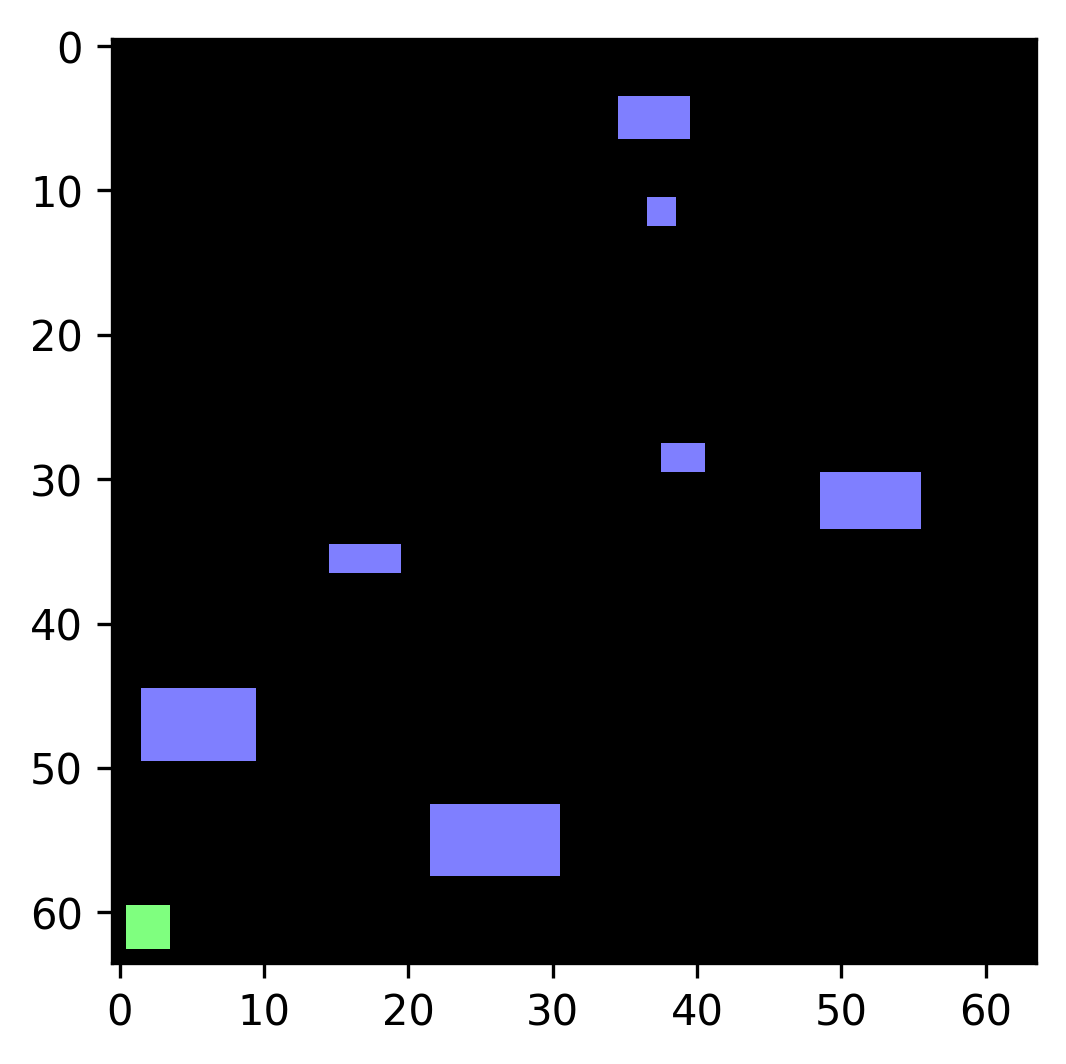

(3, 64, 64)


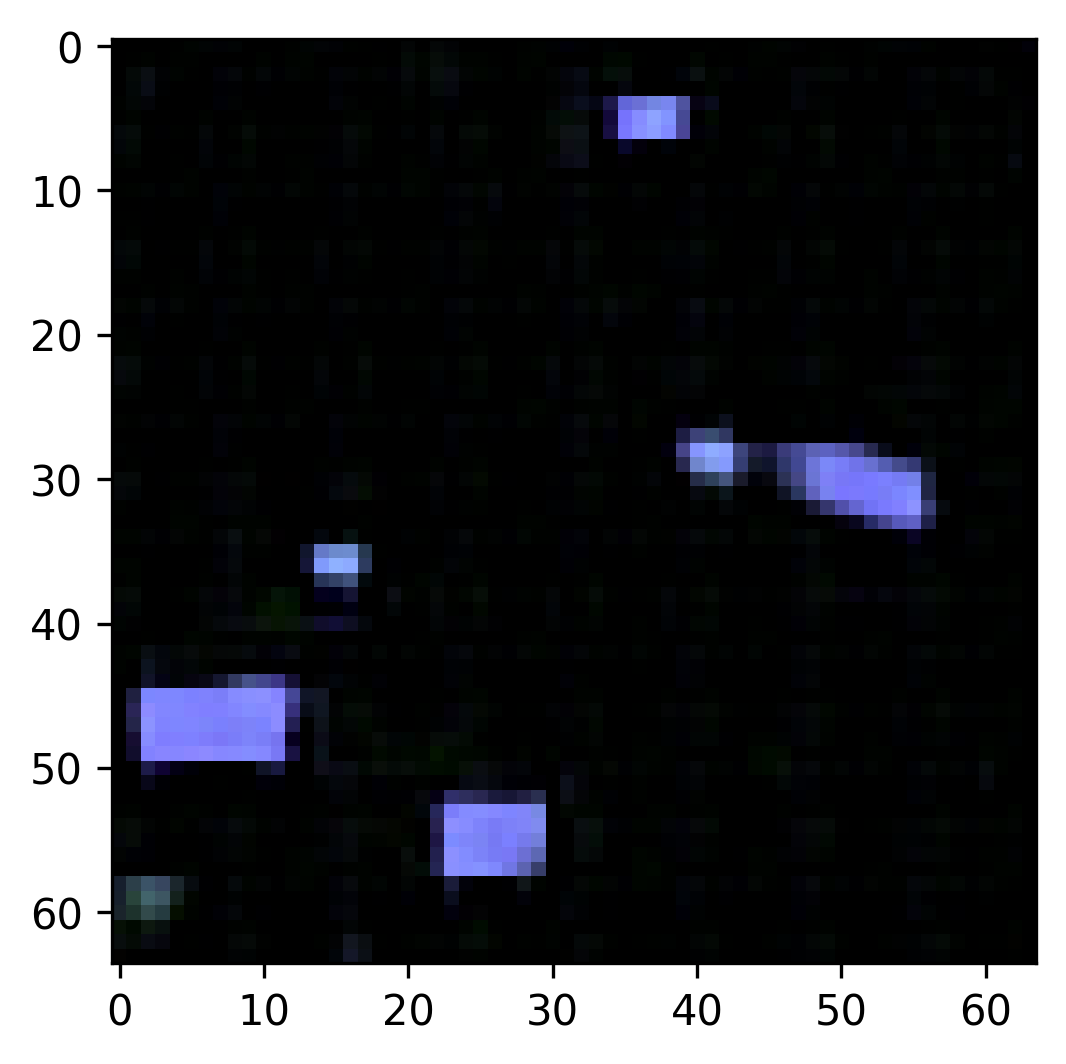

1
repr, std, cov, conv, closs 0.6422272324562073 0.4599609375 0.0003567419480532408 0.003972574602812529 0.25137490034103394
5.492540746082857 0.032305624877153834 1.0
repr, std, cov, conv, closs 0.647179126739502 0.460693359375 0.00032334099523723125 0.004230611026287079 0.2498825639486313
5.492540746082857 0.032305624877153834 1.0
repr, std, cov, conv, closs 0.6593883037567139 0.462158203125 0.00028203893452882767 0.004997876472771168 0.24975119531154633
5.637146244305463 0.032305624877153834 1.0
repr, std, cov, conv, closs 0.652867317199707 0.4619140625 0.00029849749989807606 0.004051453433930874 0.24992366135120392
5.648426173940317 0.032305624877153834 1.0
repr, std, cov, conv, closs 0.6587589979171753 0.462158203125 0.0002775804605334997 0.005219662562012672 0.24973878264427185
5.745221459265023 0.032305624877153834 1.0
repr, std, cov, conv, closs 0.6580967903137207 0.463623046875 0.00023323972709476948 0.005430154502391815 0.2500695586204529
5.768236839417468 0.03230562487715383

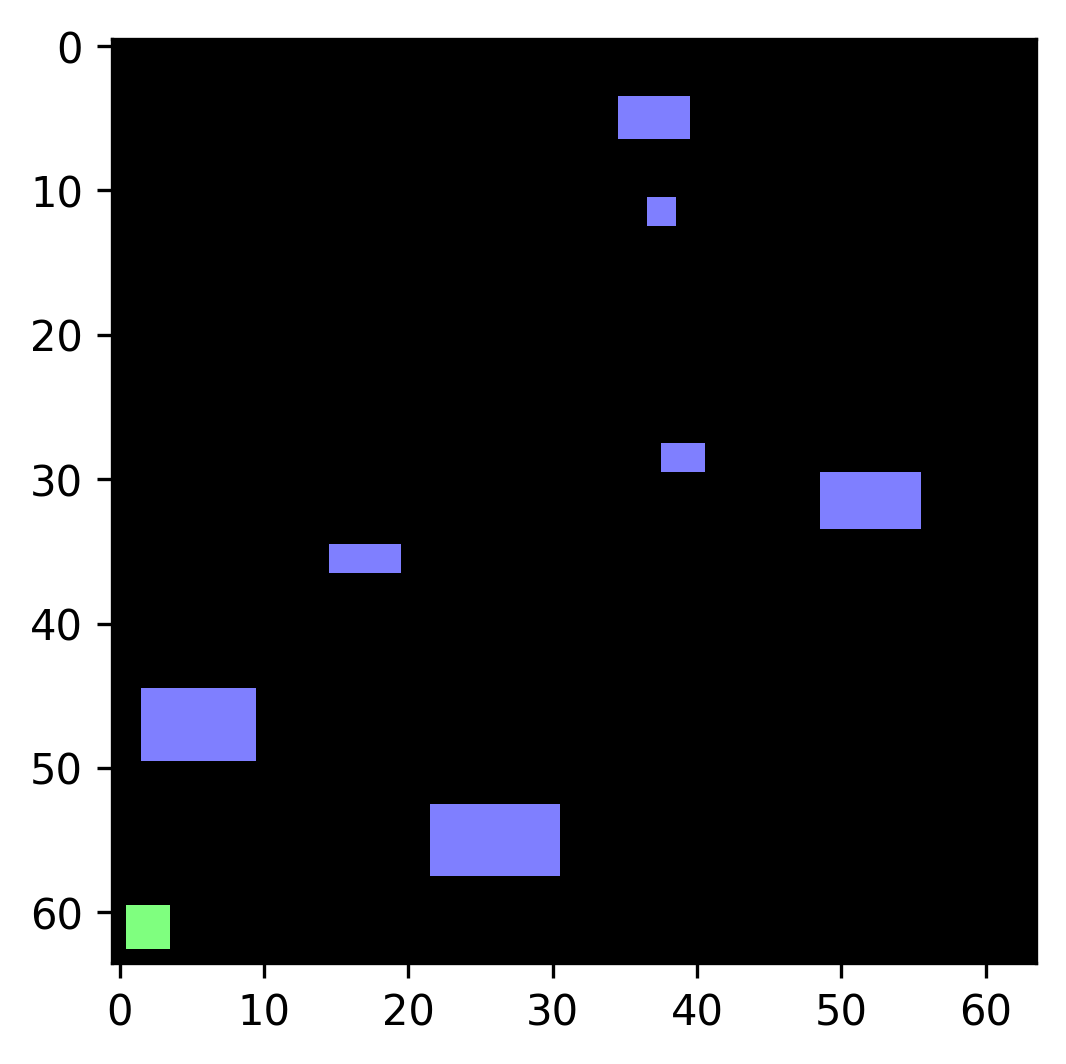

(3, 64, 64)


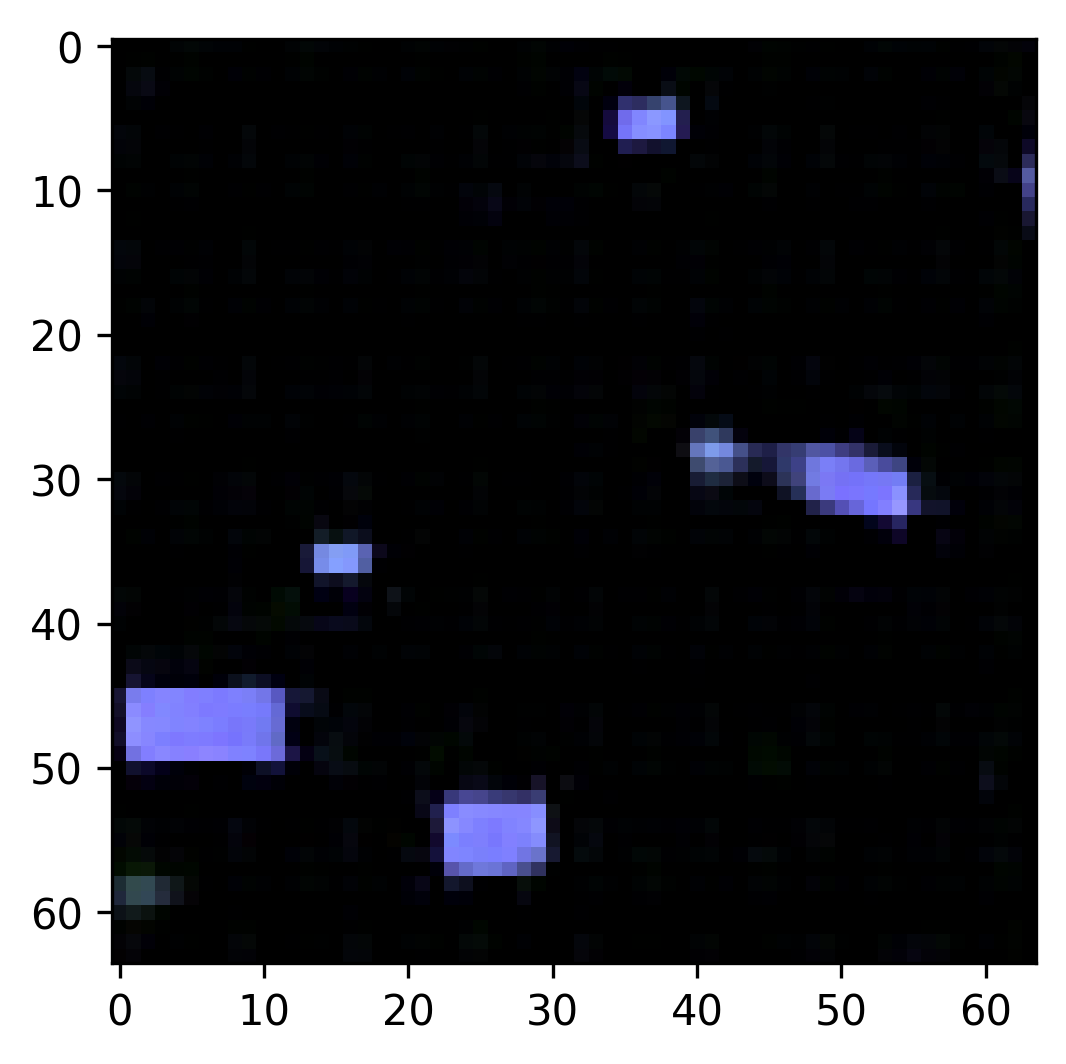

2
repr, std, cov, conv, closs 0.6435829401016235 0.46484375 0.00020147464238107204 0.004467949271202087 0.25153088569641113
6.701232803729542 0.025364797289965917 1.0
repr, std, cov, conv, closs 0.6743382215499878 0.4638671875 0.00022170785814523697 0.004417745396494865 0.2482260763645172
6.667826924128049 0.025137651357565752 1.0
repr, std, cov, conv, closs 0.6563088893890381 0.46337890625 0.00024022418074309826 0.004622850101441145 0.24794436991214752
6.627959614388852 0.02449281398043028 1.0
repr, std, cov, conv, closs 0.6617128849029541 0.4638671875 0.00022550206631422043 0.004607013892382383 0.25341174006462097
6.594919004195665 0.024273476802013742 1.0
repr, std, cov, conv, closs 0.6383662223815918 0.462890625 0.00025234371423721313 0.0038858288899064064 0.2475520521402359
6.387324592139298 0.02350939794948013 1.0
repr, std, cov, conv, closs 0.6656447052955627 0.463623046875 0.00023184320889413357 0.004406006541103125 0.25658535957336426
6.406505734276815 0.023322166290822264 1.0

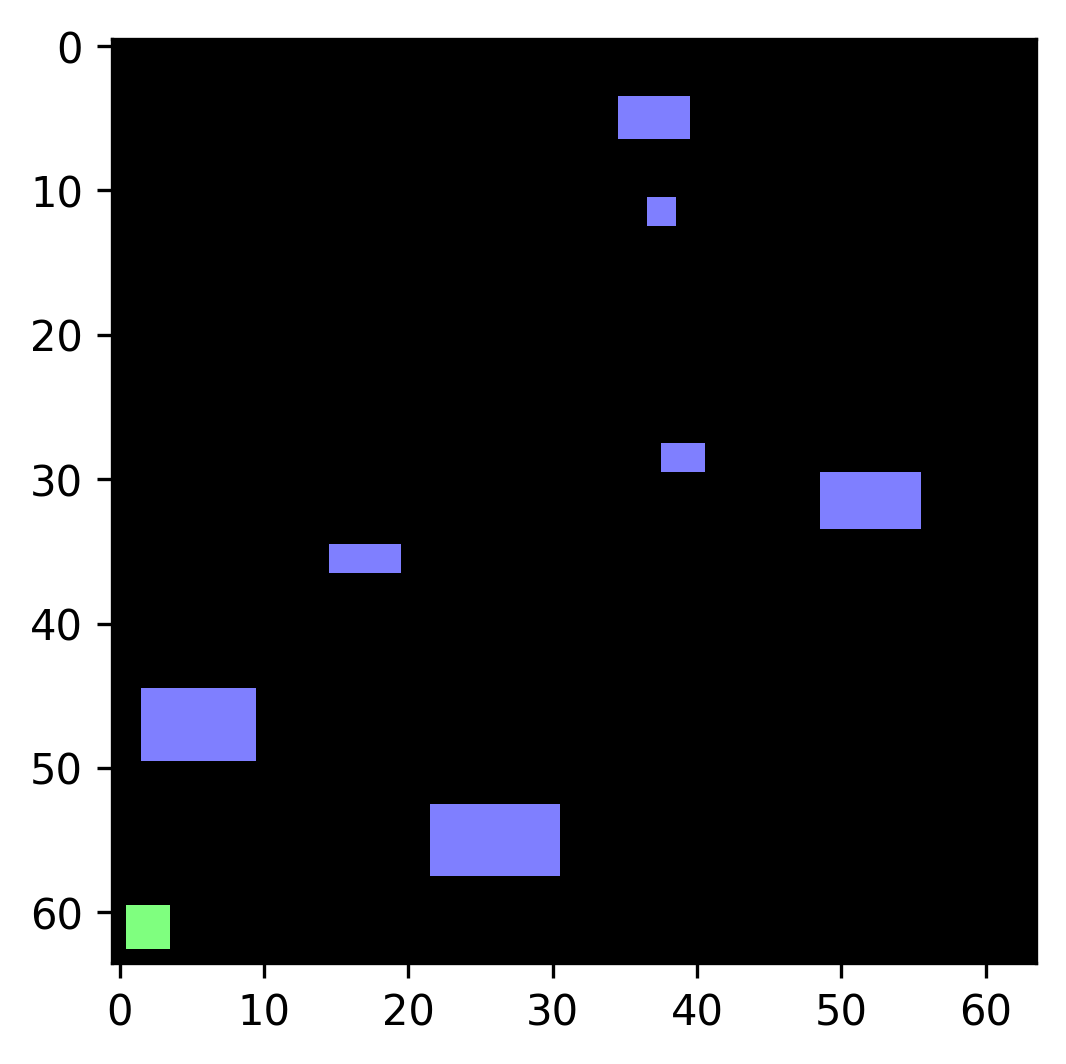

(3, 64, 64)


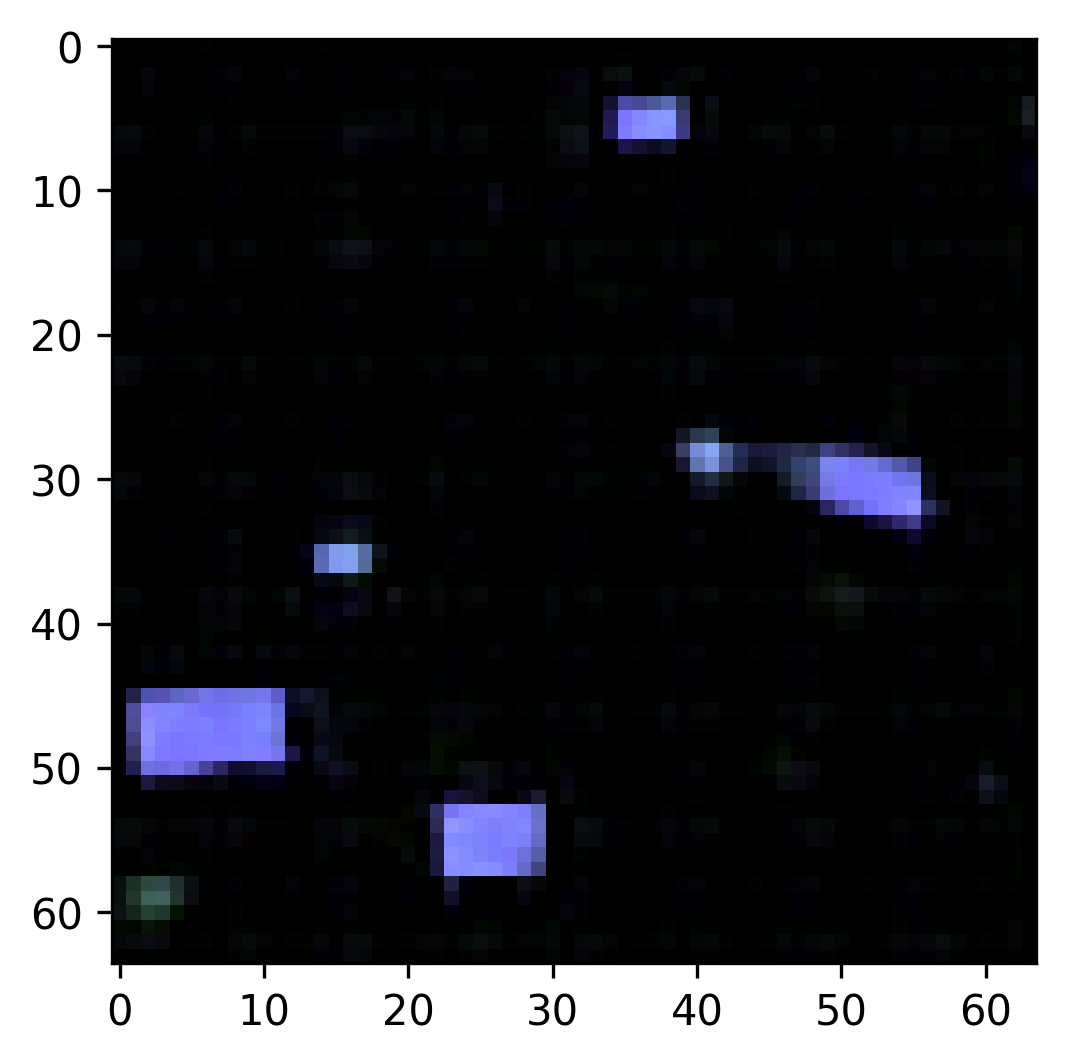

3
repr, std, cov, conv, closs 0.6404847502708435 0.46630859375 0.0001670799683779478 0.0047392044216394424 0.25000566244125366
7.792923359820004 0.01961884715334866 1.0
repr, std, cov, conv, closs 0.6480433940887451 0.467041015625 0.00015147891826927662 0.0044722664169967175 0.24966499209403992
7.792923359820004 0.01961884715334866 1.0
repr, std, cov, conv, closs 0.6459664106369019 0.466796875 0.00015296600759029388 0.004729582462459803 0.24967072904109955
7.934394680509523 0.01961884715334866 1.0
repr, std, cov, conv, closs 0.6445106267929077 0.466796875 0.00015622819773852825 0.004432251676917076 0.25162869691848755
7.942329075190031 0.01961884715334866 1.0
repr, std, cov, conv, closs 0.6362419128417969 0.467041015625 0.0001522365491837263 0.004636107943952084 0.24953442811965942
8.062301580495664 0.01961884715334866 1.0
repr, std, cov, conv, closs 0.6413581371307373 0.466552734375 0.0001597660593688488 0.004225252196192741 0.24921166896820068
7.990102343543059 0.019443157149666795 1

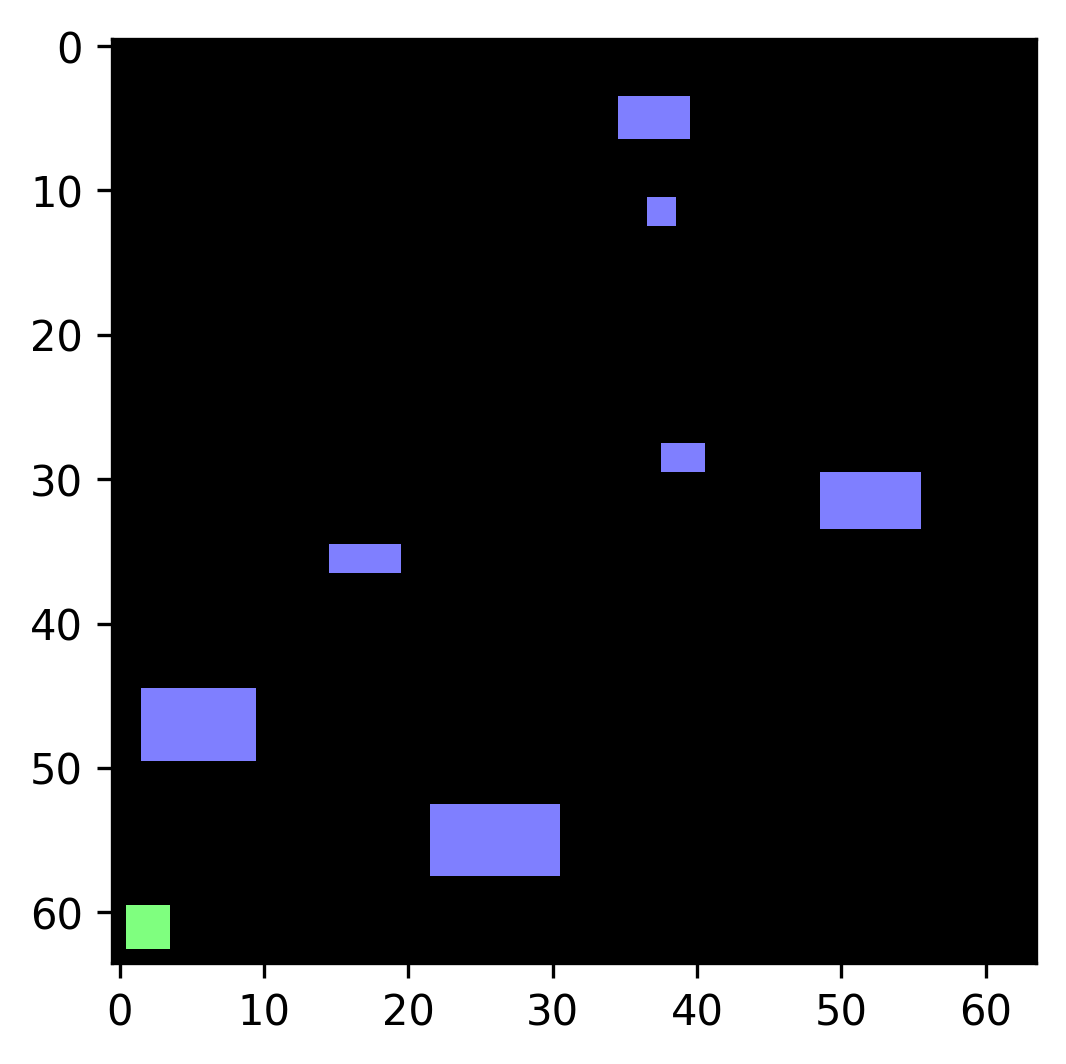

(3, 64, 64)


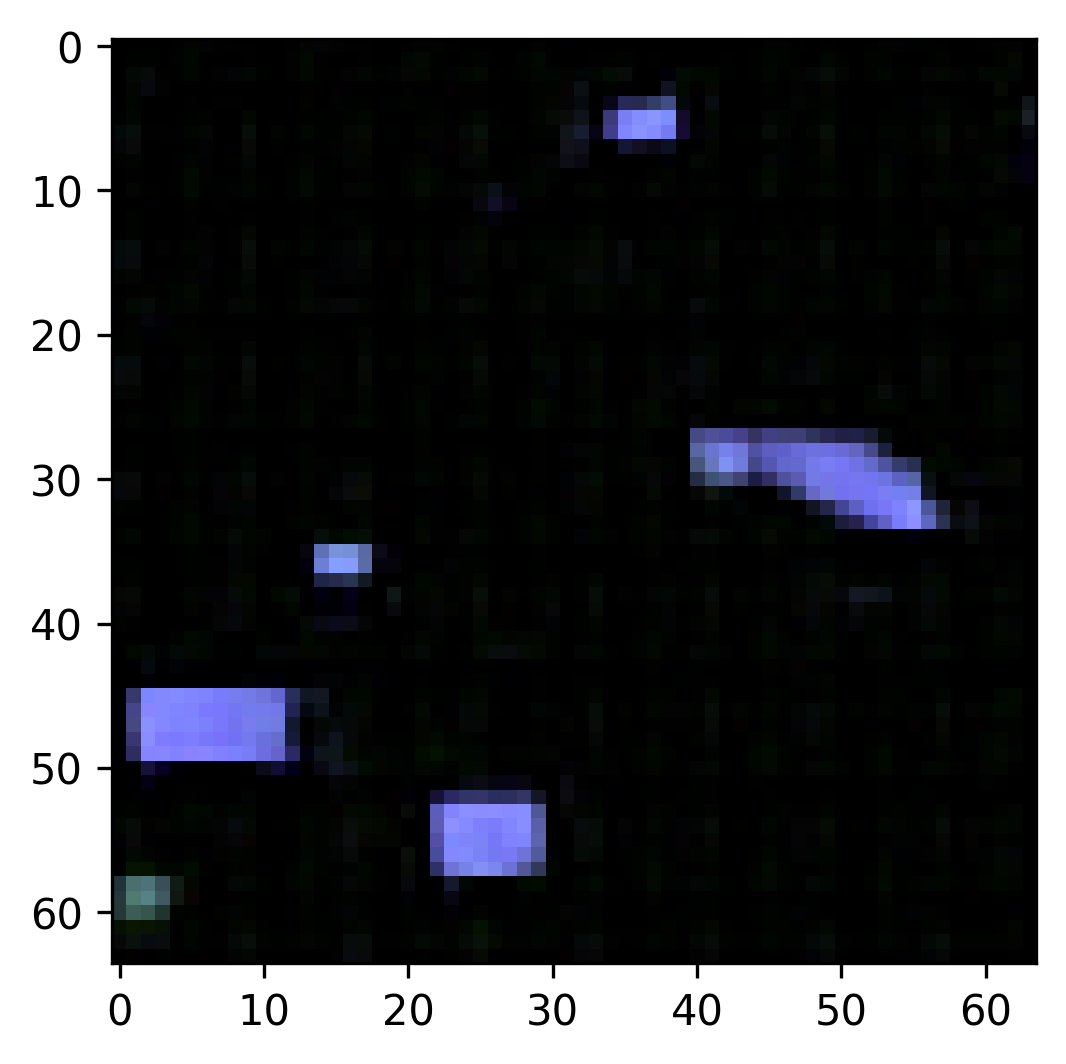

4
repr, std, cov, conv, closs 0.6382148265838623 0.469482421875 0.00011218222789466381 0.004509631544351578 0.24668577313423157
9.31966440446959 0.01571477919744096 1.0
repr, std, cov, conv, closs 0.6393529772758484 0.4697265625 0.00010621035471558571 0.00489999633282423 0.2536349594593048
9.31966440446959 0.01571477919744096 1.0
repr, std, cov, conv, closs 0.6342353224754333 0.46923828125 0.00011566770263016224 0.0044154636561870575 0.24979737401008606
9.536391148832527 0.015699080117323638 1.0
repr, std, cov, conv, closs 0.645433783531189 0.469482421875 0.000111408531665802 0.00430348701775074 0.24915602803230286
9.52686428454798 0.015605214440127819 1.0
repr, std, cov, conv, closs 0.6287429928779602 0.468505859375 0.00013214419595897198 0.004448737017810345 0.2520177662372589
9.536391148832527 0.015311659715202978 1.0
repr, std, cov, conv, closs 0.6381244659423828 0.46826171875 0.0001295488327741623 0.004048182629048824 0.24975697696208954
9.375722372395607 0.01505368942085727 1.0
r

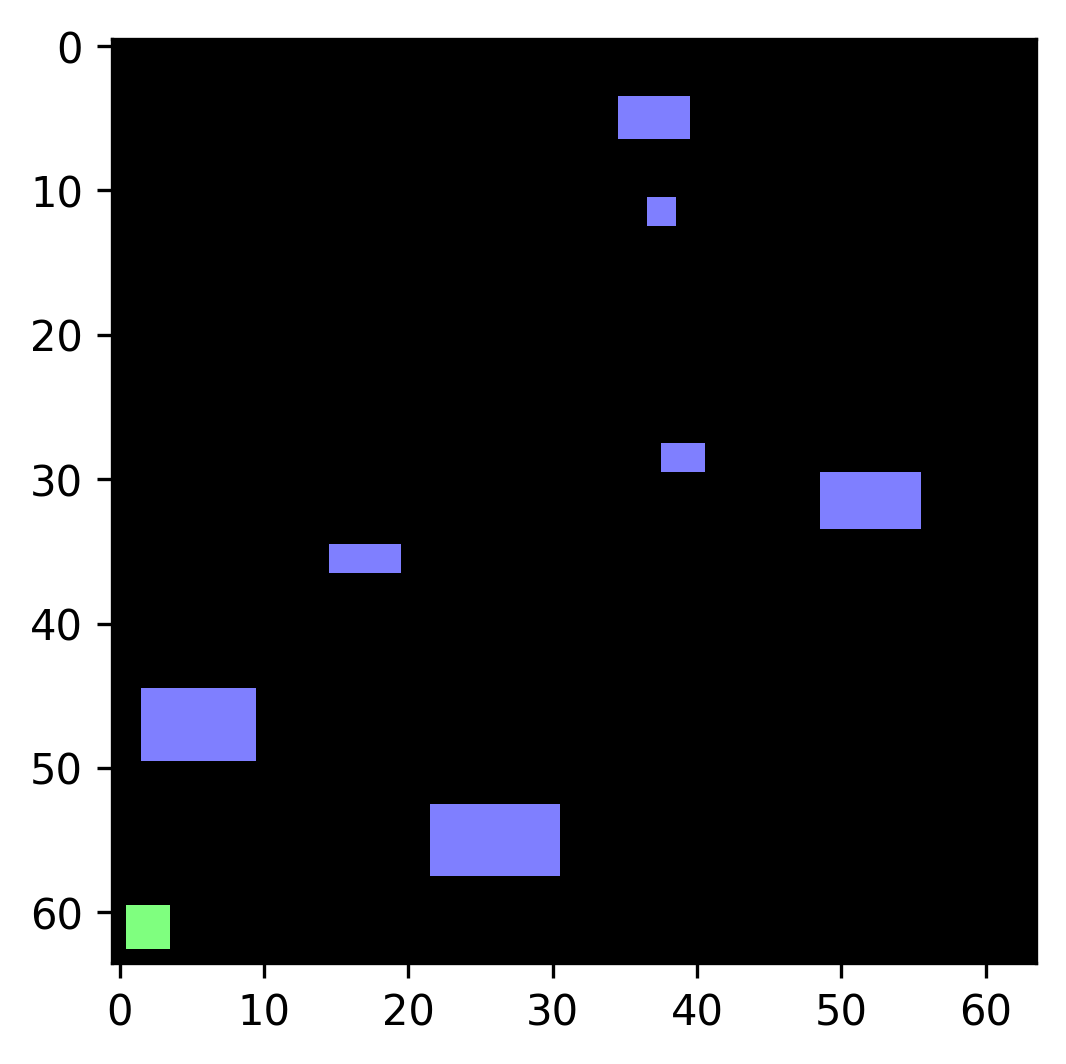

(3, 64, 64)


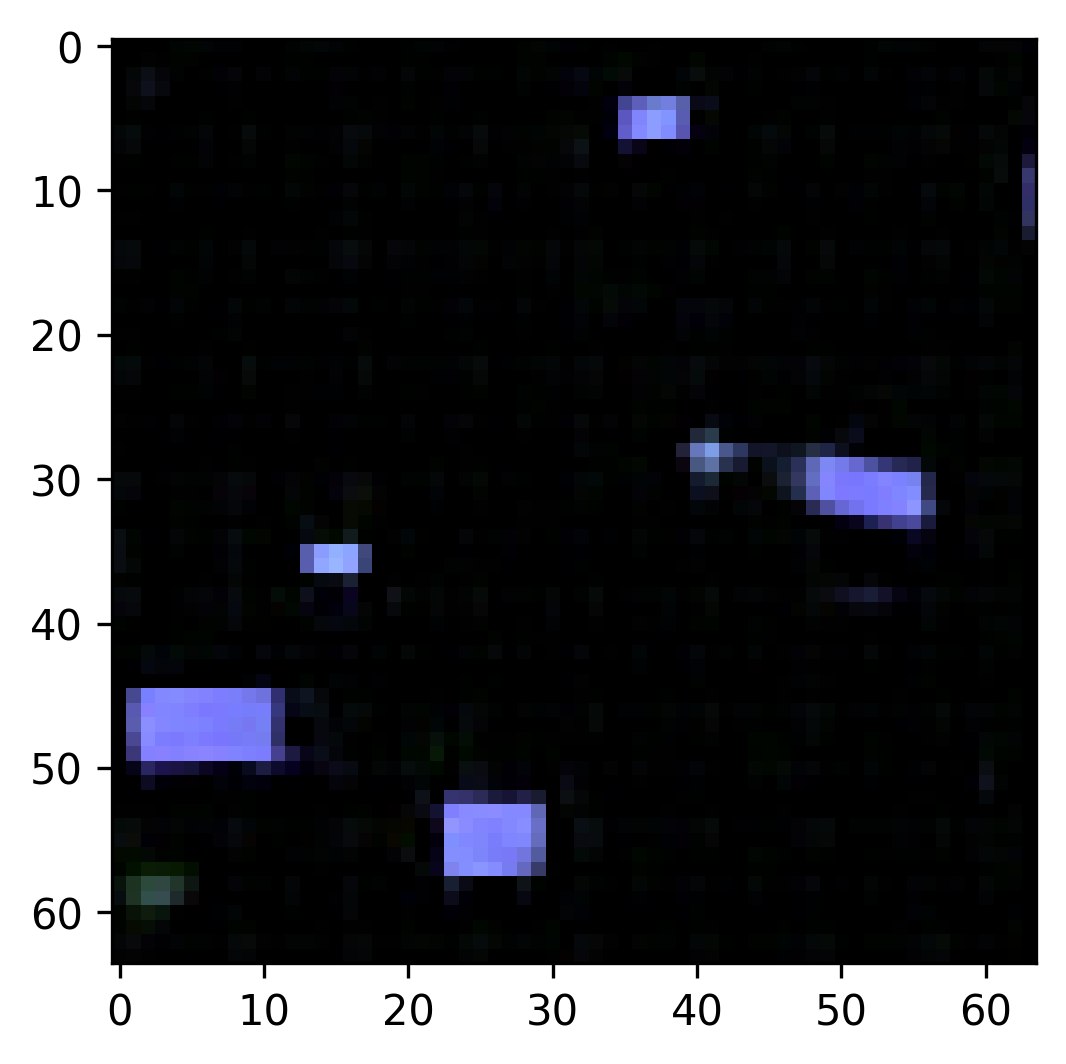

5
repr, std, cov, conv, closs 0.6341367959976196 0.47021484375 0.00010547158308327198 0.0037341758143156767 0.2508075535297394
11.404701552066358 0.012191372569130512 1.0
repr, std, cov, conv, closs 0.6599892377853394 0.470947265625 9.001698344945908e-05 0.00406768498942256 0.25087088346481323
11.336512204257398 0.01211847967135587 1.0
repr, std, cov, conv, closs 0.6408283710479736 0.471435546875 8.396641351282597e-05 0.004405836574733257 0.2497834712266922
11.291279294228316 0.01207012669552104 1.0
repr, std, cov, conv, closs 0.6597548127174377 0.47119140625 8.849659934639931e-05 0.004761668853461742 0.2497791200876236
11.37055576174329 0.01207012669552104 1.0
repr, std, cov, conv, closs 0.6618509292602539 0.47119140625 8.637667633593082e-05 0.004256989806890488 0.25046560168266296
11.438949882231912 0.012021966649025162 1.0
repr, std, cov, conv, closs 0.6639058589935303 0.47216796875 7.500080391764641e-05 0.004392552655190229 0.250436007976532
11.62335218101435 0.012021966649025162 1

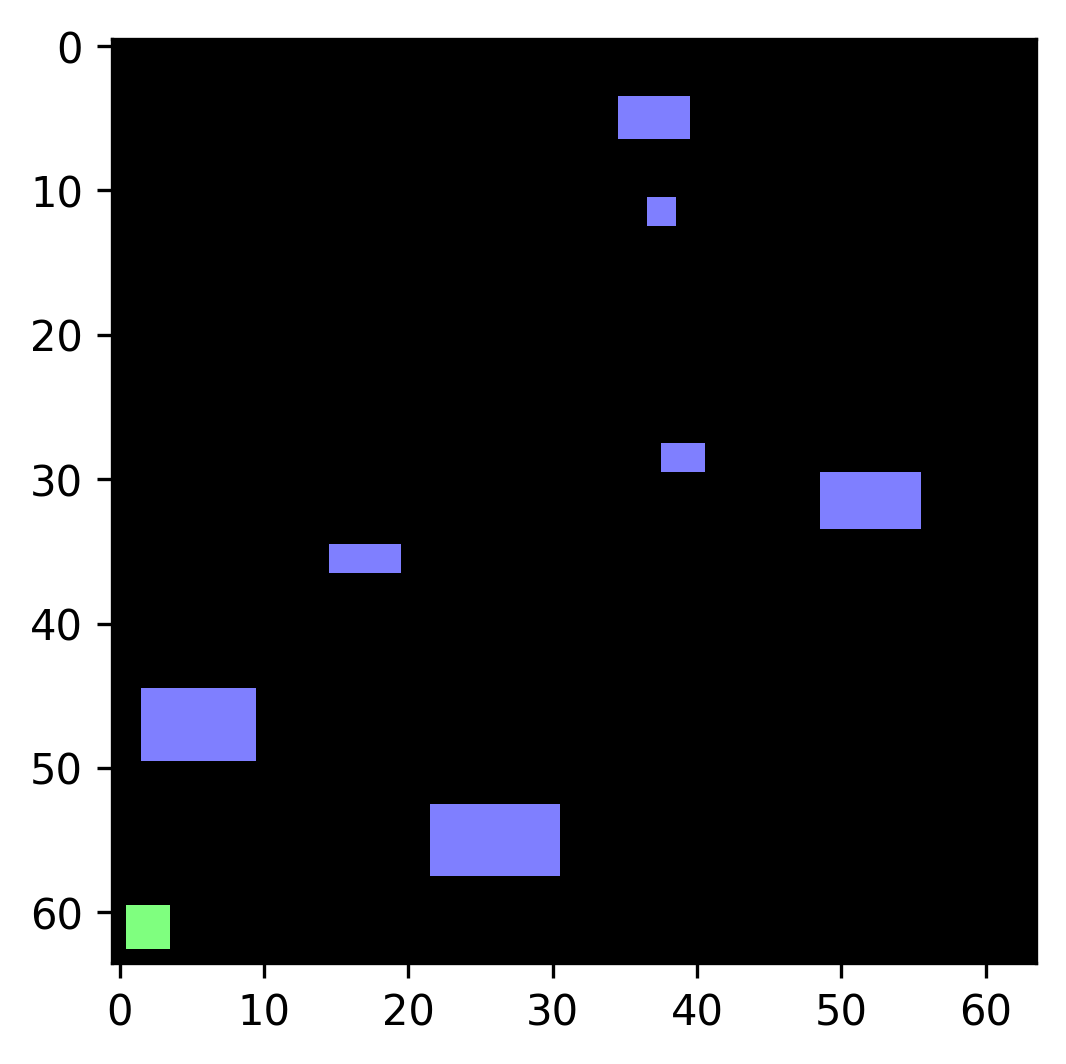

(3, 64, 64)


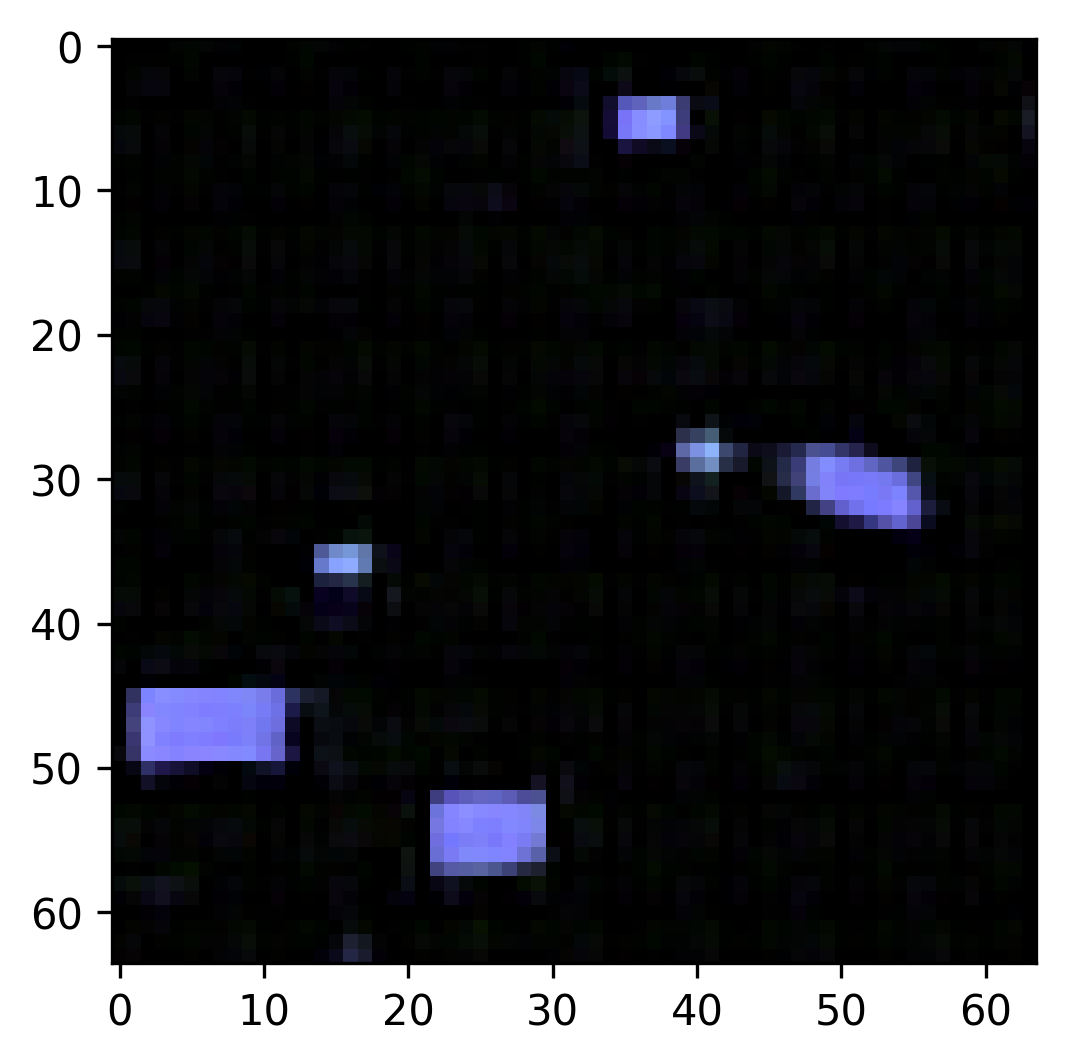

6
repr, std, cov, conv, closs 0.6668948531150818 0.473388671875 6.433785893023014e-05 0.004965351428836584 0.24975353479385376
14.744900184991097 0.010173832419583017 1.0
repr, std, cov, conv, closs 0.7036959528923035 0.47314453125 6.381701678037643e-05 0.004471336491405964 0.2500011622905731
14.759645085176087 0.010113002507091065 1.0
repr, std, cov, conv, closs 0.6737282276153564 0.47314453125 6.413296796381474e-05 0.004440595395863056 0.2500021457672119
14.656739602924782 0.009952561622150299 1.0
repr, std, cov, conv, closs 0.7025025486946106 0.4736328125 6.071873940527439e-05 0.005086157005280256 0.2499615103006363
14.759645085176087 0.009952561622150299 1.0
repr, std, cov, conv, closs 0.6963244676589966 0.473388671875 6.602145731449127e-05 0.005057414527982473 0.24971053004264832
15.178542949660354 0.009912850702574475 1.0
repr, std, cov, conv, closs 0.6998941898345947 0.47314453125 6.463658064603806e-05 0.00468027126044035 0.2501988112926483
15.377052286291494 0.00988317152859094

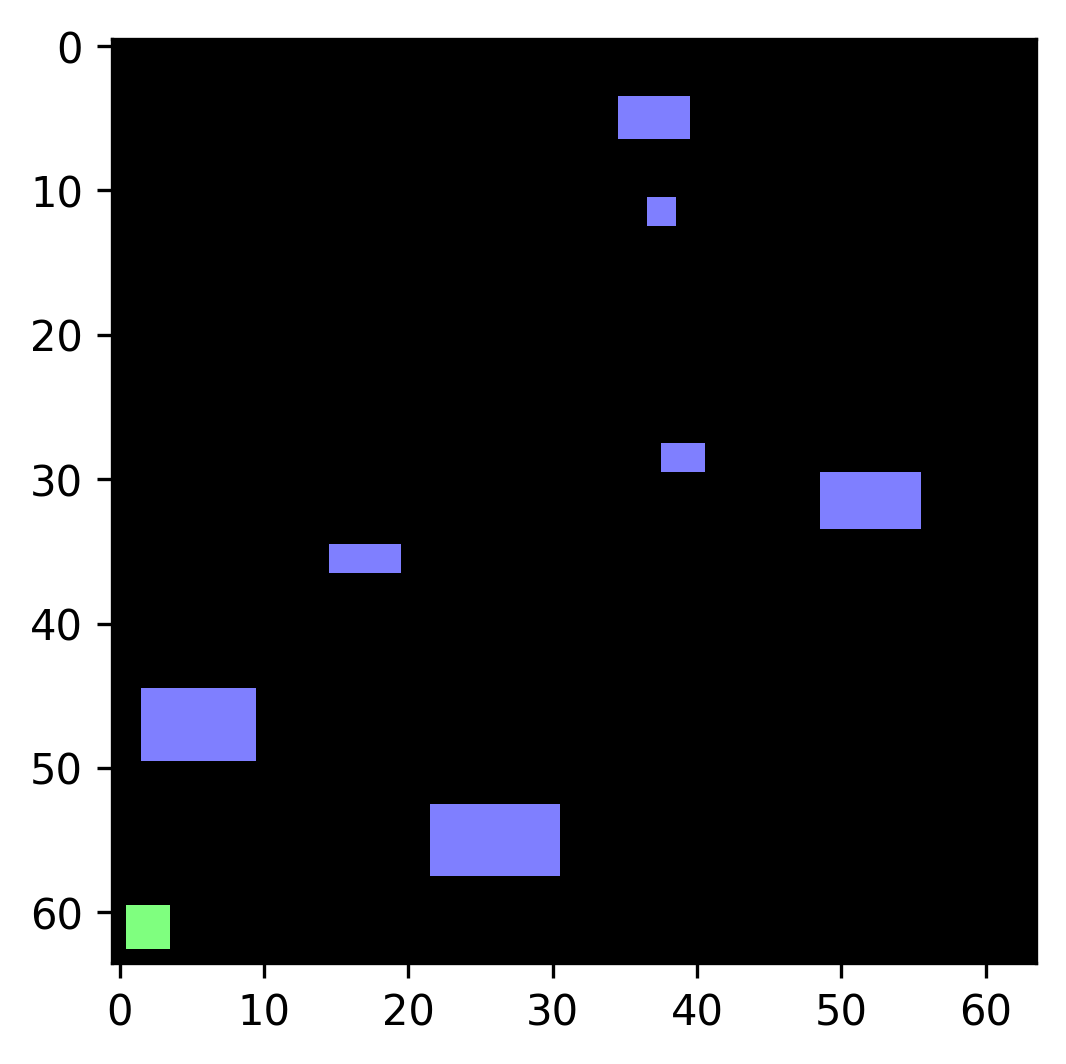

(3, 64, 64)


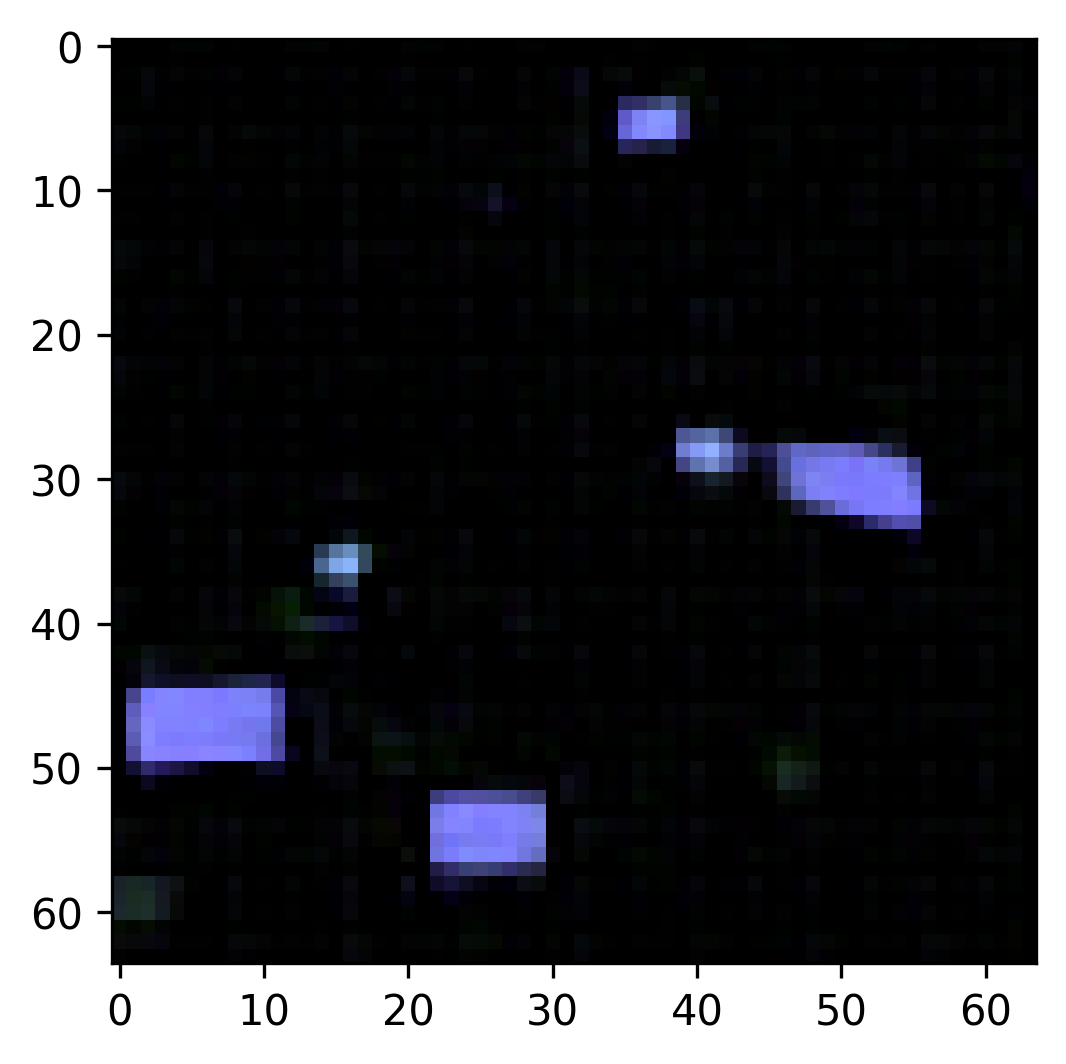

7
repr, std, cov, conv, closs 0.655534029006958 0.4755859375 4.237191751599312e-05 0.004780870862305164 0.2501777410507202
16.94254339150634 0.008133008466708933 1.0
repr, std, cov, conv, closs 0.668979287147522 0.4755859375 4.369579255580902e-05 0.0045599499717354774 0.2499106228351593
16.959485934897845 0.008133008466708933 1.0
repr, std, cov, conv, closs 0.6593021154403687 0.47509765625 4.703435115516186e-05 0.004528705030679703 0.250041127204895
16.707117303435634 0.00801198379507131 1.0
repr, std, cov, conv, closs 0.6590667963027954 0.474609375 5.038338713347912e-05 0.004910496529191732 0.24957141280174255
16.409227162472796 0.007869129050069014 1.0
repr, std, cov, conv, closs 0.6640894412994385 0.474853515625 4.938151687383652e-05 0.004961599595844746 0.2514757215976715
16.26227983381188 0.0076902929795496094 1.0
repr, std, cov, conv, closs 0.6790110468864441 0.474609375 5.023740231990814e-05 0.005090863443911076 0.24921956658363342
16.37645787027438 0.007606205124362381 1.0
repr

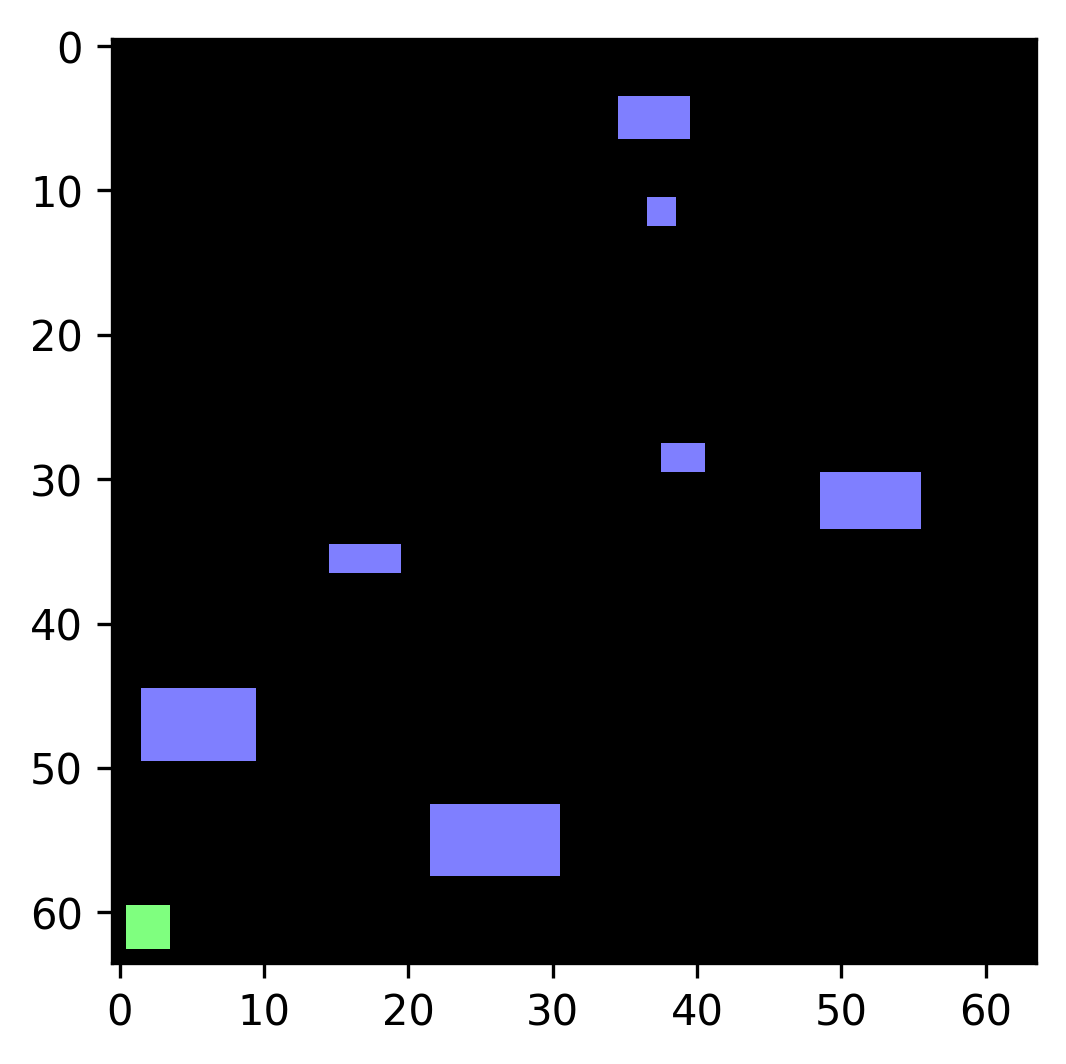

(3, 64, 64)


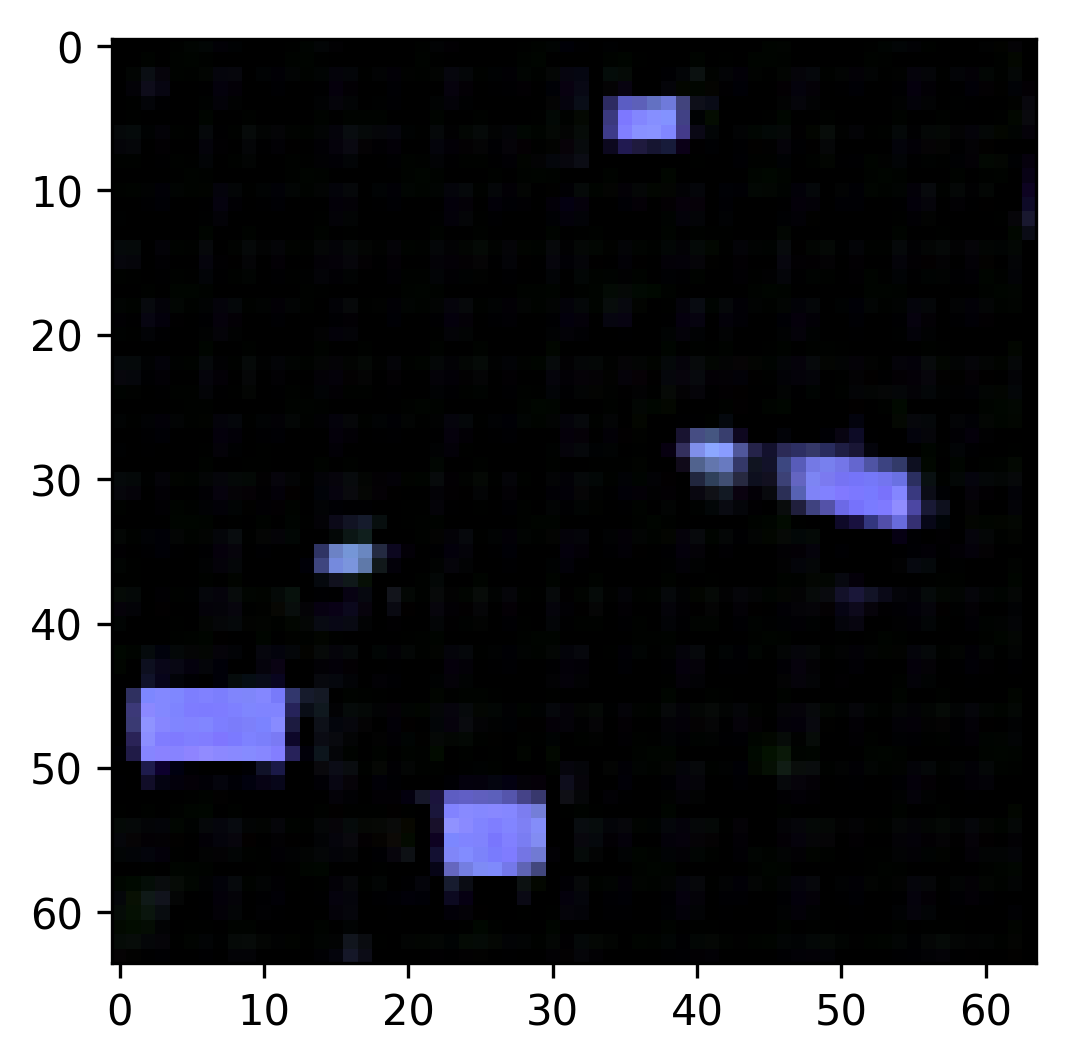

8
repr, std, cov, conv, closs 0.6216658353805542 0.4755859375 4.428229294717312e-05 0.004576177801936865 0.24728772044181824
16.740548245159804 0.006814272715508536 1.0
repr, std, cov, conv, closs 0.6544532775878906 0.47607421875 3.951019607484341e-05 0.0038412604480981827 0.24922876060009003
16.79082012828056 0.006917205414692345 1.0
repr, std, cov, conv, closs 0.620815634727478 0.4765625 3.6402372643351555e-05 0.004251963924616575 0.24909113347530365
16.824418559357248 0.007142021481328977 1.0
repr, std, cov, conv, closs 0.6566667556762695 0.4765625 3.658444620668888e-05 0.004219436552375555 0.24500319361686707
16.85808422089452 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.6569081544876099 0.476806640625 3.382004797458649e-05 0.0051454221829771996 0.250898540019989
17.405988751461244 0.007463122345104794 1.0
repr, std, cov, conv, closs 0.6351842880249023 0.476806640625 3.543333150446415e-05 0.004324060864746571 0.2500253915786743
17.423394740212704 0.007508013175385033 1.0


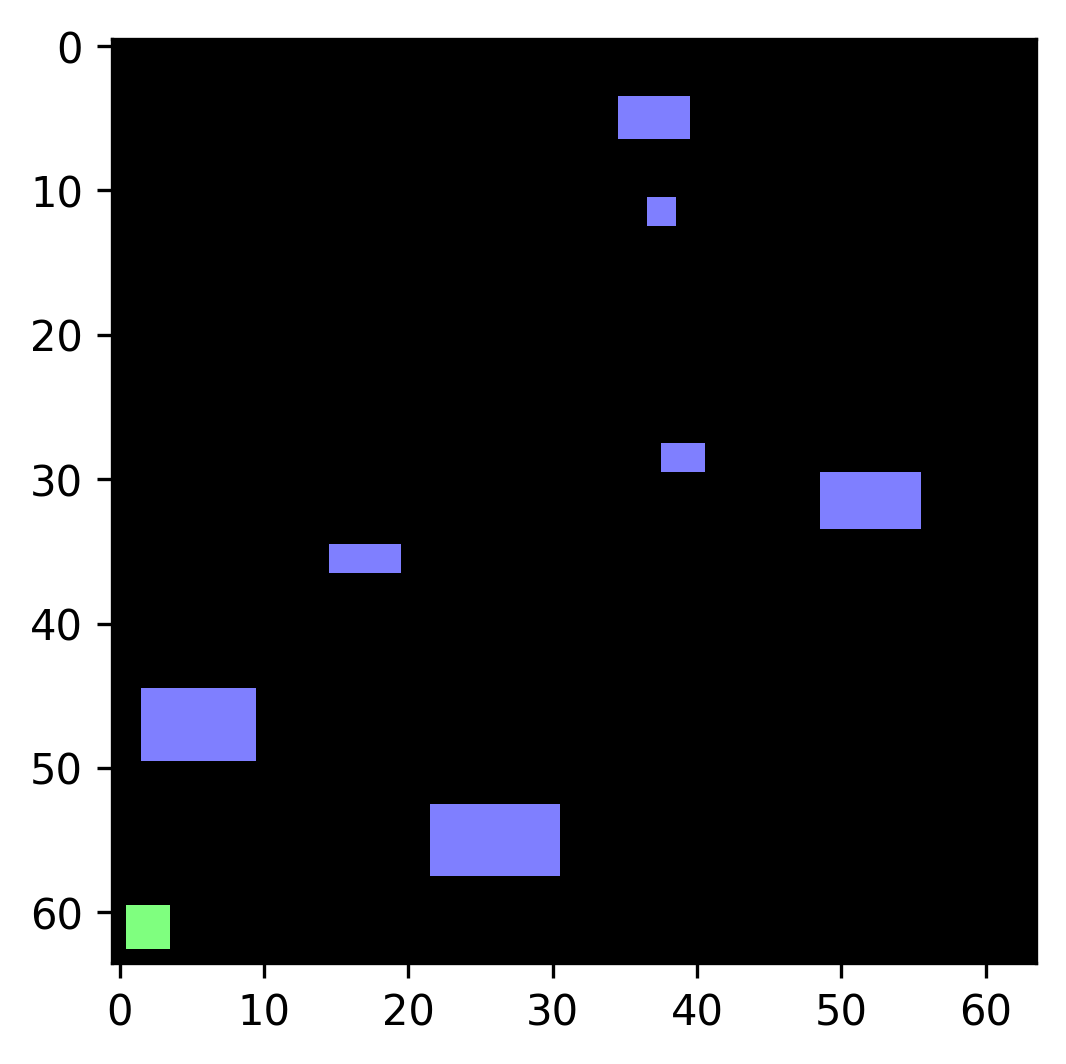

(3, 64, 64)


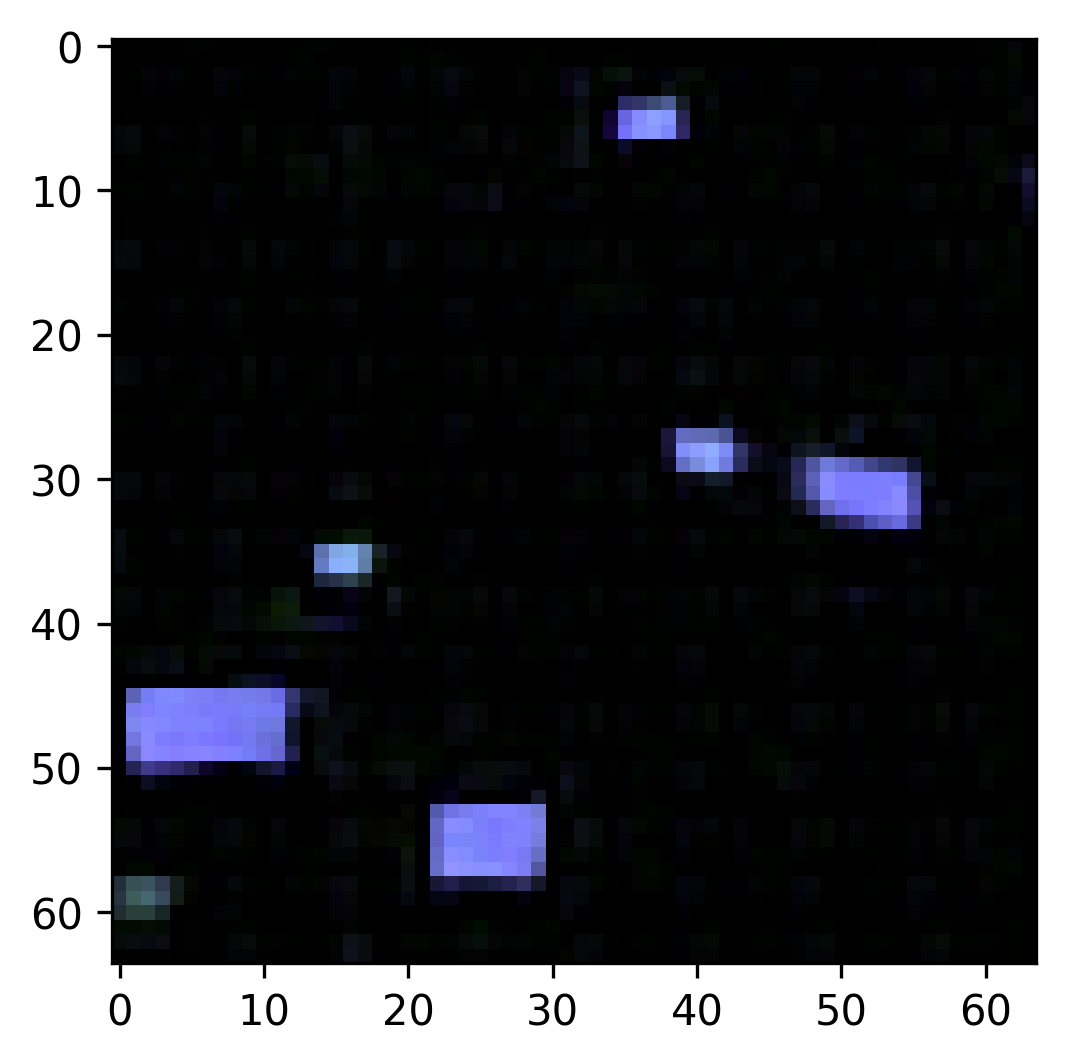

9
repr, std, cov, conv, closs 0.6504388451576233 0.4755859375 4.266737960278988e-05 0.003972736187279224 0.24802398681640625
18.27967605233859 0.0073815184383786685 1.0
repr, std, cov, conv, closs 0.6583719253540039 0.474609375 5.130213685333729e-05 0.004069898743182421 0.2673265337944031
17.95374697809511 0.007249904975194557 1.0
repr, std, cov, conv, closs 0.6638476848602295 0.47509765625 4.701642319560051e-05 0.005101651884615421 0.25170934200286865
17.721973921965088 0.007021692959272518 1.0
repr, std, cov, conv, closs 0.6405068039894104 0.4755859375 4.3955398723483086e-05 0.004091579467058182 0.2511879801750183
17.405988751461244 0.006896495232612317 1.0
repr, std, cov, conv, closs 0.6672848463058472 0.475341796875 4.5268796384334564e-05 0.005036788992583752 0.2443082481622696
16.959485934897845 0.0066860872323651465 1.0
repr, std, cov, conv, closs 0.6675930023193359 0.475830078125 4.111044108867645e-05 0.004408958368003368 0.23887185752391815
17.129846009817964 0.0066794078245406

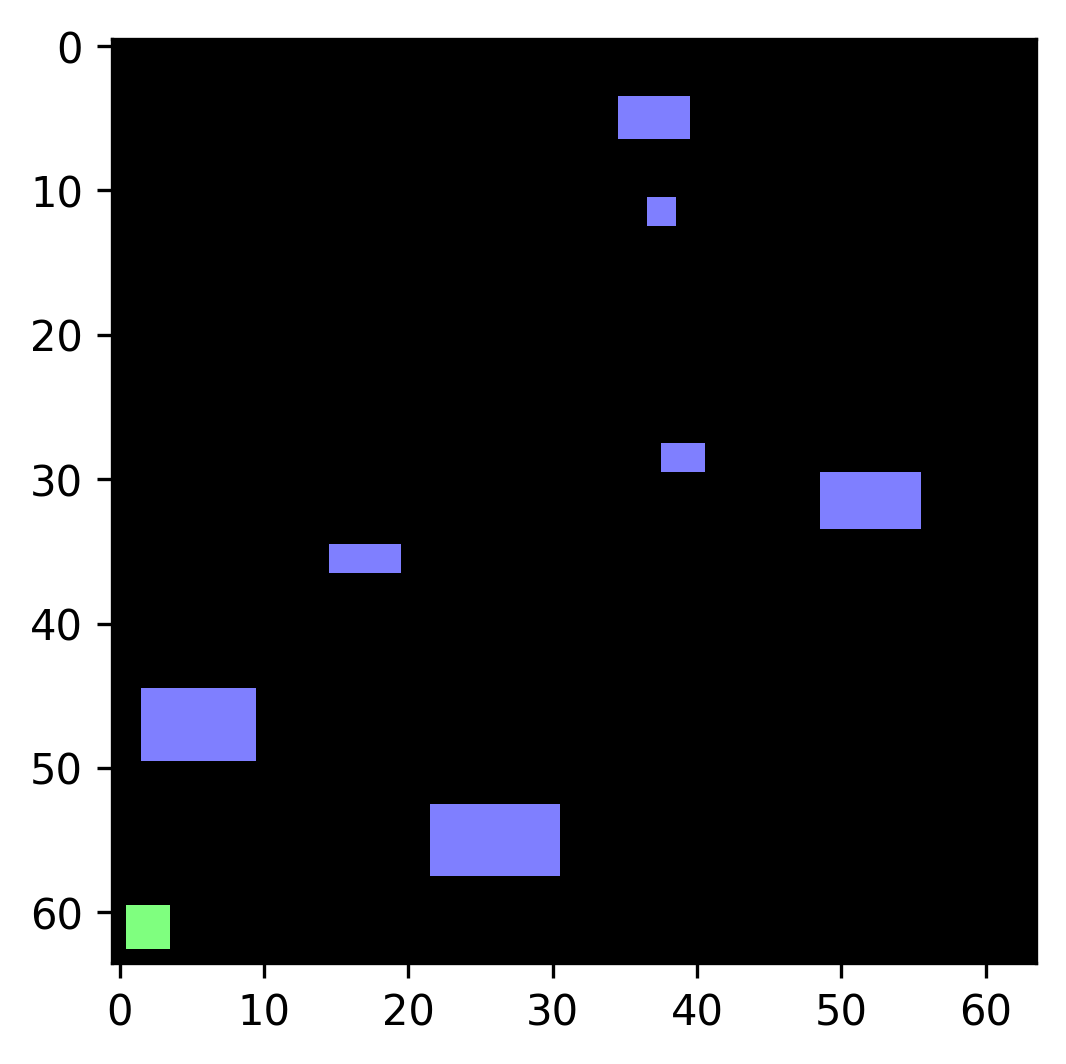

(3, 64, 64)


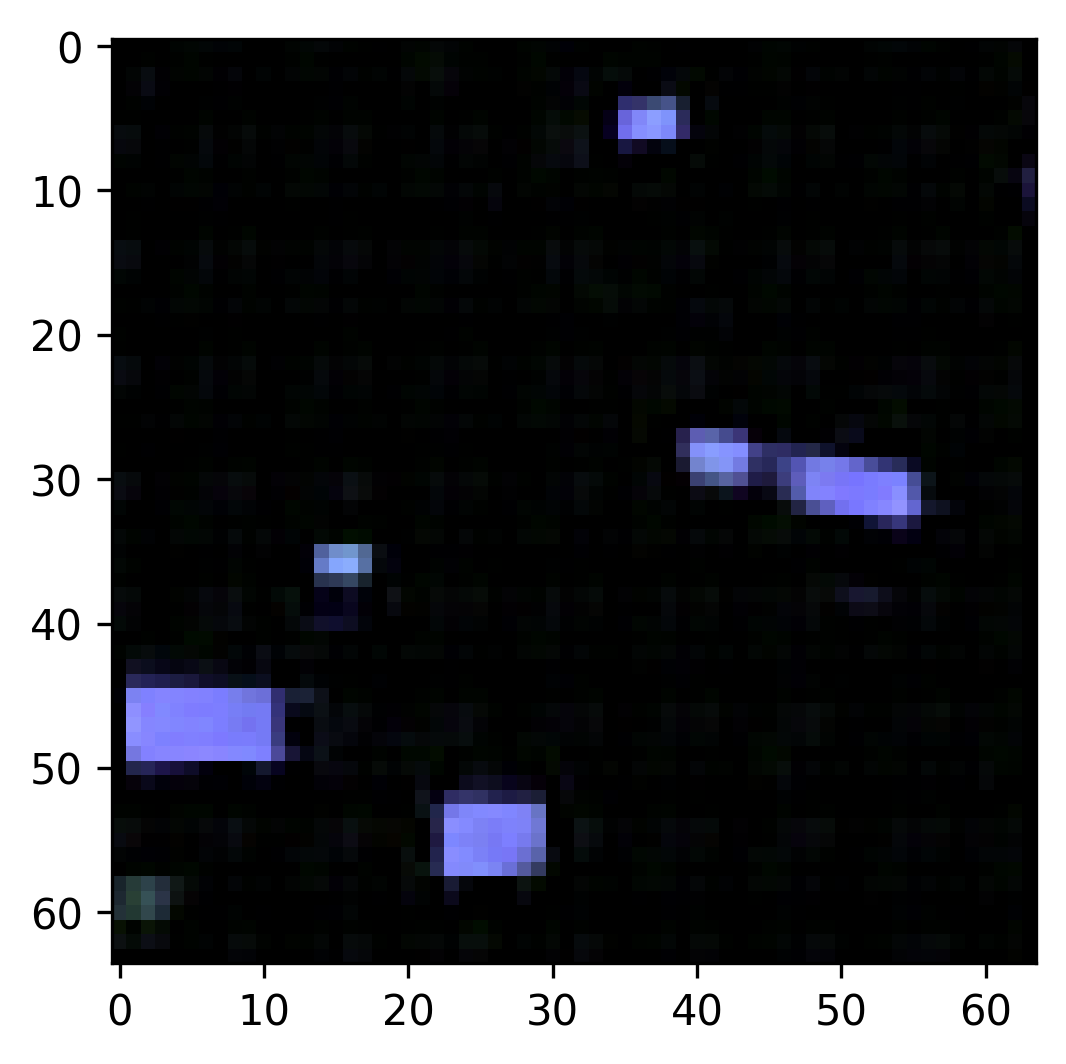

10
repr, std, cov, conv, closs 0.664821207523346 0.4765625 3.6242417991161346e-05 0.0041492776945233345 0.24997712671756744
18.89265751729697 0.007206557388264859 1.0
repr, std, cov, conv, closs 0.6966298818588257 0.476318359375 3.70941124856472e-05 0.004760988987982273 0.2500075697898865
19.15888085024994 0.00733738392719879 1.0
repr, std, cov, conv, closs 0.6807228326797485 0.4765625 3.6840327084064484e-05 0.005039643496274948 0.24958926439285278
19.781563563237533 0.0075758562140578675 1.0
repr, std, cov, conv, closs 0.6947879195213318 0.47607421875 4.06892504543066e-05 0.005077852867543697 0.2503677010536194
19.96031143574124 0.007644312288135522 1.0
repr, std, cov, conv, closs 0.6649501323699951 0.4755859375 4.3501611799001694e-05 0.004270430654287338 0.25025278329849243
19.702634729680202 0.007463122345104794 1.0
repr, std, cov, conv, closs 0.6615025997161865 0.475341796875 4.48497012257576e-05 0.004027543123811483 0.2498302459716797
19.351334111484576 0.007330053873325465 1.0
re

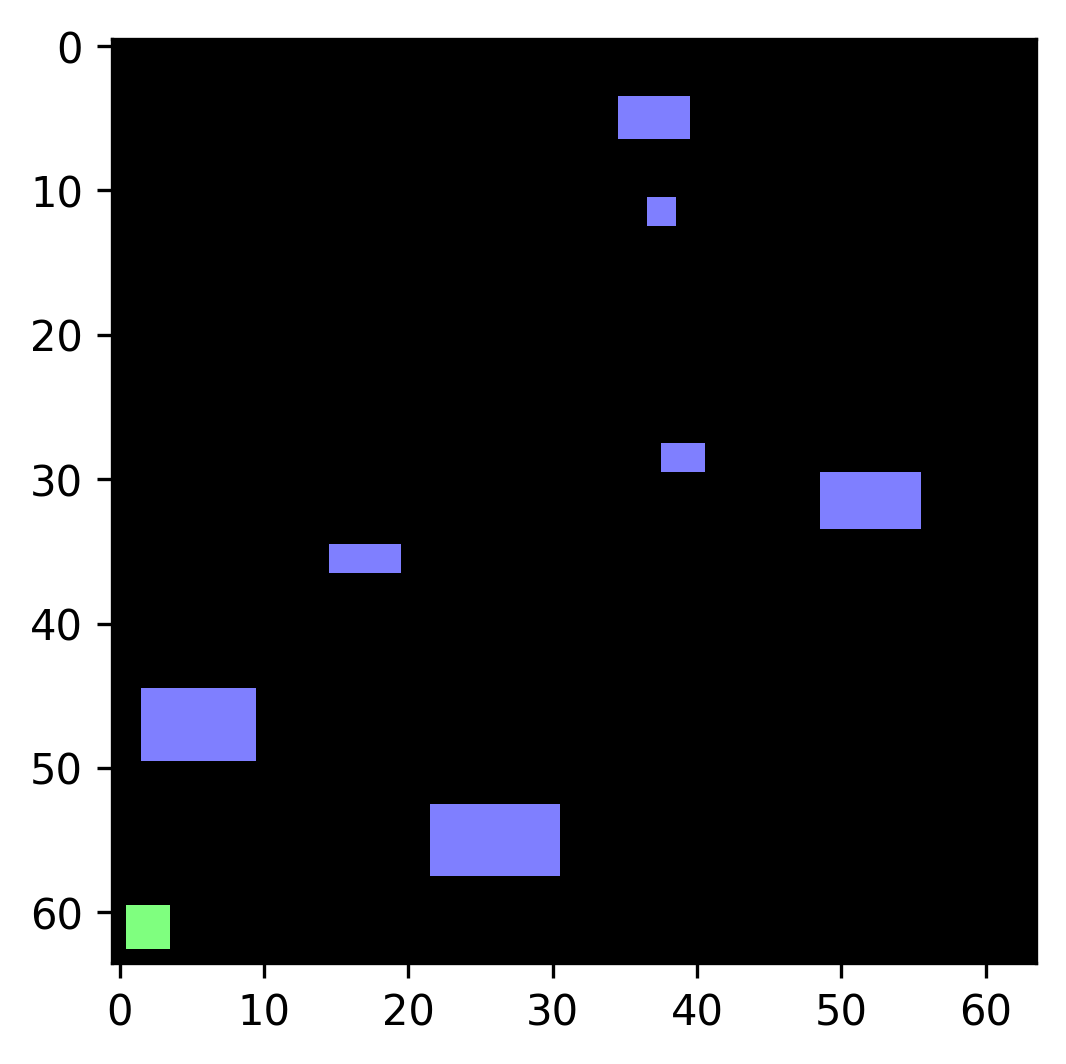

(3, 64, 64)


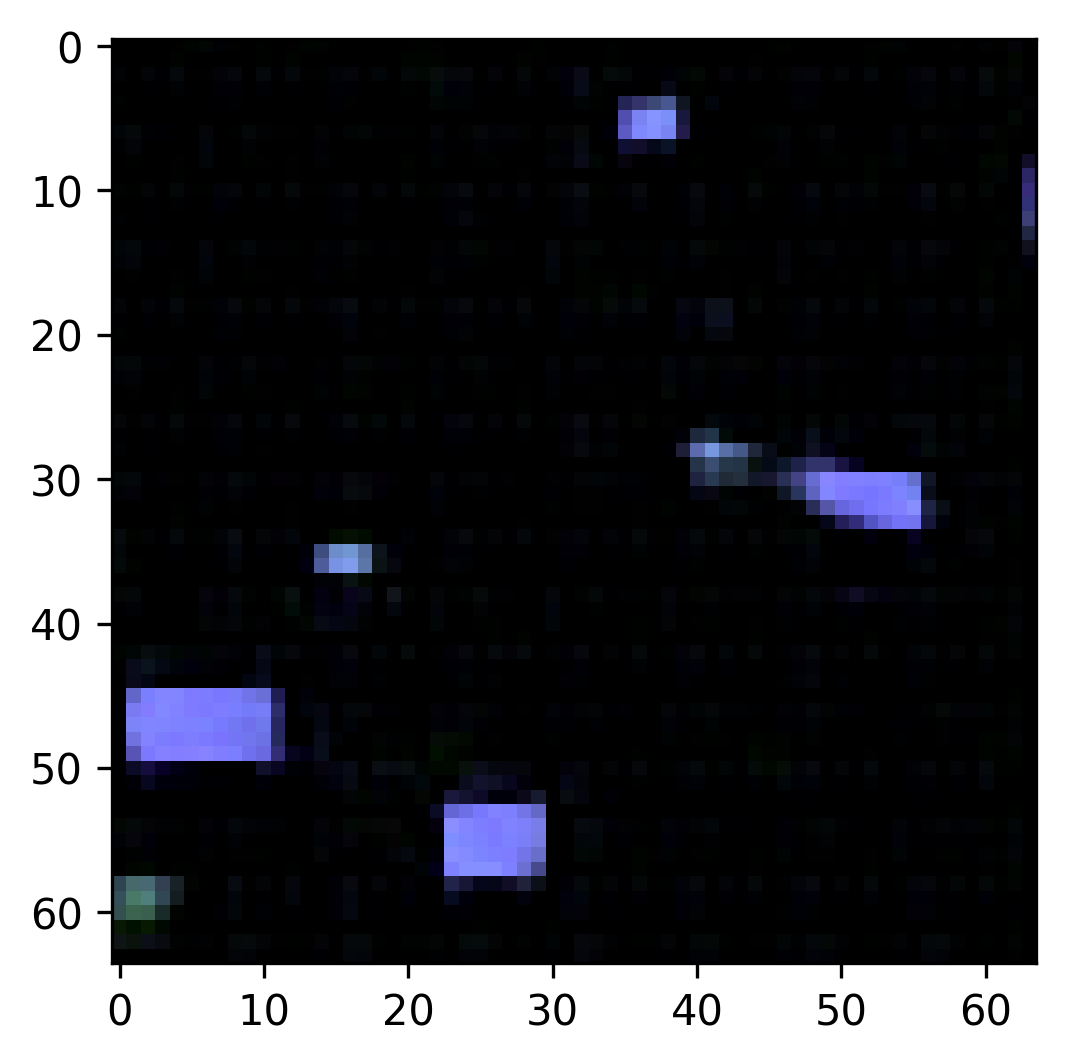

11
repr, std, cov, conv, closs 0.8104149103164673 0.47607421875 4.0245940908789635e-05 0.005295705050230026 0.25033971667289734
22.34694027841101 0.006726304180889895 1.0
repr, std, cov, conv, closs 0.8351331949234009 0.475341796875 4.5155175030231476e-05 0.005858858581632376 0.2505989968776703
22.52634276796027 0.0066727350894511565 1.0
repr, std, cov, conv, closs 0.8312480449676514 0.47607421875 3.987574018537998e-05 0.00593632971867919 0.2508390247821808
22.798150586762258 0.006540671444823523 1.0
argm 0.9455584287643433 155.8421173095703
argm 0.9185695648193359 153.49957275390625
argm 0.9158761501312256 155.96971130371094
argm 0.9183627963066101 155.8783416748047
repr, std, cov, conv, closs 0.9297290444374084 0.47607421875 3.9645470678806305e-05 0.004617365542799234 0.2486138790845871
23.212024087612683 0.006586593728190185 1.0
argm 0.933265745639801 168.6534881591797
argm 0.943194568157196 171.83786010742188
argm 0.9010327458381653 166.41746520996094
argm 0.9031370282173157 167.30

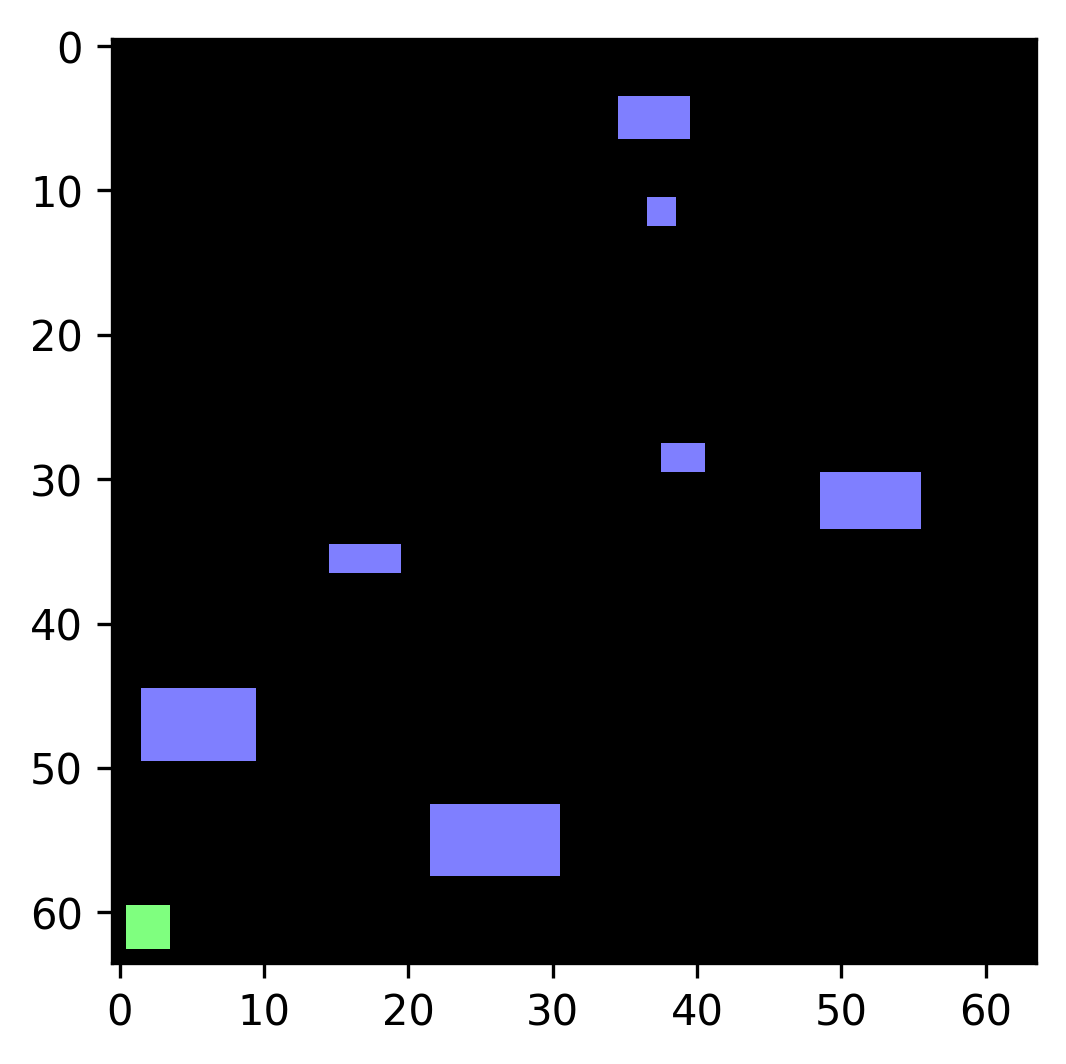

(3, 64, 64)


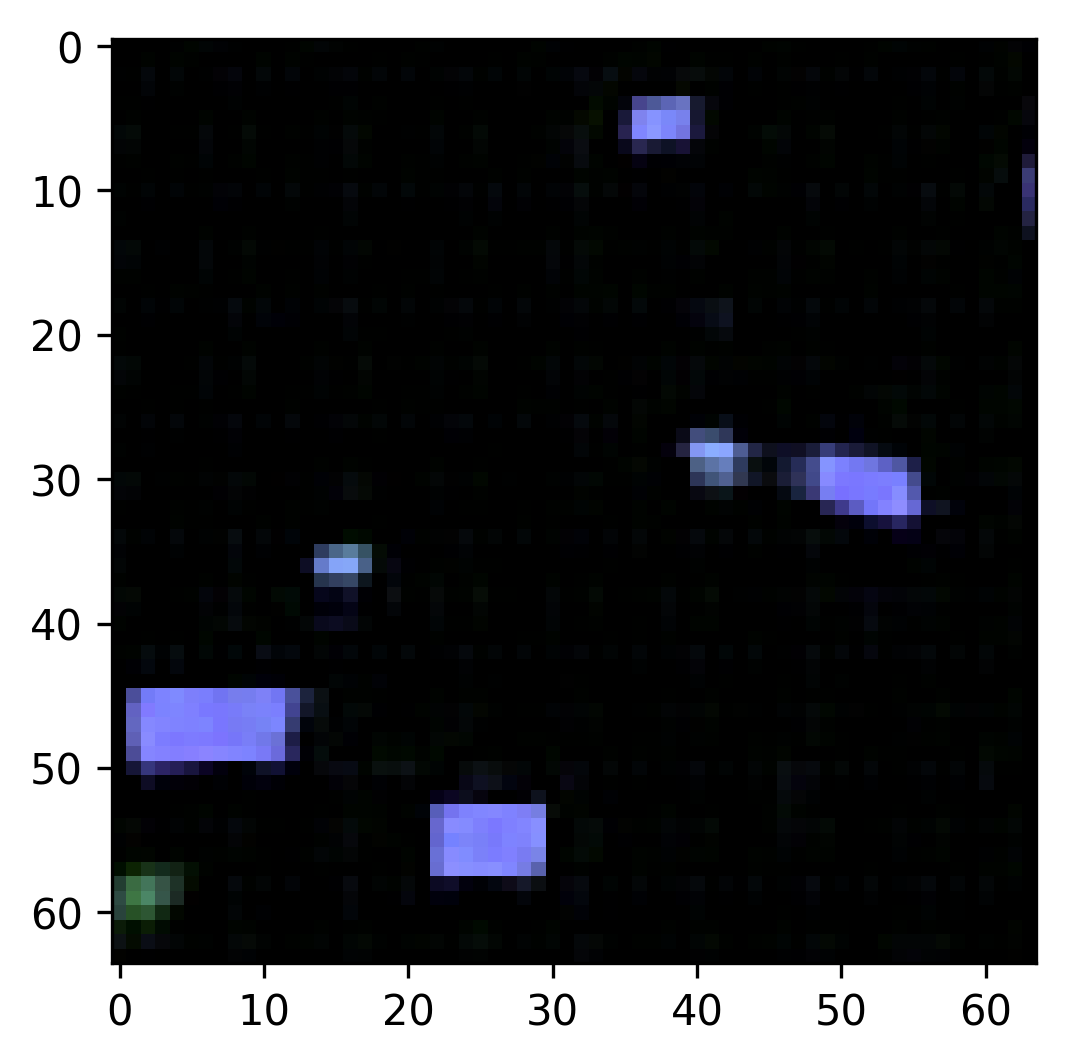

12
argm 0.9023270606994629 277.460205078125
argm 0.9036945104598999 278.24090576171875
argm 0.9005556702613831 277.4096984863281
argm 0.9010944366455078 277.72698974609375
argm 0.9007238149642944 276.479248046875
argm 0.9039182662963867 275.72747802734375
argm 0.9028244018554688 276.4149475097656
argm 0.9348993897438049 276.11309814453125
repr, std, cov, conv, closs 0.8667317032814026 0.4755859375 4.3825479224324226e-05 0.004885256290435791 0.24895775318145752
25.498597620053896 0.006972737127609584 1.0
argm 0.904970645904541 272.8120422363281
argm 0.9067679047584534 273.0361022949219
argm 0.9173800945281982 271.64117431640625
argm 0.9122492074966431 273.79132080078125
repr, std, cov, conv, closs 0.8697445392608643 0.476318359375 3.7633348256349564e-05 0.004602846689522266 0.24858307838439941
25.2702534836868 0.006875847057024229 1.0
argm 0.9116042852401733 268.1564636230469
argm 0.9008650779724121 268.1589660644531
repr, std, cov, conv, closs 0.8878765106201172 0.47607421875 4.1442224

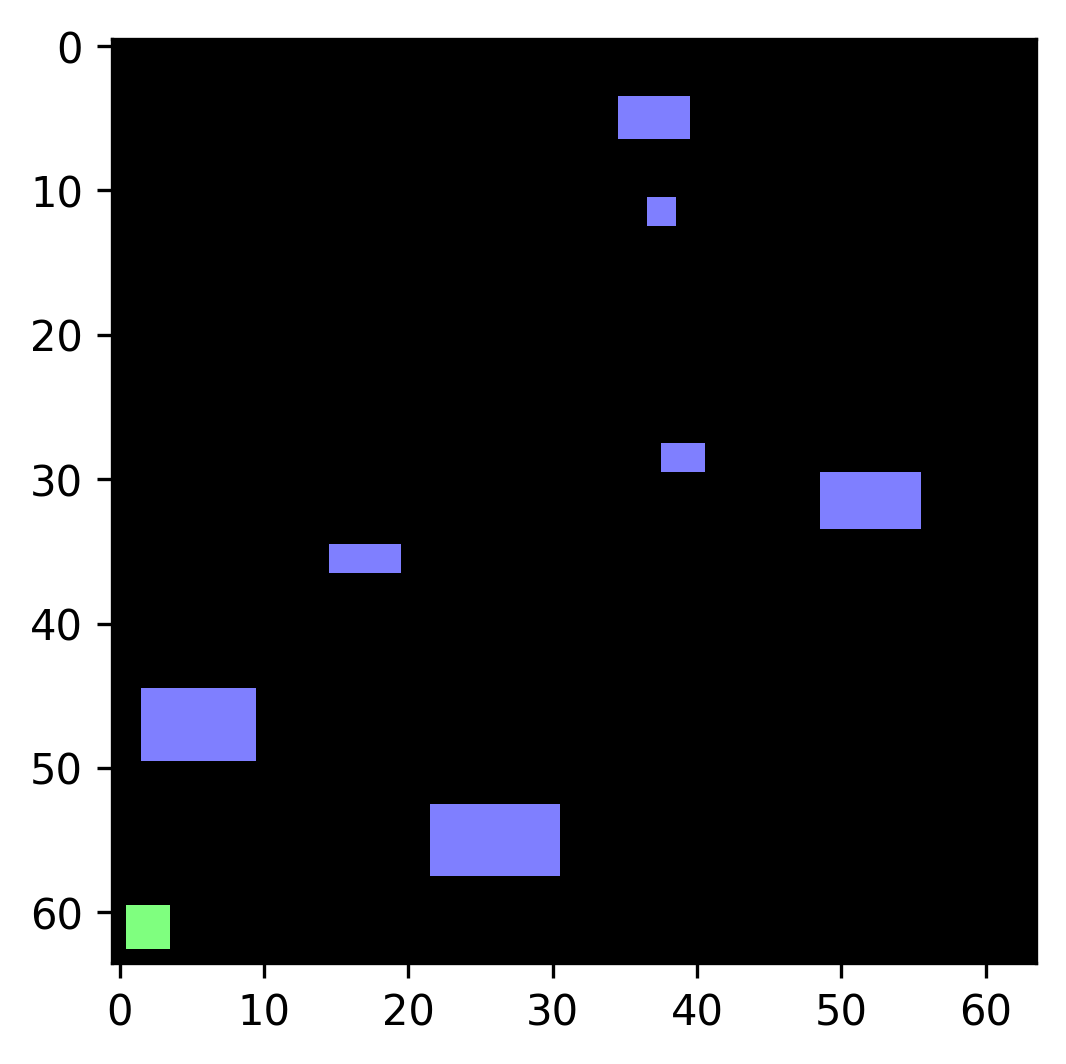

(3, 64, 64)


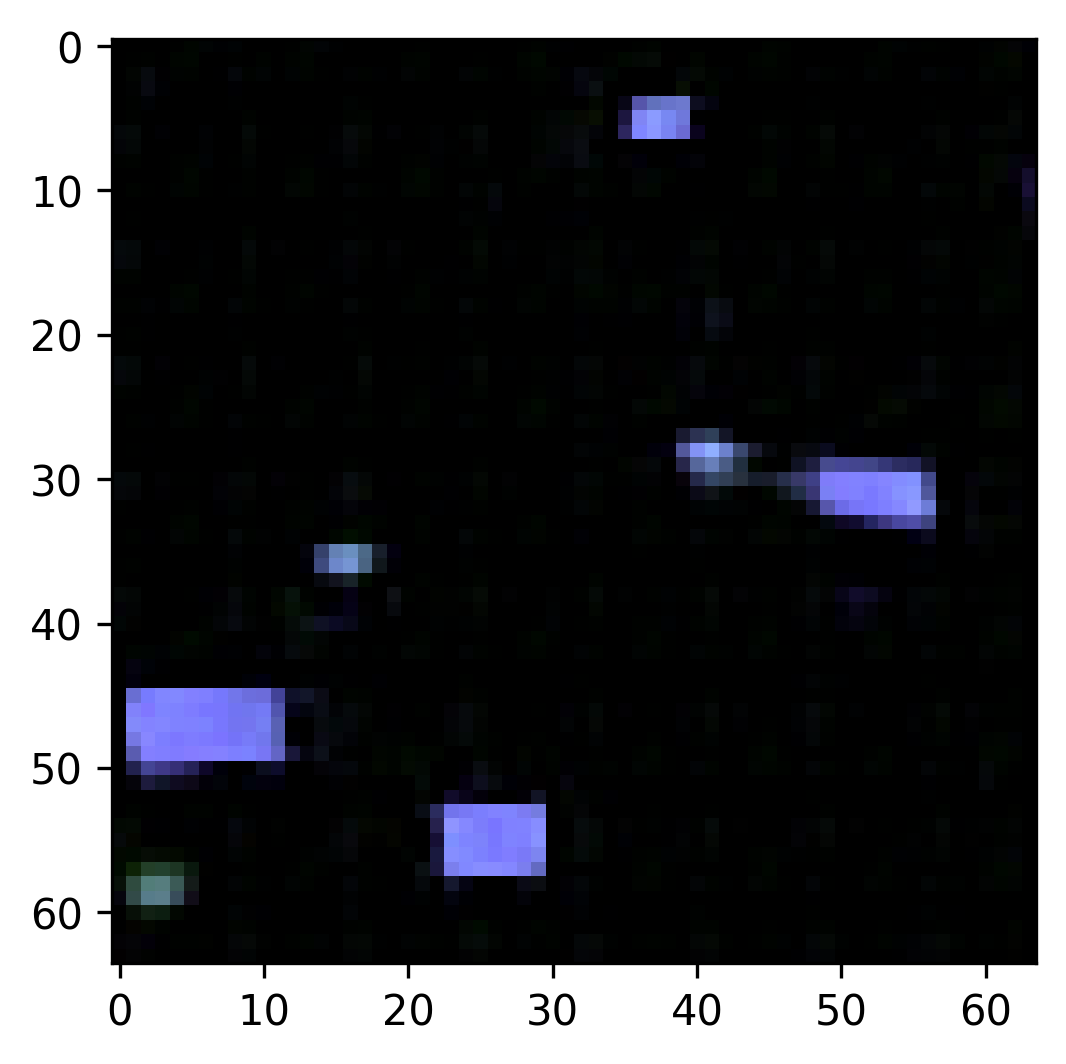

13
argm 0.9035213589668274 163.25172424316406
argm 0.9167951345443726 163.2435302734375
argm 0.9157198071479797 164.10853576660156
argm 0.9205286502838135 164.35299682617188
argm 0.9157602190971375 164.4467010498047
argm 0.9210273623466492 164.24404907226562
argm 0.9244357347488403 163.80715942382812
argm 0.9296287298202515 163.52972412109375
argm 0.9285598993301392 163.52328491210938
argm 0.9337261915206909 163.07504272460938
argm 0.934032142162323 163.48483276367188
argm 0.9316461682319641 162.80514526367188
argm 0.9313604235649109 163.49087524414062
argm 0.9277074337005615 163.66578674316406
argm 0.9313313961029053 163.41079711914062
argm 0.9330155253410339 163.0956268310547
argm 0.9323622584342957 163.3350830078125
argm 0.9375680685043335 163.10401916503906
argm 0.9432552456855774 163.41050720214844
argm 0.9454798698425293 163.43109130859375
argm 0.9404721260070801 163.66476440429688
argm 0.9421285390853882 163.04421997070312
argm 0.943041980266571 162.65428161621094
argm 0.9402382

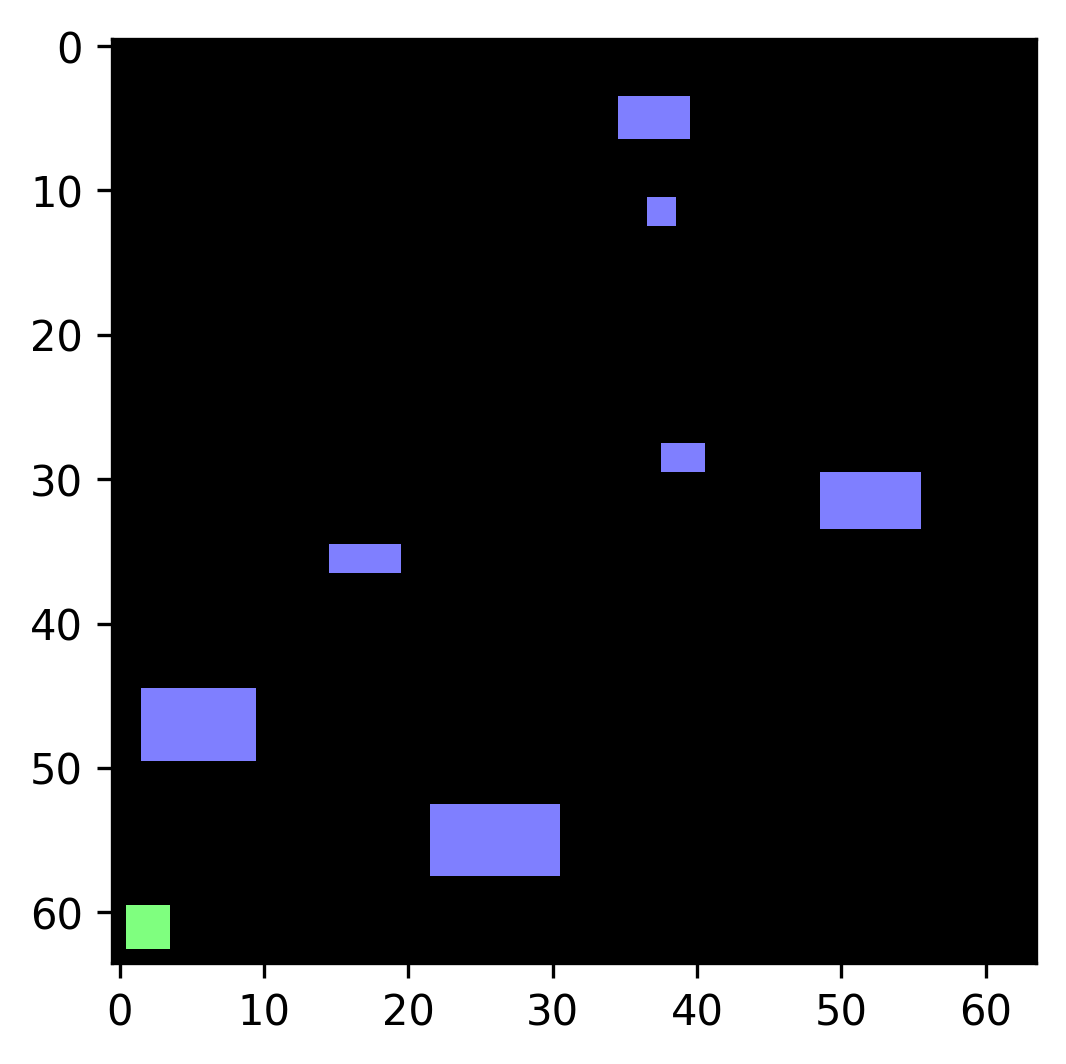

(3, 64, 64)


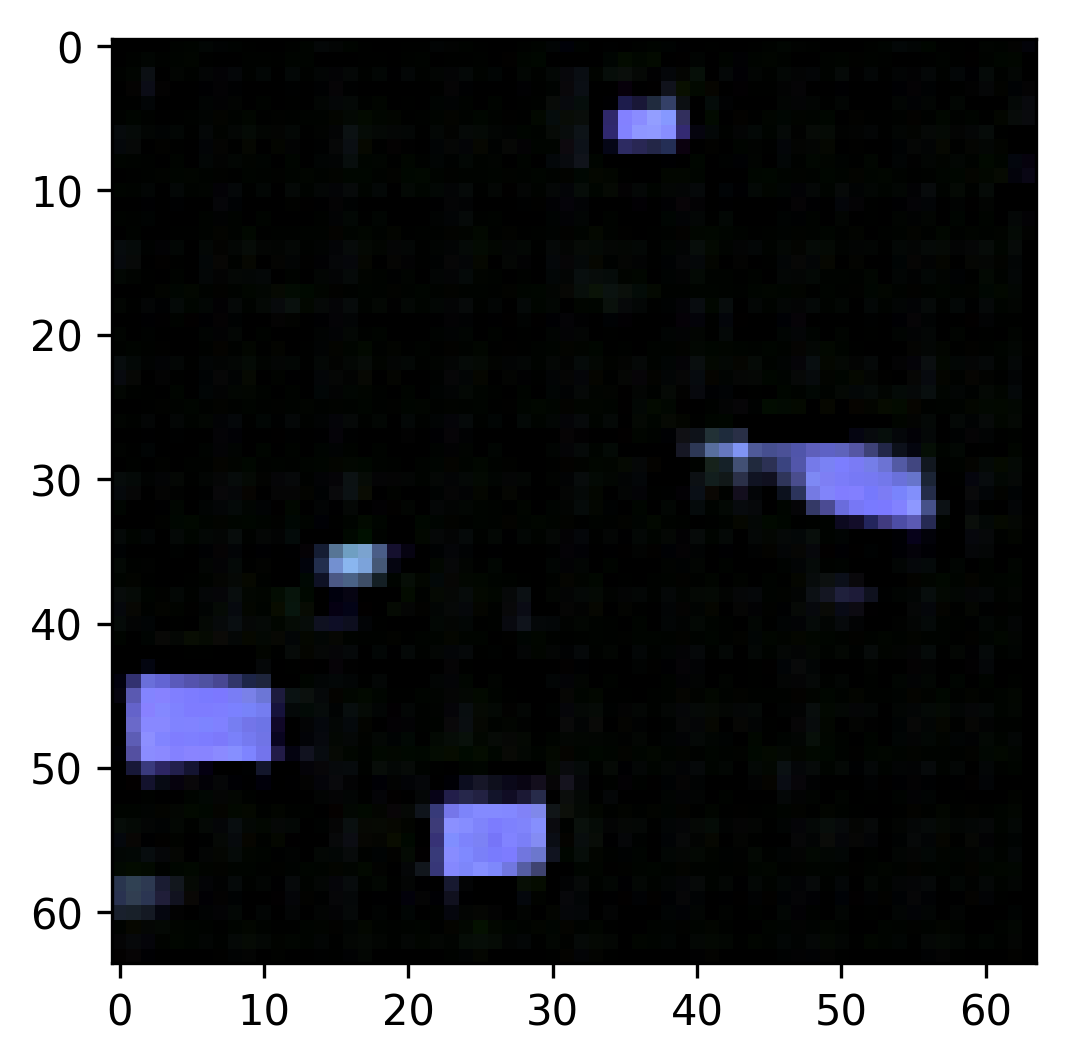

14
repr, std, cov, conv, closs 0.7095934152603149 0.4755859375 4.51807864010334e-05 0.0051460787653923035 0.2571752965450287
20.691601343582086 0.007000669940440706 1.0
repr, std, cov, conv, closs 0.6958990097045898 0.4755859375 4.3083680793643e-05 0.0046195099130272865 0.255281925201416
20.465353477343722 0.0069241226201070365 1.0
repr, std, cov, conv, closs 0.7098917961120605 0.4765625 3.784382715821266e-05 0.004644159227609634 0.249957874417305
20.54733776525583 0.007149163502810305 1.0
repr, std, cov, conv, closs 0.717896580696106 0.47705078125 3.275950439274311e-05 0.004450761713087559 0.25157099962234497
20.54733776525583 0.007278948123532052 1.0
repr, std, cov, conv, closs 0.6820115447044373 0.47607421875 3.9178645238280296e-05 0.0038863718509674072 0.24851179122924805
20.18097597871086 0.007278948123532052 1.0
repr, std, cov, conv, closs 0.70054030418396 0.476318359375 3.636605106294155e-05 0.00406295619904995 0.2491372972726822
20.18097597871086 0.007396288856773863 1.0
repr, 

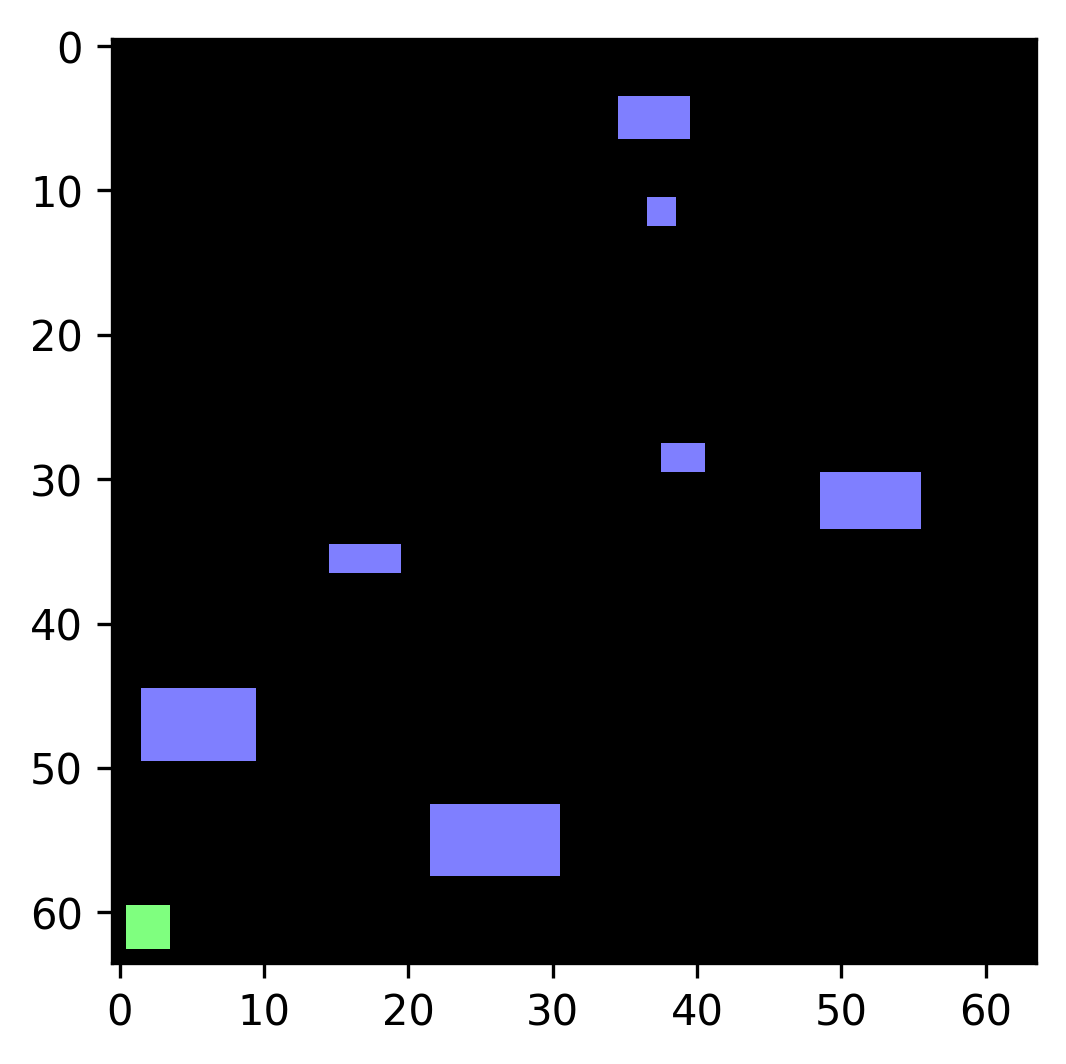

(3, 64, 64)


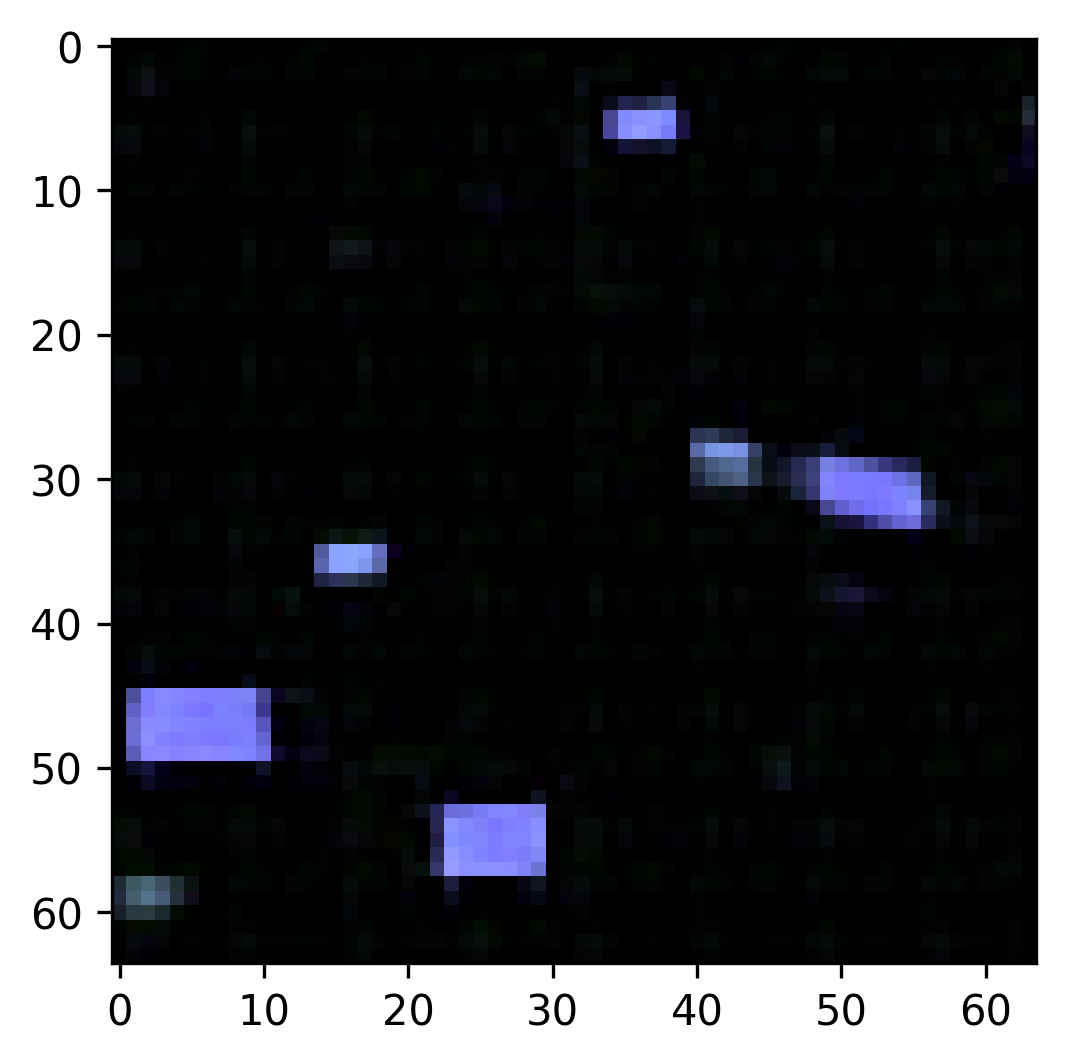

15
repr, std, cov, conv, closs 0.6732109785079956 0.476806640625 3.532273694872856e-05 0.004436630290001631 0.24923087656497955
20.26182104922565 0.007553174024907897 1.0
repr, std, cov, conv, closs 0.6907634139060974 0.476806640625 3.4093623980879784e-05 0.004375787451863289 0.2493094652891159
20.140674489058256 0.007530559746458725 1.0
repr, std, cov, conv, closs 0.6926534175872803 0.47607421875 3.962405025959015e-05 0.0044150035828351974 0.2507069706916809
19.980271747176978 0.007359418098469549 1.0
repr, std, cov, conv, closs 0.7074293494224548 0.475830078125 4.220288246870041e-05 0.004937576130032539 0.24911046028137207
19.86080858601789 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.6719037294387817 0.474853515625 4.9545662477612495e-05 0.004541766829788685 0.24907922744750977
19.235631403590716 0.007000669940440706 1.0
repr, std, cov, conv, closs 0.66391921043396 0.47509765625 4.799617454409599e-05 0.0042740884236991405 0.24620585143566132
18.89265751729697 0.00687584705

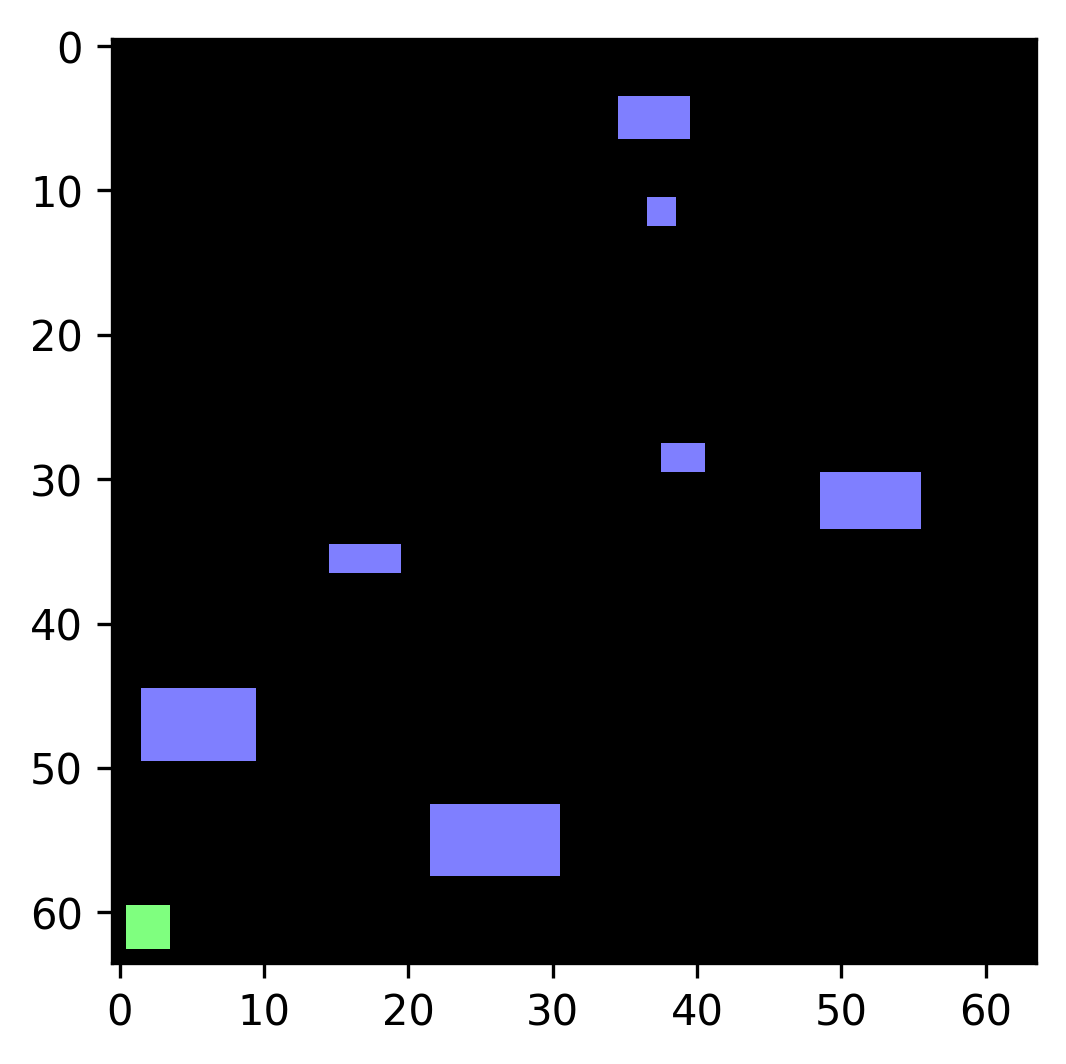

(3, 64, 64)


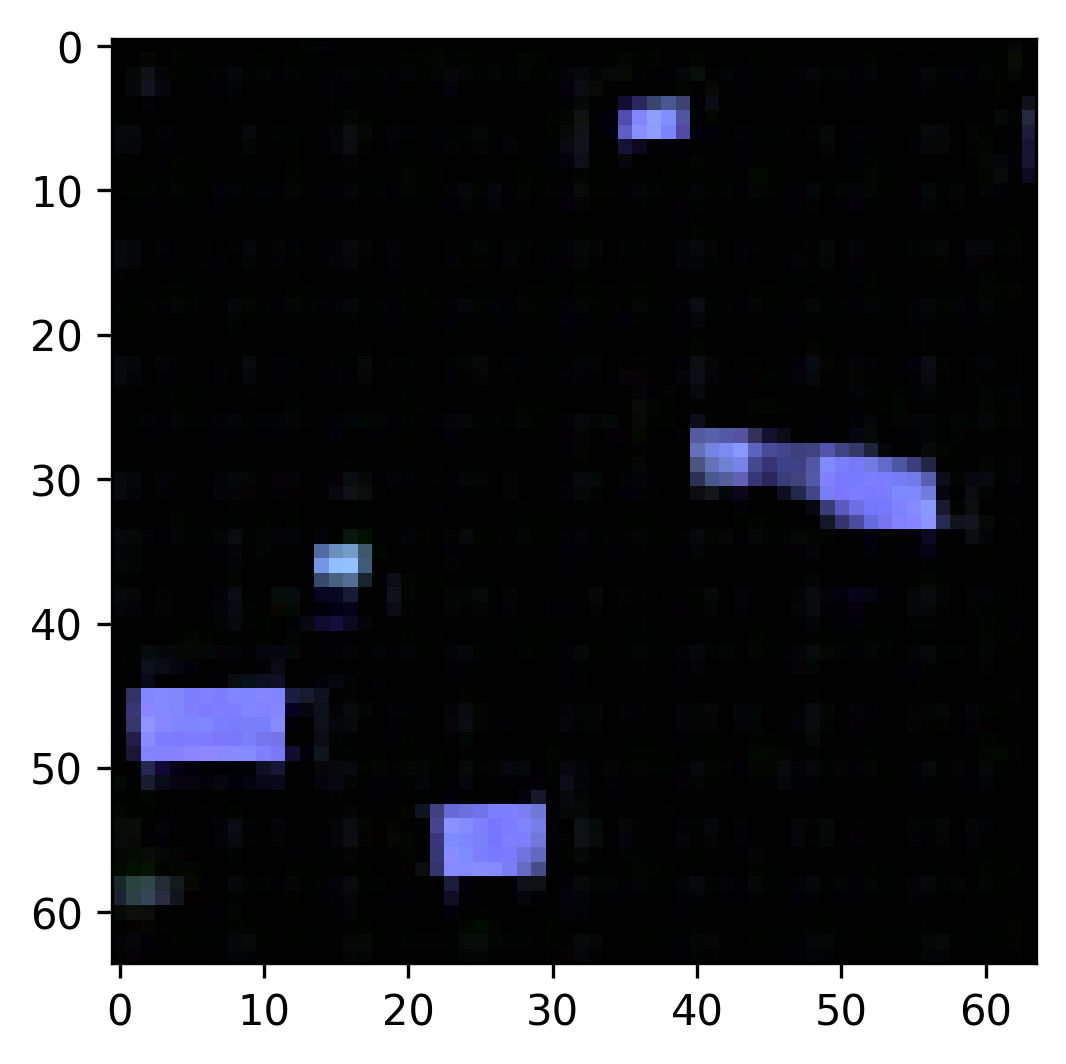

16
repr, std, cov, conv, closs 0.6646910309791565 0.474853515625 4.974985495209694e-05 0.00404360331594944 0.25064367055892944
19.86080858601789 0.006972737127609584 1.0
repr, std, cov, conv, closs 0.6876892447471619 0.47509765625 4.669441841542721e-05 0.004491062834858894 0.24996082484722137
19.50668770676195 0.006848412289990035 1.0
repr, std, cov, conv, closs 0.7078134417533875 0.475830078125 4.1489722207188606e-05 0.006477131973952055 0.2500001788139343
19.920450614062506 0.006787083631326324 1.0
repr, std, cov, conv, closs 0.6877479553222656 0.475830078125 4.135817289352417e-05 0.004595823120325804 0.2500002086162567
20.18097597871086 0.006834735983287479 1.0
repr, std, cov, conv, closs 0.699202299118042 0.47607421875 3.868620842695236e-05 0.0054151564836502075 0.2500002980232239
20.753738243108458 0.006944915767259338 1.0
repr, std, cov, conv, closs 0.7110391855239868 0.4765625 3.7014251574873924e-05 0.004863854497671127 0.25002676248550415
21.067232930612754 0.007070992511544726

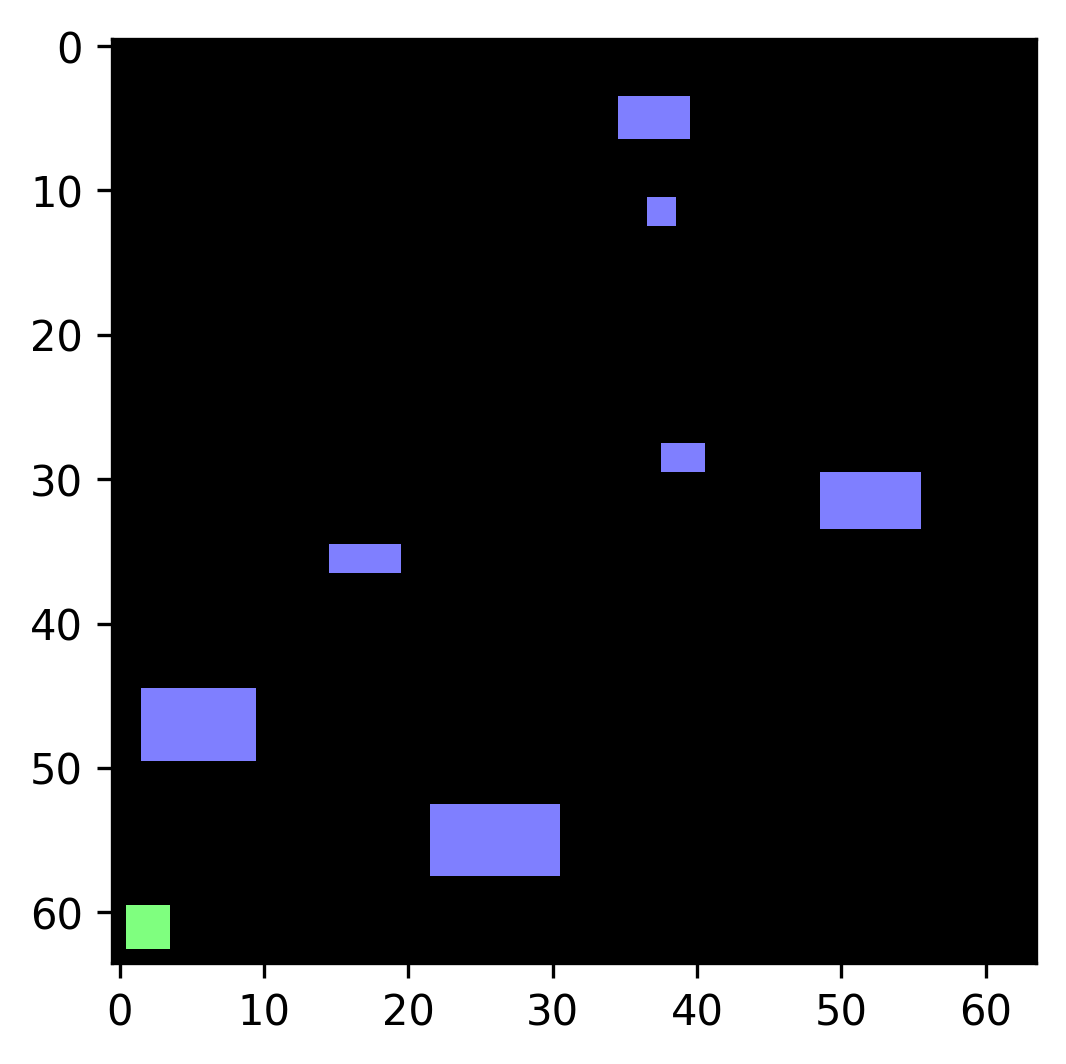

(3, 64, 64)


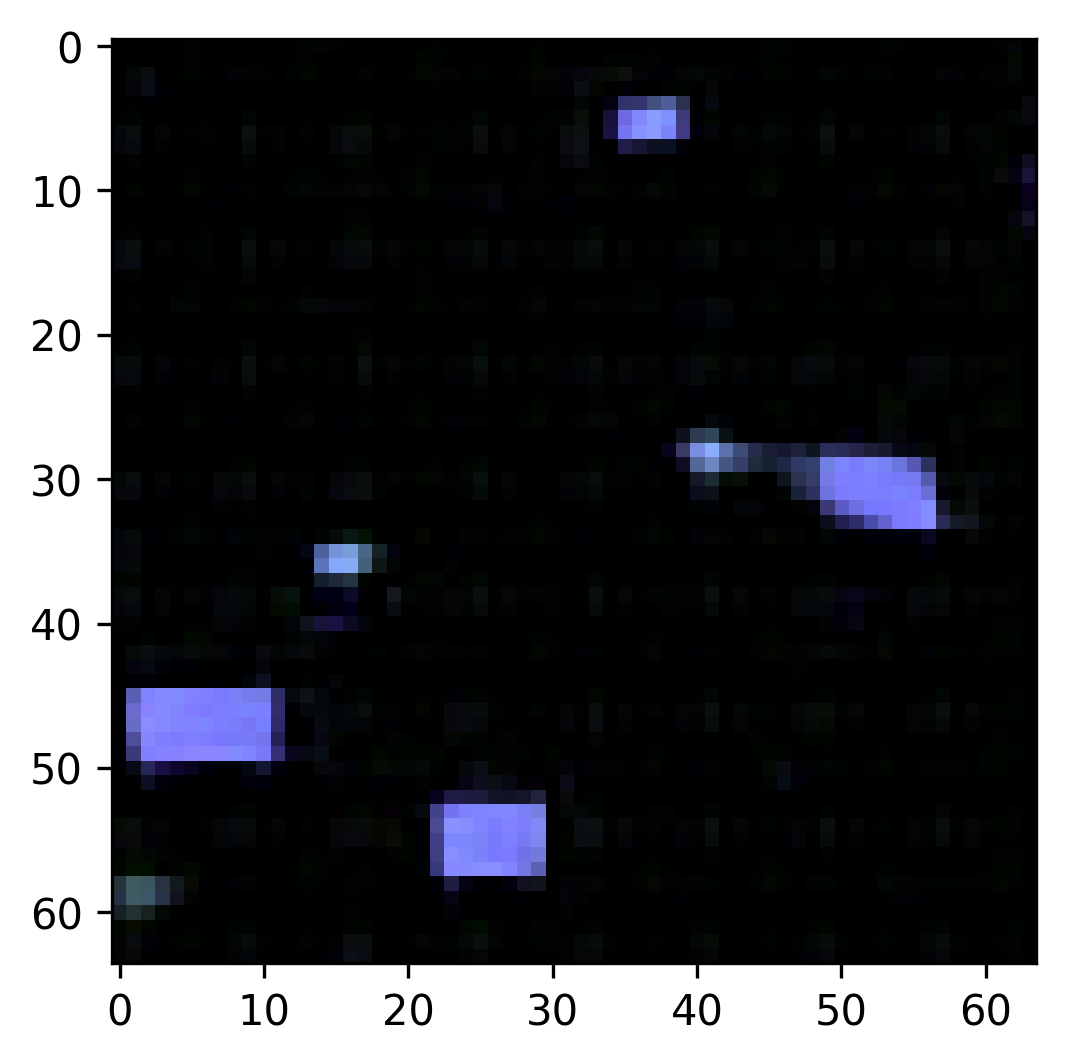

17
repr, std, cov, conv, closs 0.6550695896148682 0.476806640625 3.4059397876262665e-05 0.004252925515174866 0.25518837571144104
20.609041441112225 0.007092226709127884 1.0
repr, std, cov, conv, closs 0.6550804376602173 0.47705078125 3.368291072547436e-05 0.004002435132861137 0.2481543868780136
20.609041441112225 0.0072209777095987755 1.0
repr, std, cov, conv, closs 0.6652238965034485 0.476806640625 3.550364635884762e-05 0.00418516993522644 0.25080743432044983
20.92035041738738 0.007440777682284119 1.0
repr, std, cov, conv, closs 0.6692932844161987 0.4765625 3.6472221836447716e-05 0.0041012451983988285 0.24991261959075928
20.567885103021084 0.007359418098469549 1.0
repr, std, cov, conv, closs 0.6656093597412109 0.47607421875 4.0677376091480255e-05 0.004332934971898794 0.2524891197681427
20.650280133035885 0.0073154157264568274 1.0
repr, std, cov, conv, closs 0.6750725507736206 0.475830078125 4.184246063232422e-05 0.0035584107972681522 0.24904876947402954
20.282082870274873 0.0071849808

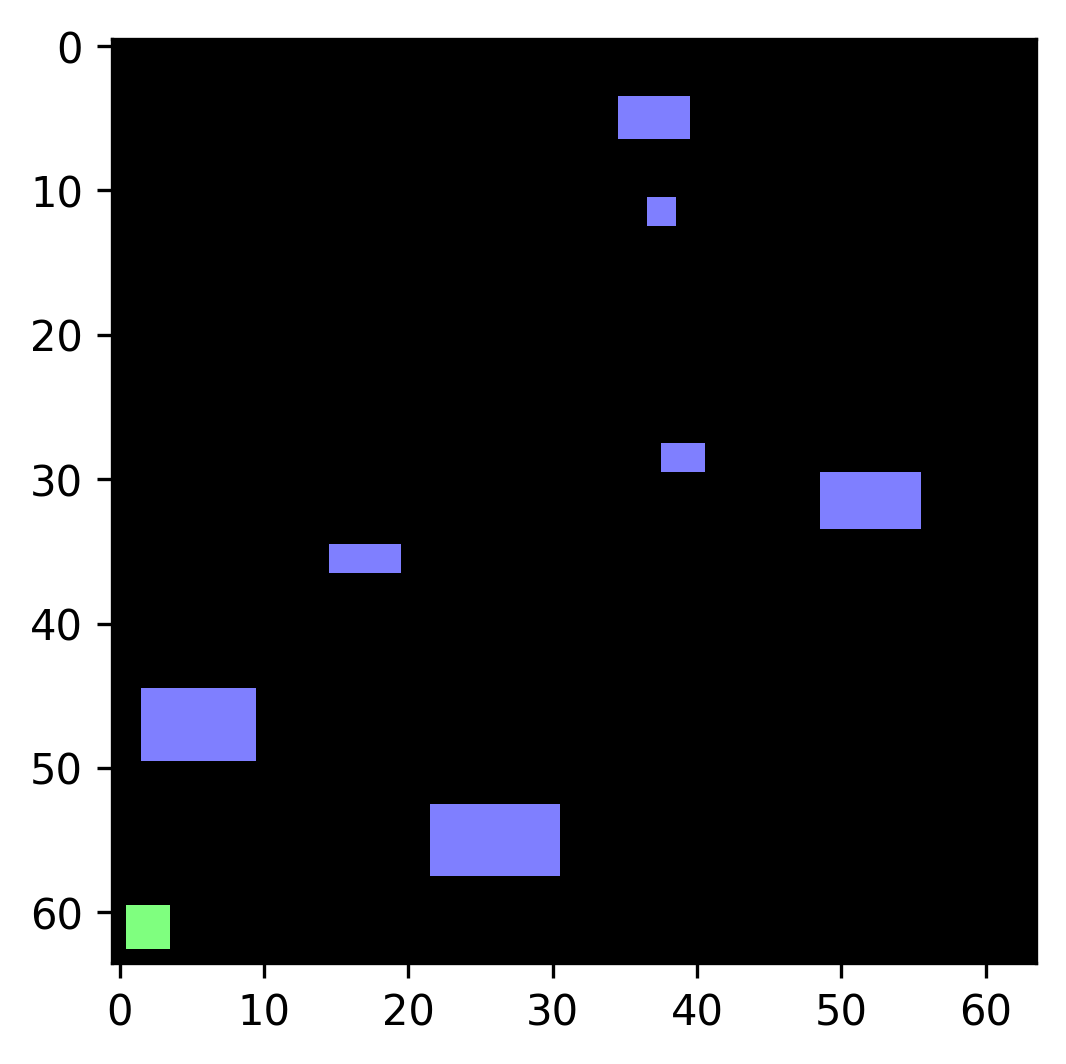

(3, 64, 64)


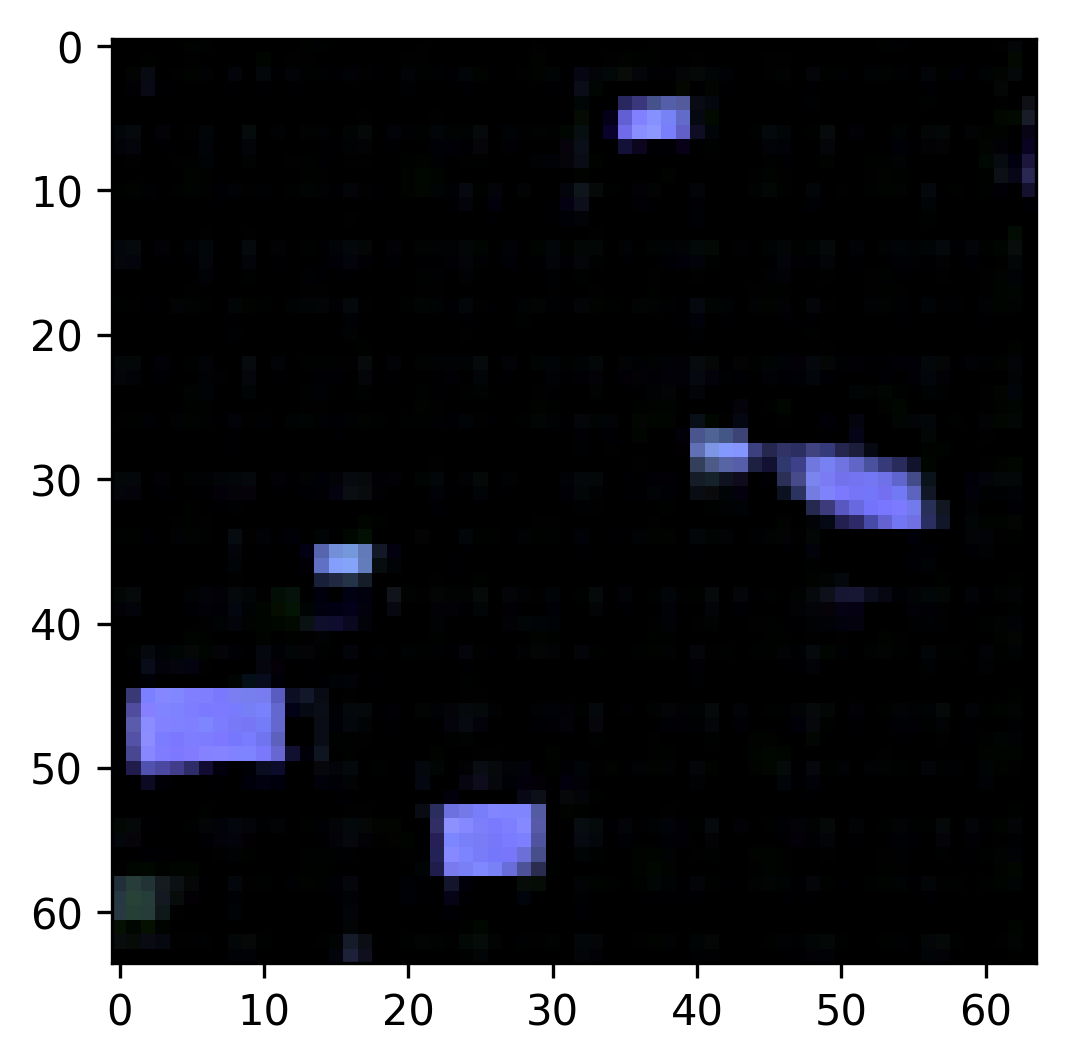

18
repr, std, cov, conv, closs 0.6790927648544312 0.475830078125 4.0920451283454895e-05 0.0042612506076693535 0.2504253685474396
21.257598219678442 0.006868978078945285 1.0
repr, std, cov, conv, closs 0.7076322436332703 0.47607421875 3.8358382880687714e-05 0.004744594916701317 0.24974720180034637
21.514097087008032 0.006896495232612317 1.0
repr, std, cov, conv, closs 0.6791971921920776 0.4755859375 4.2197294533252716e-05 0.004648301284760237 0.2628564238548279
20.983174250611135 0.0066860872323651465 1.0
repr, std, cov, conv, closs 0.6835262775421143 0.475341796875 4.4111860916018486e-05 0.00422356091439724 0.24892140924930573
20.774491981351563 0.006606373275742532 1.0
repr, std, cov, conv, closs 0.6616551876068115 0.4755859375 4.3522100895643234e-05 0.0038273665122687817 0.2492736130952835
20.609041441112225 0.006632838433517254 1.0
repr, std, cov, conv, closs 0.6721652746200562 0.47607421875 4.006316885352135e-05 0.004252973478287458 0.2502674460411072
20.691601343582086 0.006733030

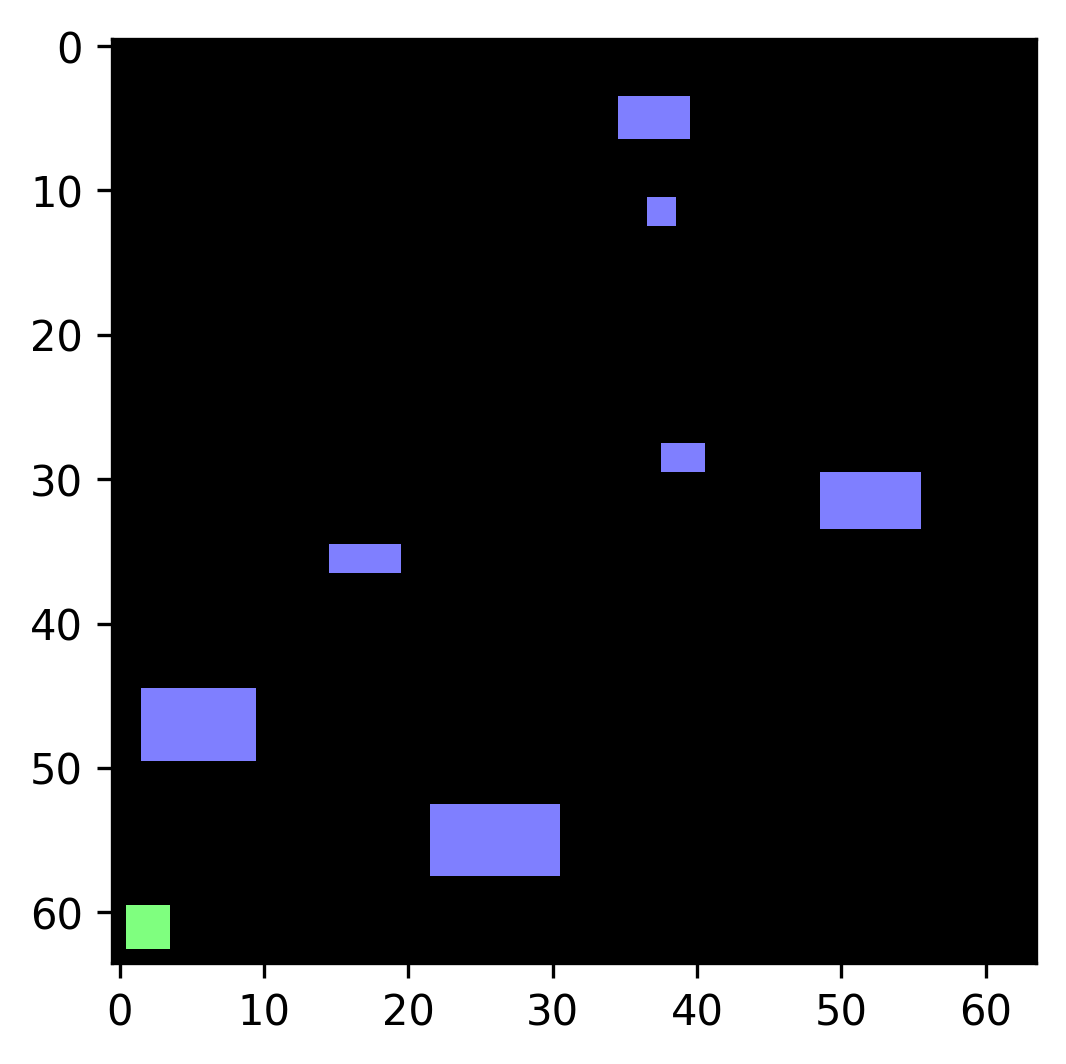

(3, 64, 64)


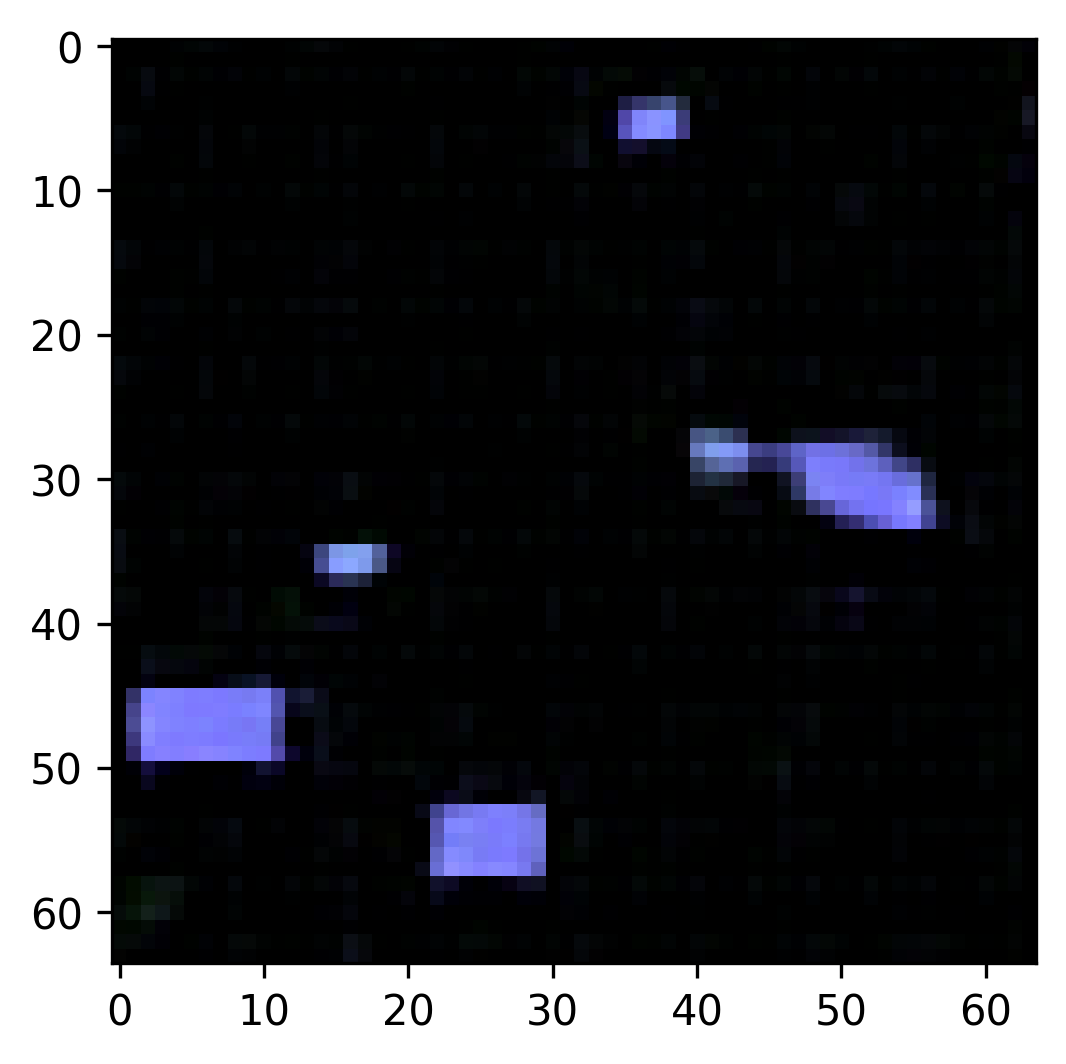

19
repr, std, cov, conv, closs 0.6834231615066528 0.4765625 3.594369627535343e-05 0.004277029074728489 0.2493777722120285
21.643504811591153 0.007206557388264859 1.0
repr, std, cov, conv, closs 0.7041396498680115 0.476806640625 3.4140655770897865e-05 0.005162721499800682 0.24779018759727478
21.90466011294954 0.00733738392719879 1.0
repr, std, cov, conv, closs 0.6611435413360596 0.4765625 3.7828925997018814e-05 0.004450901411473751 0.25203874707221985
21.665148316402743 0.007388899956817047 1.0
repr, std, cov, conv, closs 0.6934108734130859 0.476806640625 3.419071435928345e-05 0.0049062324687838554 0.2497568428516388
21.57870394207441 0.007455666678426368 1.0
repr, std, cov, conv, closs 0.6912532448768616 0.475341796875 4.4125132262706757e-05 0.004582776688039303 0.24882066249847412
21.172779978372798 0.0072209777095987755 1.0
repr, std, cov, conv, closs 0.6975958347320557 0.475830078125 4.124571569263935e-05 0.004526208620518446 0.24877838790416718
21.15162835002278 0.00709222670912788

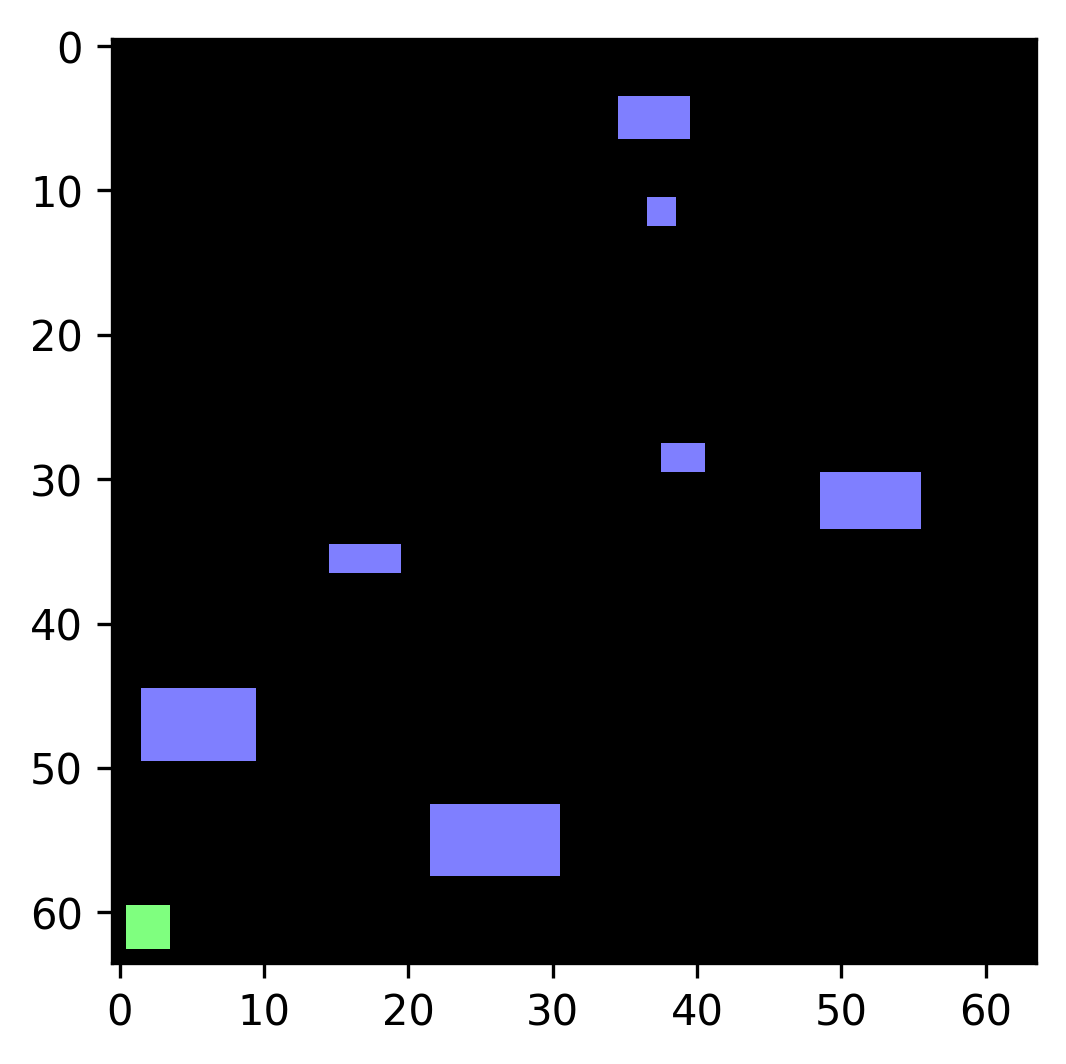

(3, 64, 64)


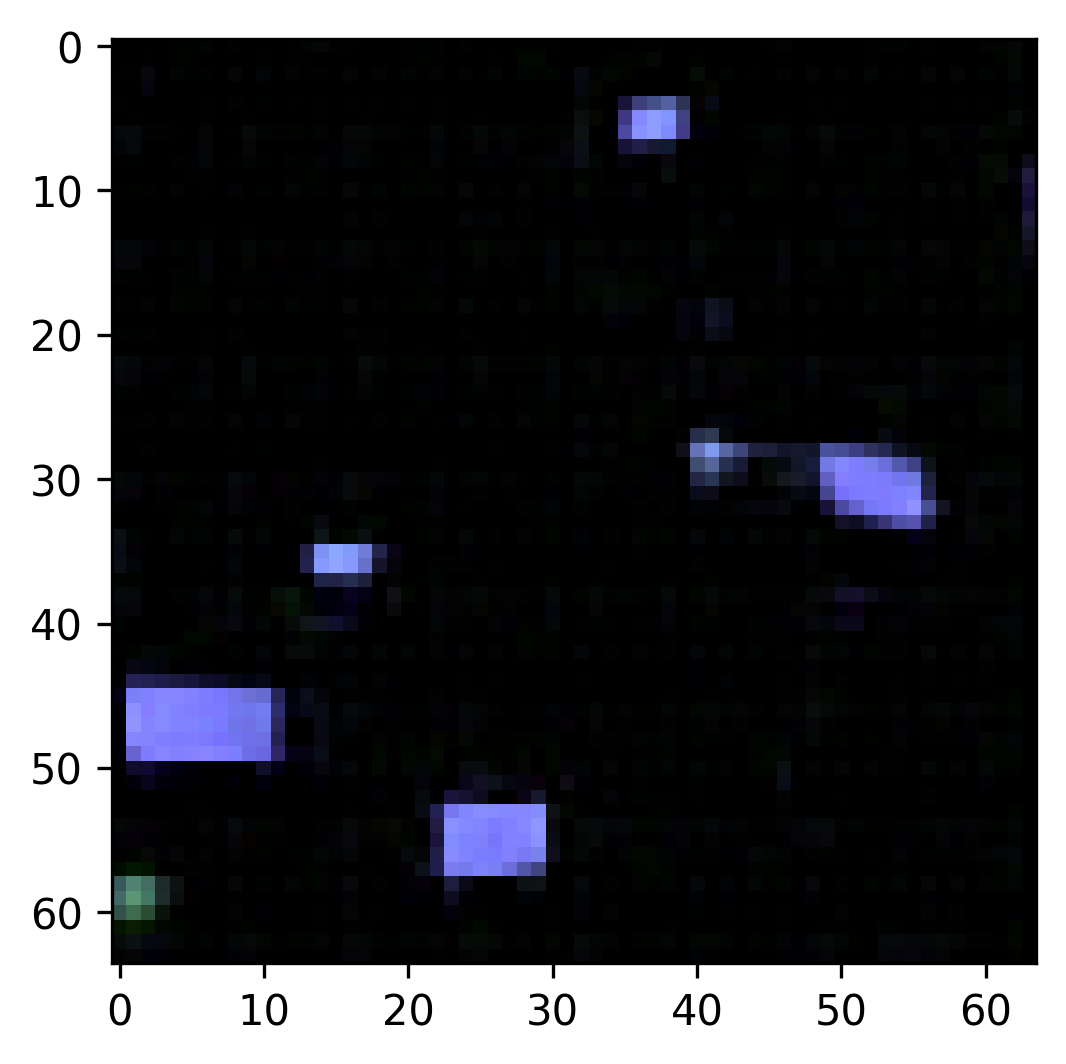

20
repr, std, cov, conv, closs 0.6978862881660461 0.47509765625 4.756939597427845e-05 0.004071662202477455 0.24497994780540466
23.35164487708846 0.00675324978235048 1.0
repr, std, cov, conv, closs 0.7118499875068665 0.47509765625 4.749489016830921e-05 0.003977555315941572 0.2538762092590332
22.95821720076558 0.00663947127195077 1.0
repr, std, cov, conv, closs 0.7165683507919312 0.4755859375 4.239799454808235e-05 0.004256811924278736 0.26150375604629517
22.981175417966345 0.0065997735022402925 1.0
repr, std, cov, conv, closs 0.7135076522827148 0.47607421875 3.9065489545464516e-05 0.003920326940715313 0.2498243749141693
22.981175417966345 0.006652756853965942 1.0
repr, std, cov, conv, closs 0.7359522581100464 0.4765625 3.6395853385329247e-05 0.005637499503791332 0.24747595191001892
23.586214956985906 0.006855260702280024 1.0
repr, std, cov, conv, closs 0.7713748216629028 0.47705078125 3.2817479223012924e-05 0.00562165817245841 0.2507496476173401
24.014394835827765 0.006979709864737193 1.

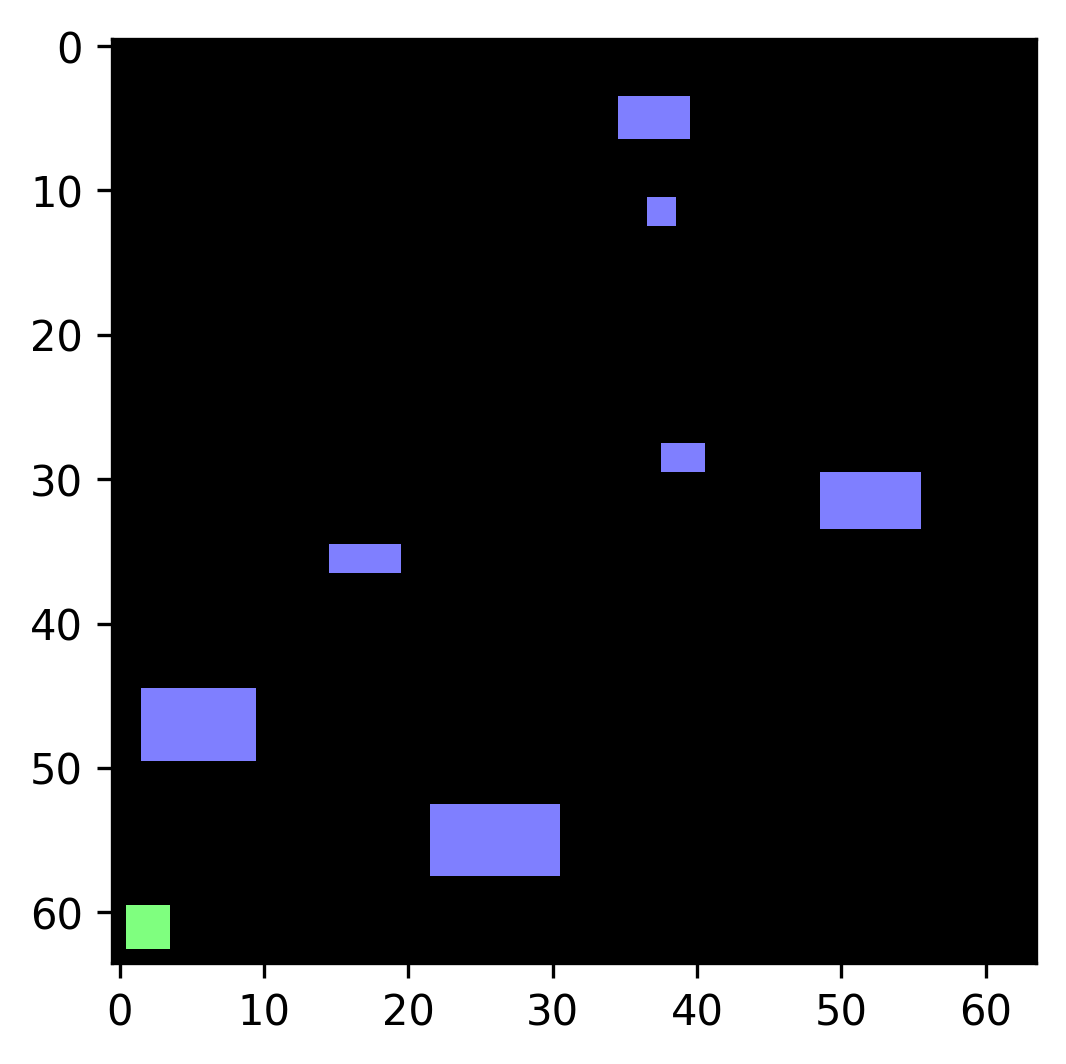

(3, 64, 64)


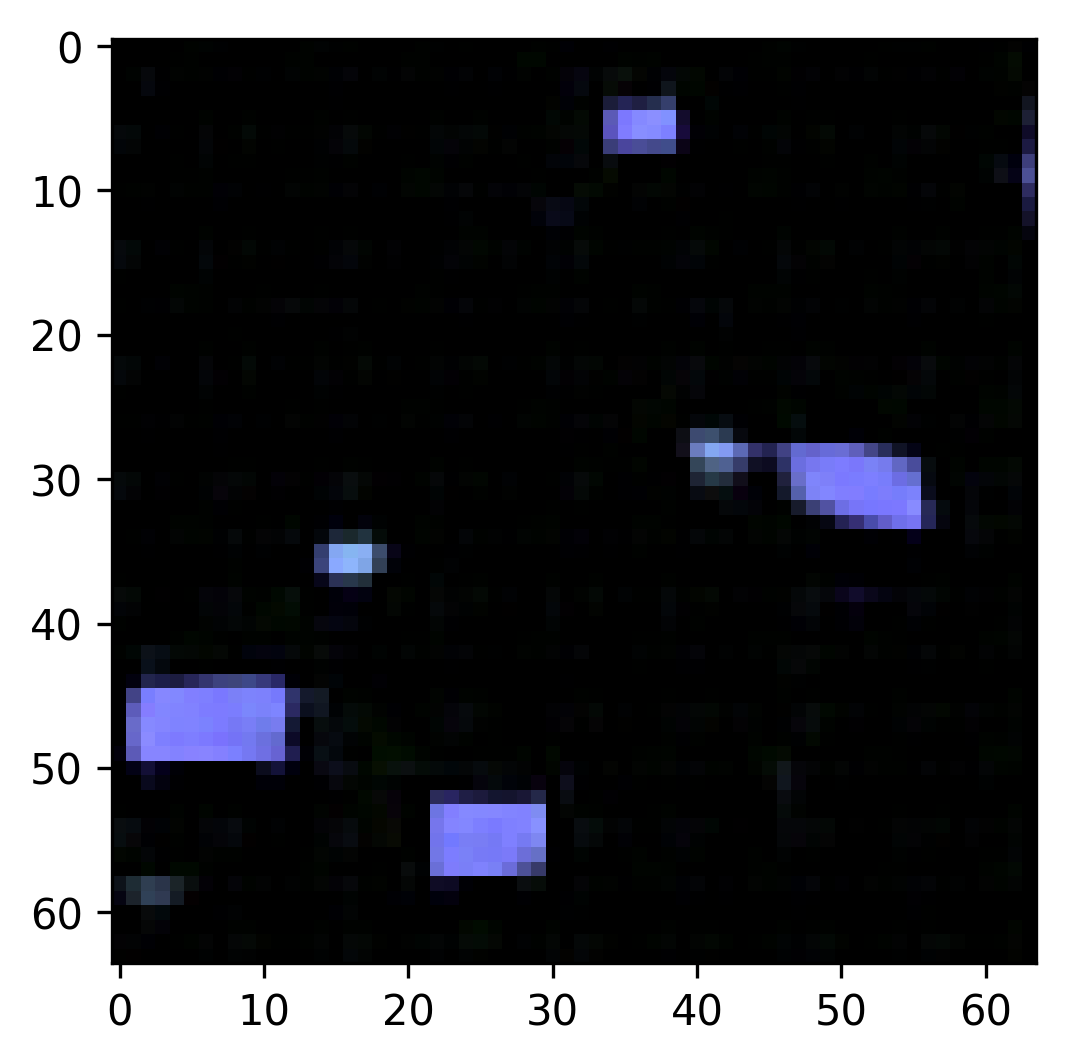

21
repr, std, cov, conv, closs 0.7132889032363892 0.476318359375 3.7370715290308e-05 0.00448611518368125 0.2520502209663391
24.014394835827765 0.007448218459966402 1.0
repr, std, cov, conv, closs 0.7071896195411682 0.47607421875 3.879517316818237e-05 0.004741314332932234 0.25120341777801514
23.586214956985906 0.00733738392719879 1.0
repr, std, cov, conv, closs 0.7027462720870972 0.475830078125 4.236120730638504e-05 0.005051931366324425 0.2491225302219391
22.843769686086365 0.0071064182547728475 1.0
repr, std, cov, conv, closs 0.7172084450721741 0.475341796875 4.363548941910267e-05 0.004256530664861202 0.25003328919410706
22.59398939781879 0.006979709864737193 1.0
repr, std, cov, conv, closs 0.6938785314559937 0.475341796875 4.465482197701931e-05 0.0043791807256639 0.25133487582206726
21.90466011294954 0.00676000303213283 1.0
repr, std, cov, conv, closs 0.6715738773345947 0.47509765625 4.7282082960009575e-05 0.0044252146035432816 0.2500172257423401
21.60028264601648 0.006666069020430727

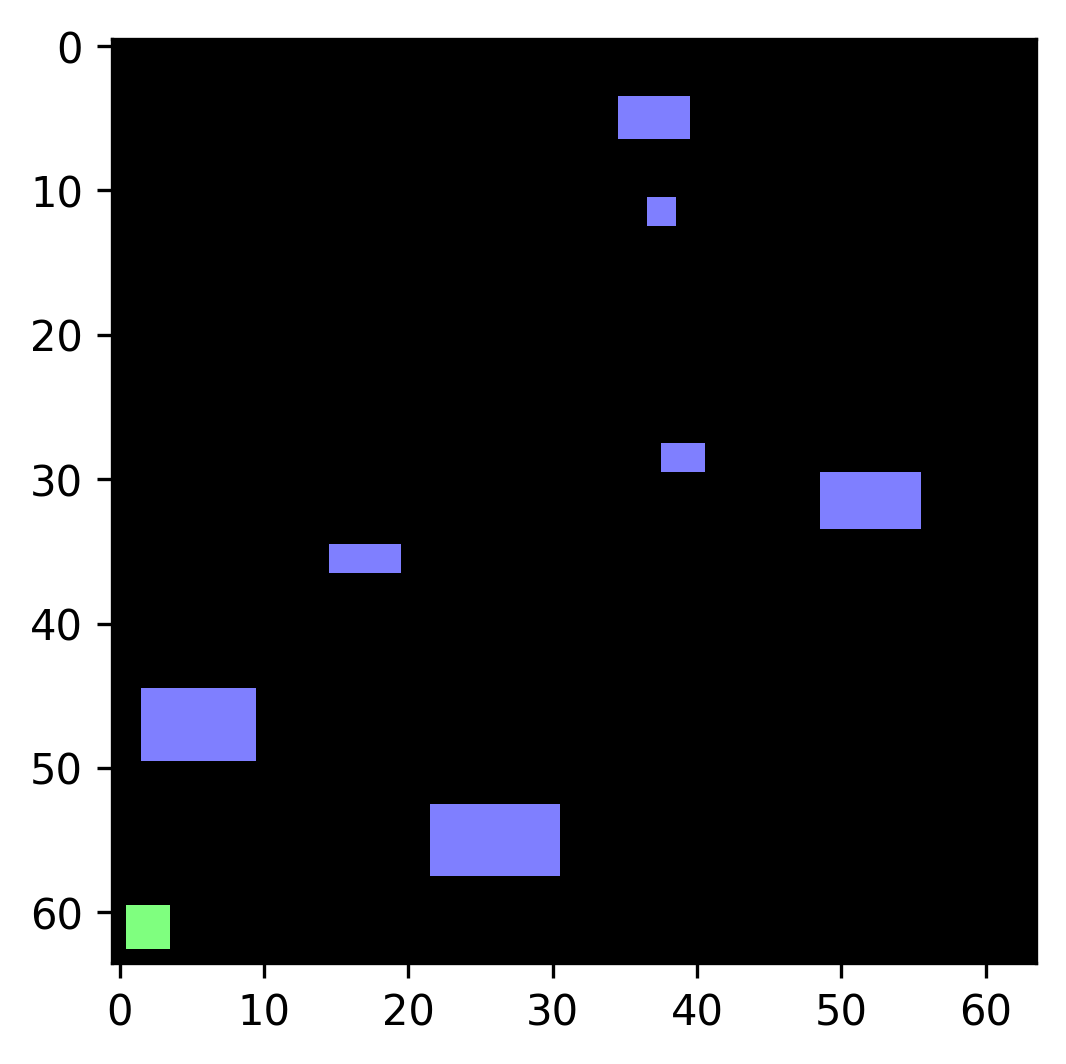

(3, 64, 64)


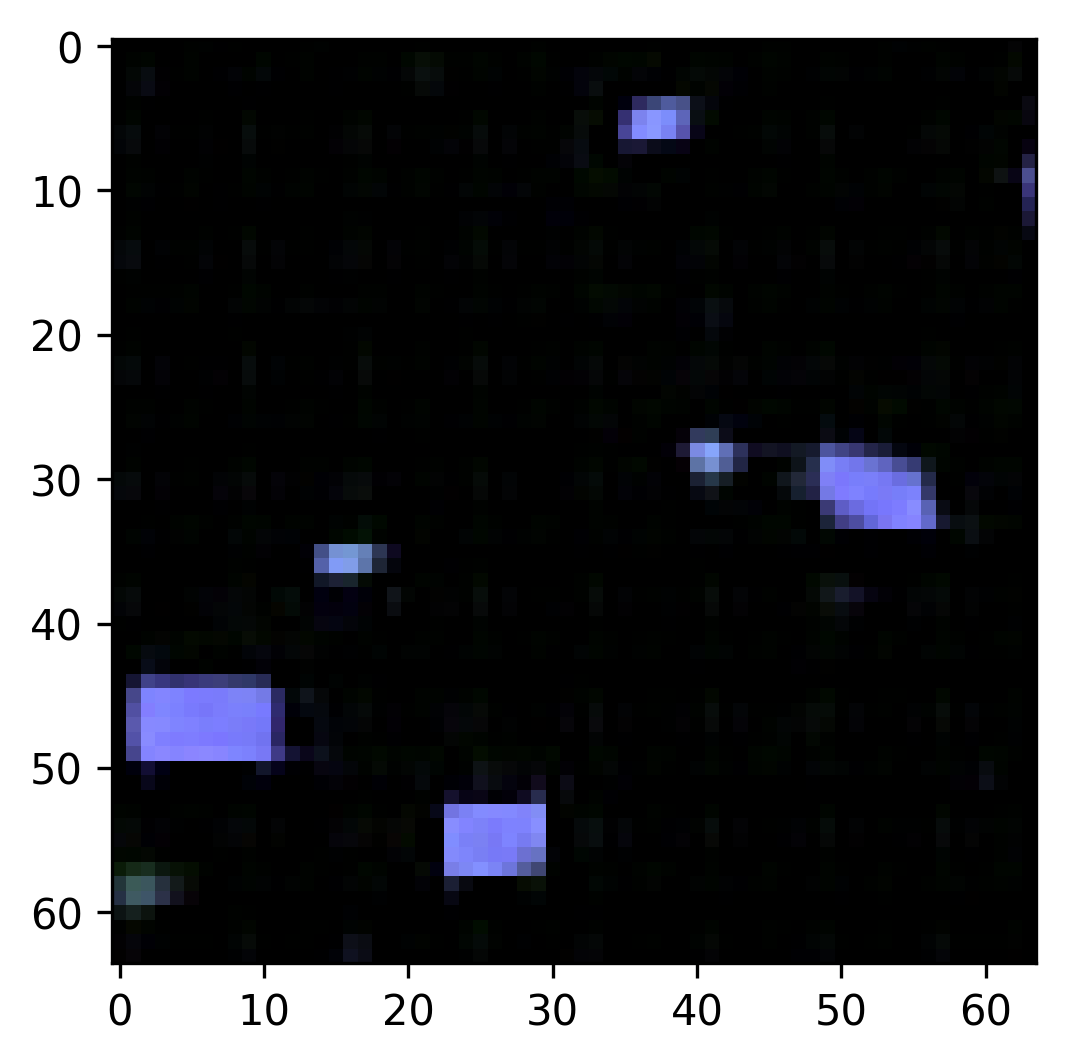

22
repr, std, cov, conv, closs 0.7055904865264893 0.476806640625 3.5114819183945656e-05 0.0053577423095703125 0.23995369672775269
20.85771467934759 0.006679407824540607 1.0
repr, std, cov, conv, closs 0.6905779838562012 0.4765625 3.603193908929825e-05 0.004148157779127359 0.24453145265579224
21.109388463706907 0.0068006645856726064 1.0
repr, std, cov, conv, closs 0.6833832859992981 0.476318359375 3.78582626581192e-05 0.004438246600329876 0.26396316289901733
21.449683665510825 0.007014678280991527 1.0
repr, std, cov, conv, closs 0.6771612167358398 0.476806640625 3.4472206607460976e-05 0.004201236646622419 0.24964232742786407
21.60028264601648 0.007142021481328977 1.0
repr, std, cov, conv, closs 0.6980793476104736 0.4775390625 3.097672015428543e-05 0.005042948294430971 0.2397564947605133
22.124695056948816 0.007359418098469549 1.0
repr, std, cov, conv, closs 0.7295247316360474 0.476806640625 3.4908996894955635e-05 0.0056116897612810135 0.24785873293876648
22.52634276796027 0.007493019643

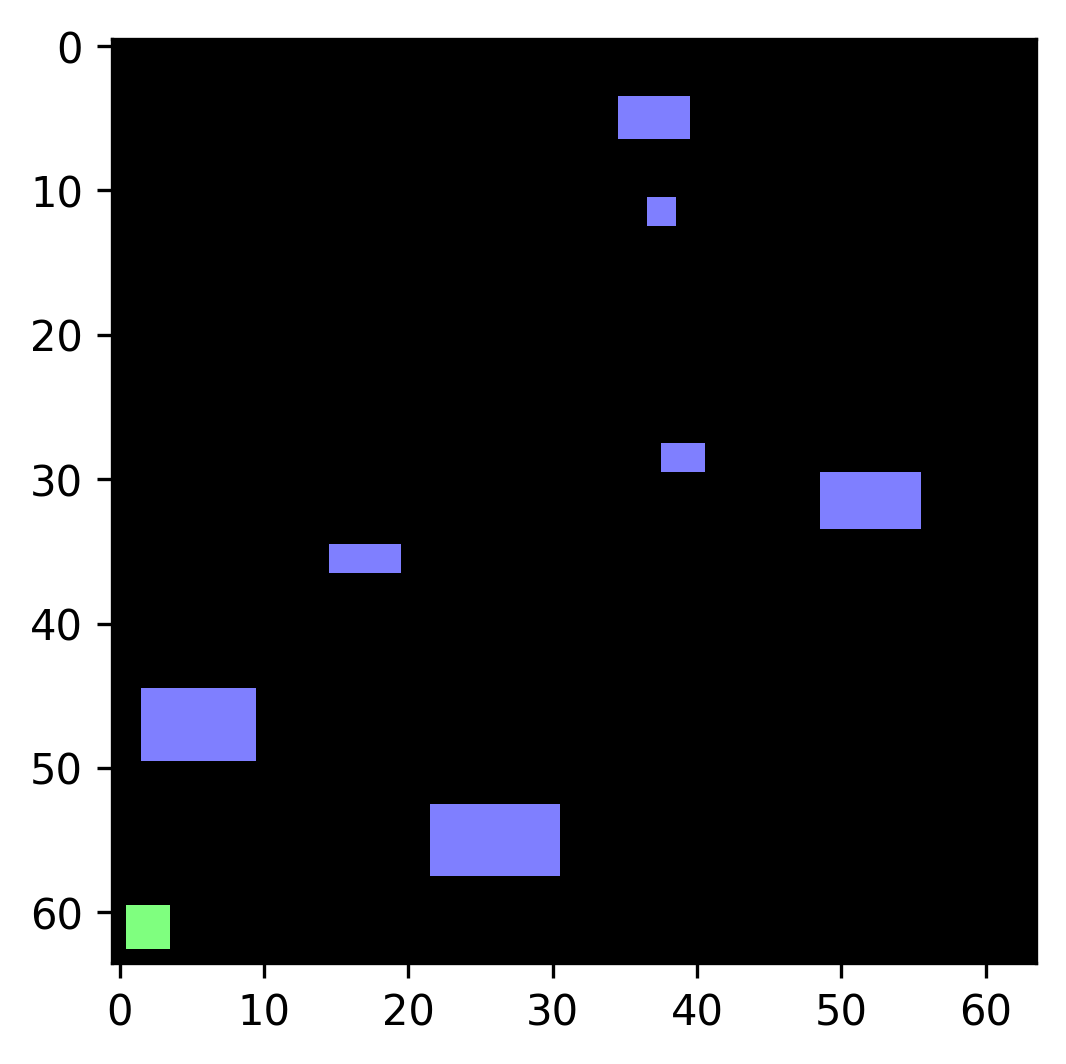

(3, 64, 64)


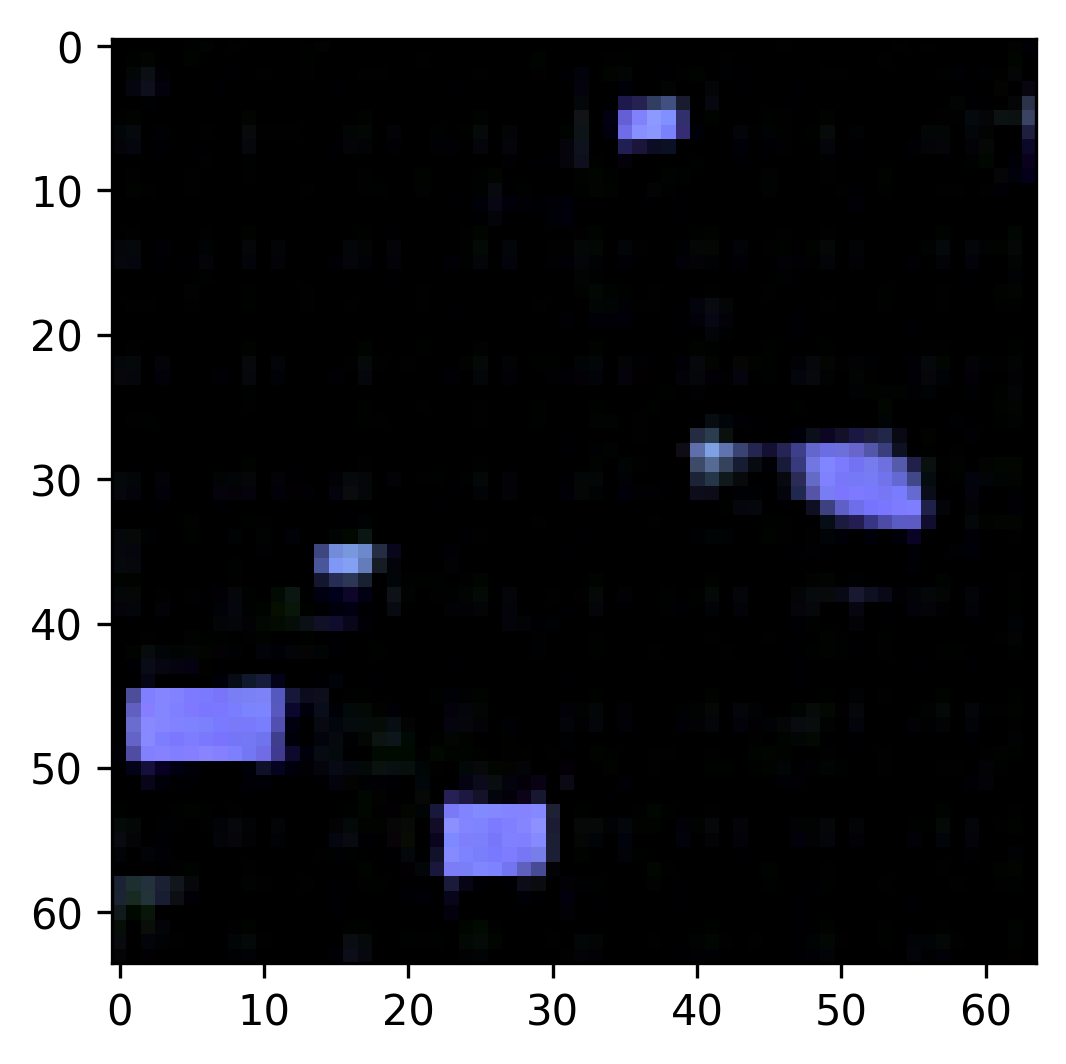

23
repr, std, cov, conv, closs 0.6782717704772949 0.477294921875 3.1958334147930145e-05 0.004845255985856056 0.250113308429718
21.7519389872405 0.007721100323994545 1.0
repr, std, cov, conv, closs 0.6919393539428711 0.4765625 3.714044578373432e-05 0.004527884069830179 0.2499569207429886
21.70850027818386 0.0077675428969812355 1.0
repr, std, cov, conv, closs 0.6557314395904541 0.4755859375 4.22443263232708e-05 0.004296755418181419 0.249654158949852
21.025161582286604 0.007530559746458725 1.0
repr, std, cov, conv, closs 0.6589380502700806 0.475341796875 4.501710645854473e-05 0.004516704939305782 0.25089216232299805
20.650280133035885 0.007396288856773863 1.0
repr, std, cov, conv, closs 0.6596176028251648 0.475341796875 4.59146685898304e-05 0.004431241191923618 0.25062060356140137
20.241579469755894 0.007163468978979427 1.0
repr, std, cov, conv, closs 0.6679682731628418 0.475830078125 4.112091846764088e-05 0.004018113017082214 0.24874134361743927
20.06031279573723 0.00707806350405627 1.0


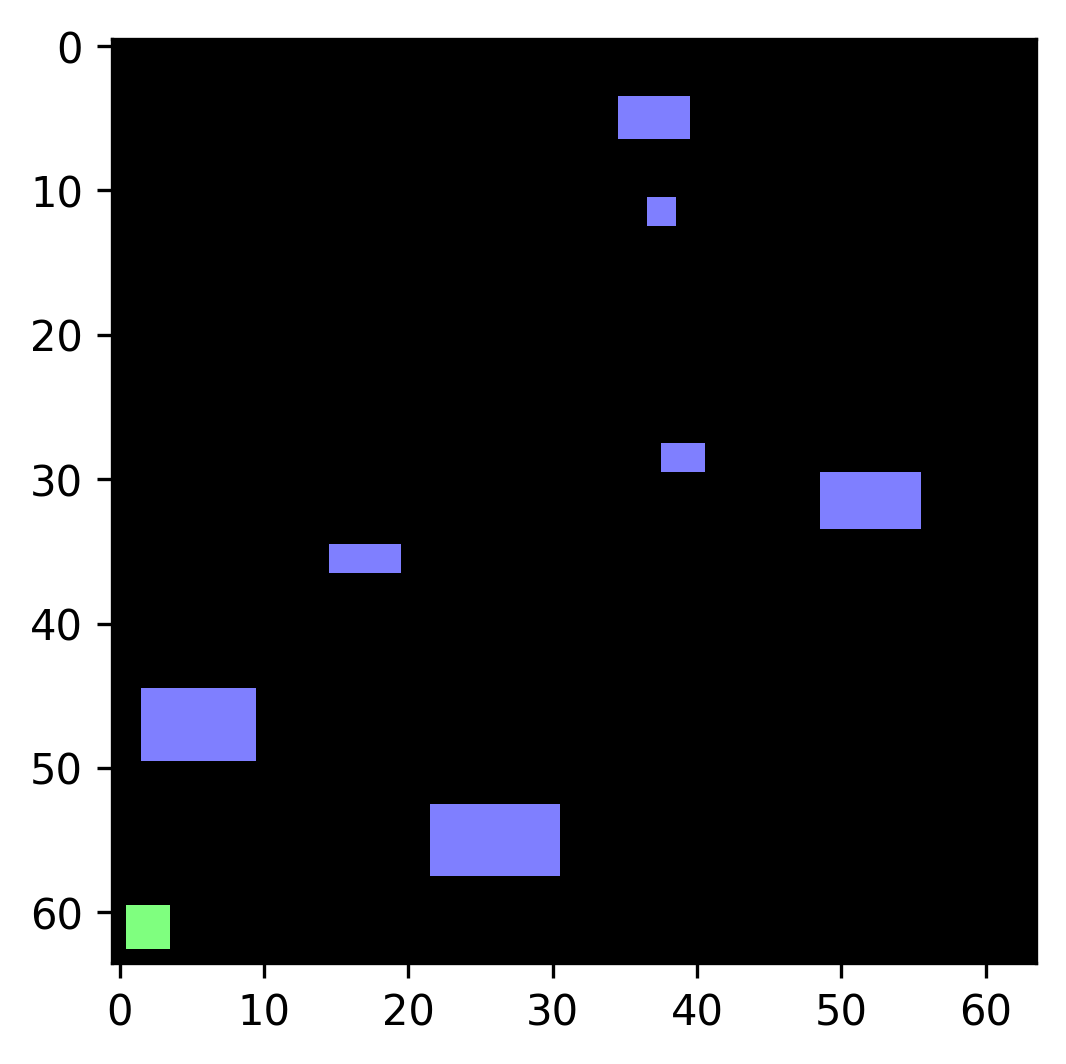

(3, 64, 64)


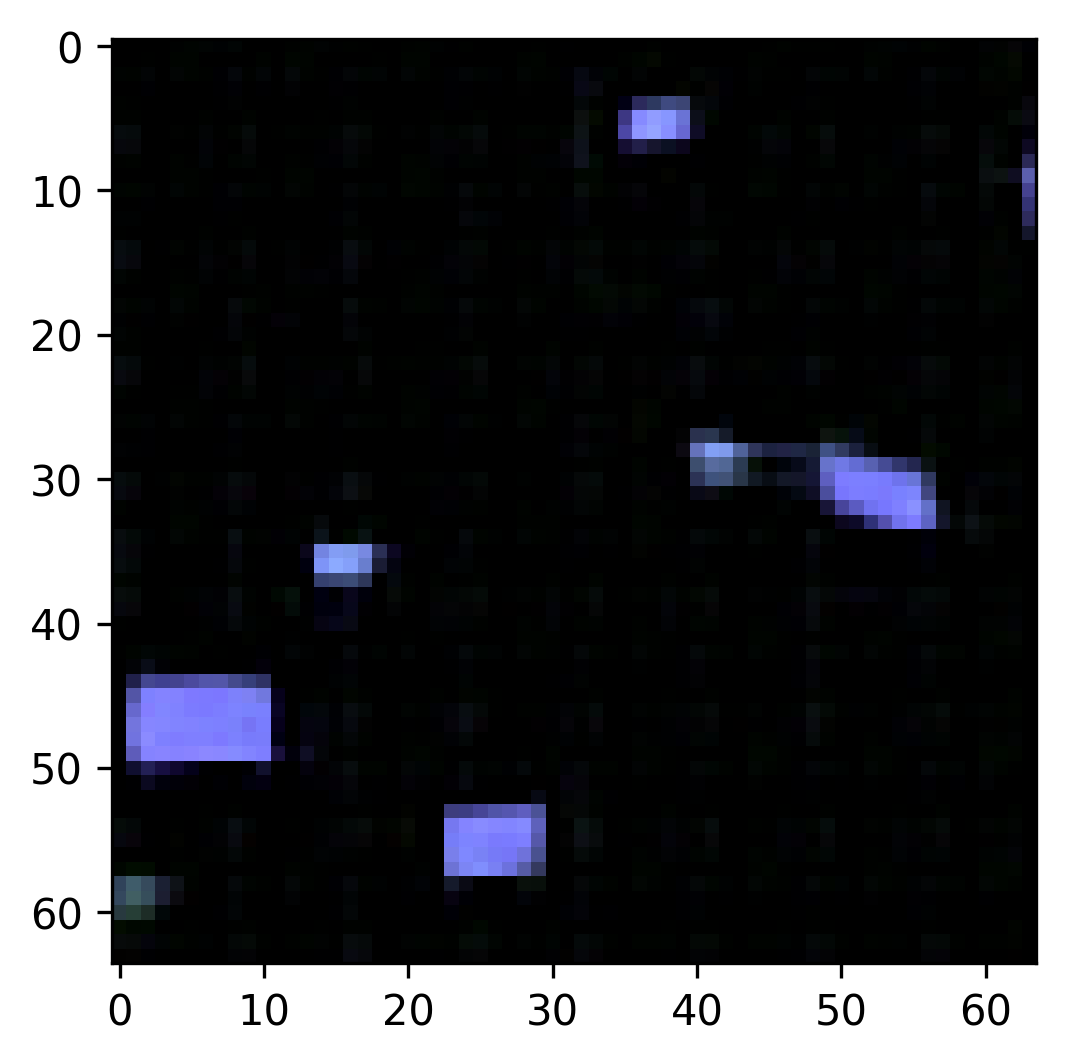

24
repr, std, cov, conv, closs 0.7853493094444275 0.475341796875 4.465342499315739e-05 0.005153604783117771 0.2497614473104477
25.396857706468968 0.006951860683026597 1.0
repr, std, cov, conv, closs 0.7719305753707886 0.475341796875 4.49642539024353e-05 0.004631701856851578 0.2503446936607361
25.2702534836868 0.0068279080752122676 1.0
repr, std, cov, conv, closs 0.782121479511261 0.475341796875 4.517217166721821e-05 0.0047068423591554165 0.2537679374217987
25.396857706468968 0.006706165559010024 1.0
repr, std, cov, conv, closs 0.786731481552124 0.475830078125 4.150322638452053e-05 0.00428796699270606 0.25229522585868835
25.32081926090765 0.0066195926286672915 1.0
repr, std, cov, conv, closs 0.7641738653182983 0.47607421875 3.9703212678432465e-05 0.004743258468806744 0.24813342094421387
25.703301791455463 0.006606373275742532 1.0
repr, std, cov, conv, closs 0.7738274335861206 0.476318359375 3.7753721699118614e-05 0.004280881490558386 0.25321412086486816
25.93555898876223 0.0067061655590

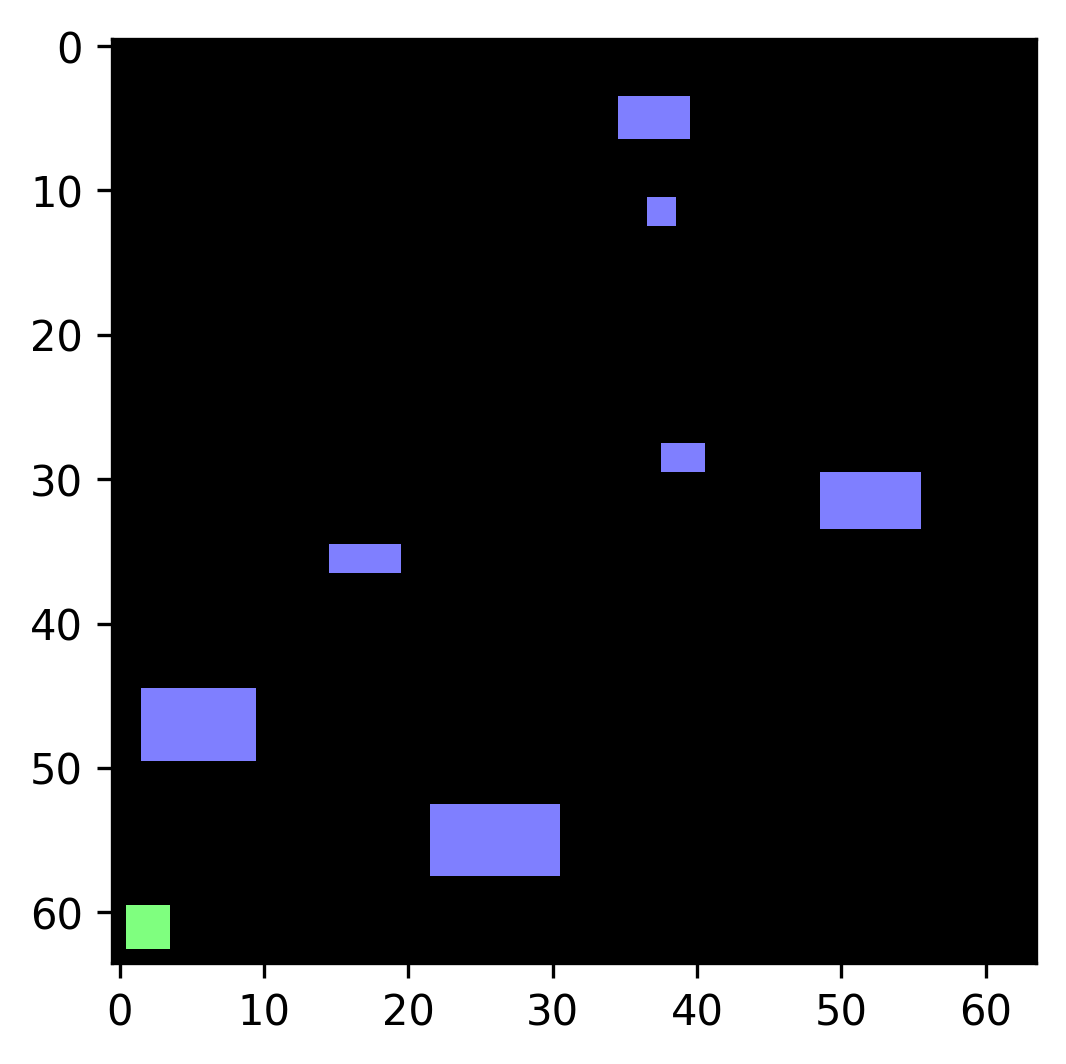

(3, 64, 64)


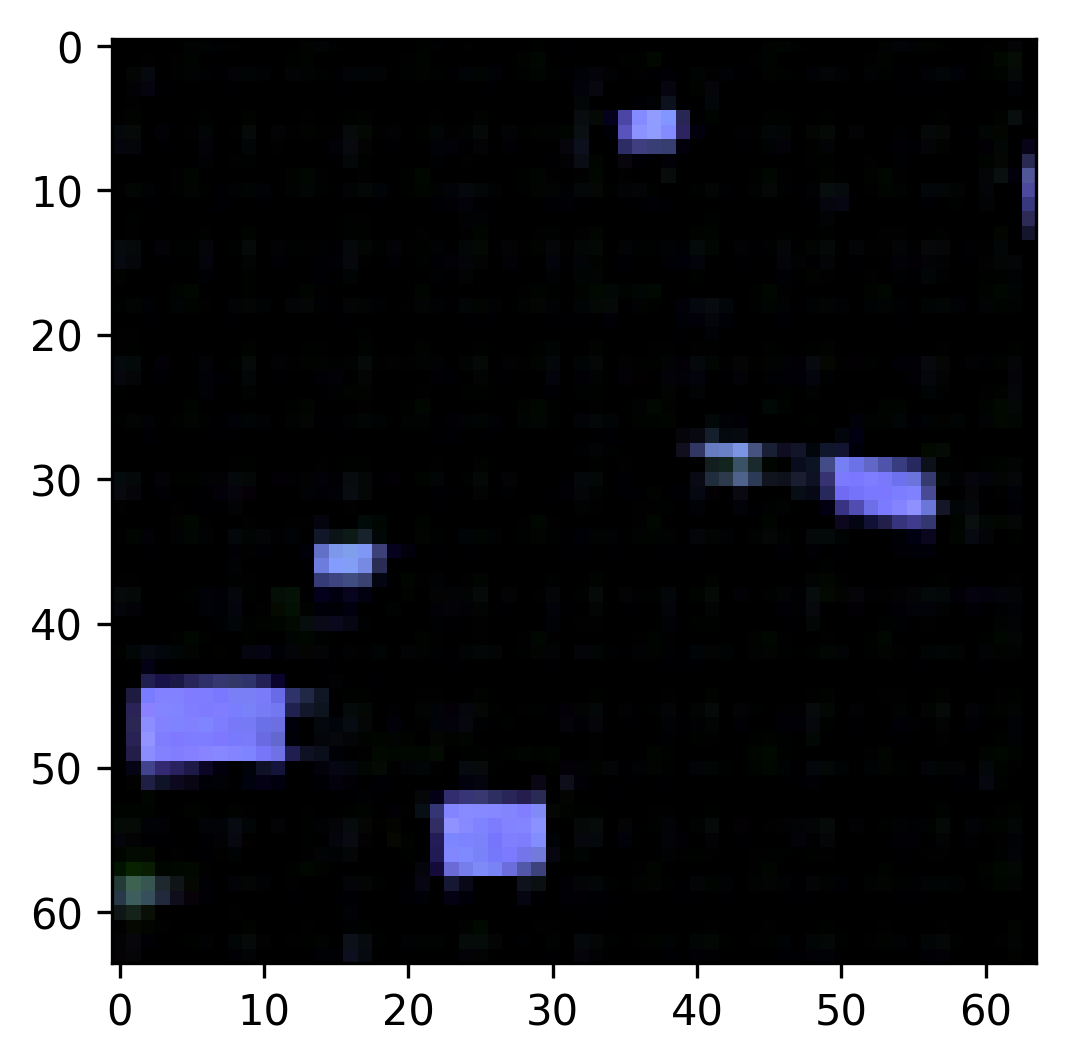

25
argm 1.4535887241363525 445.5150146484375
argm 1.439815878868103 446.69696044921875
argm 1.4340041875839233 445.7508239746094
argm 1.4417798519134521 446.8243408203125
argm 1.439316987991333 446.14813232421875
argm 1.4545567035675049 446.65484619140625
argm 1.47298002243042 447.19696044921875
argm 1.4747605323791504 446.88555908203125
argm 1.4835665225982666 445.6339416503906
argm 1.5008536577224731 447.55682373046875
argm 1.4954370260238647 446.10284423828125
argm 1.5033674240112305 445.86572265625
argm 1.4642854928970337 446.2657470703125
argm 1.4652247428894043 446.7378234863281
argm 1.4519461393356323 447.2471923828125
argm 1.4750654697418213 446.05462646484375
argm 1.4988683462142944 447.98236083984375
argm 1.5059921741485596 445.0806579589844
argm 1.5048940181732178 444.65093994140625
argm 1.472503423690796 442.6788635253906
argm 1.5048673152923584 440.89703369140625
argm 1.5232897996902466 441.8296813964844
argm 1.4926053285598755 441.48760986328125
argm 1.4814224243164062 44

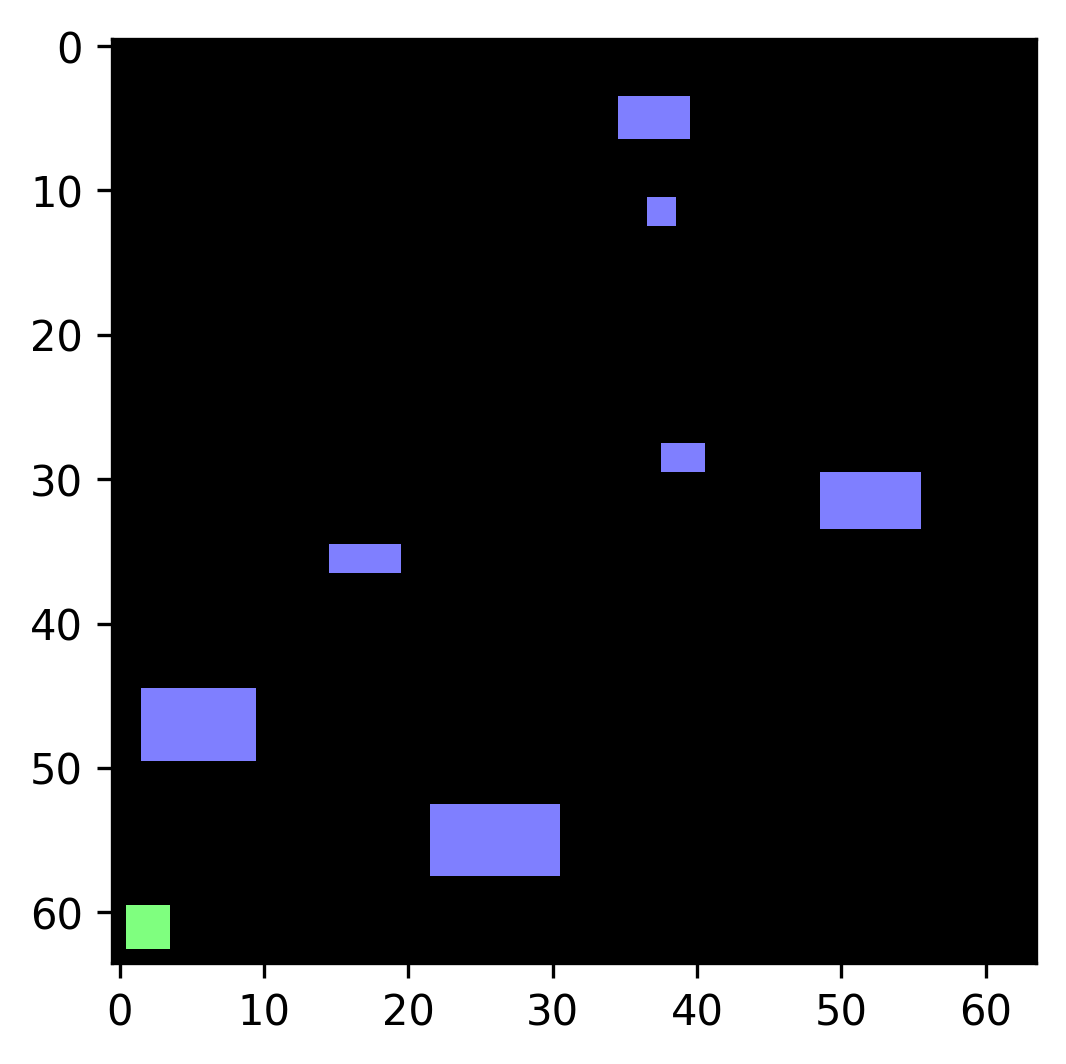

(3, 64, 64)


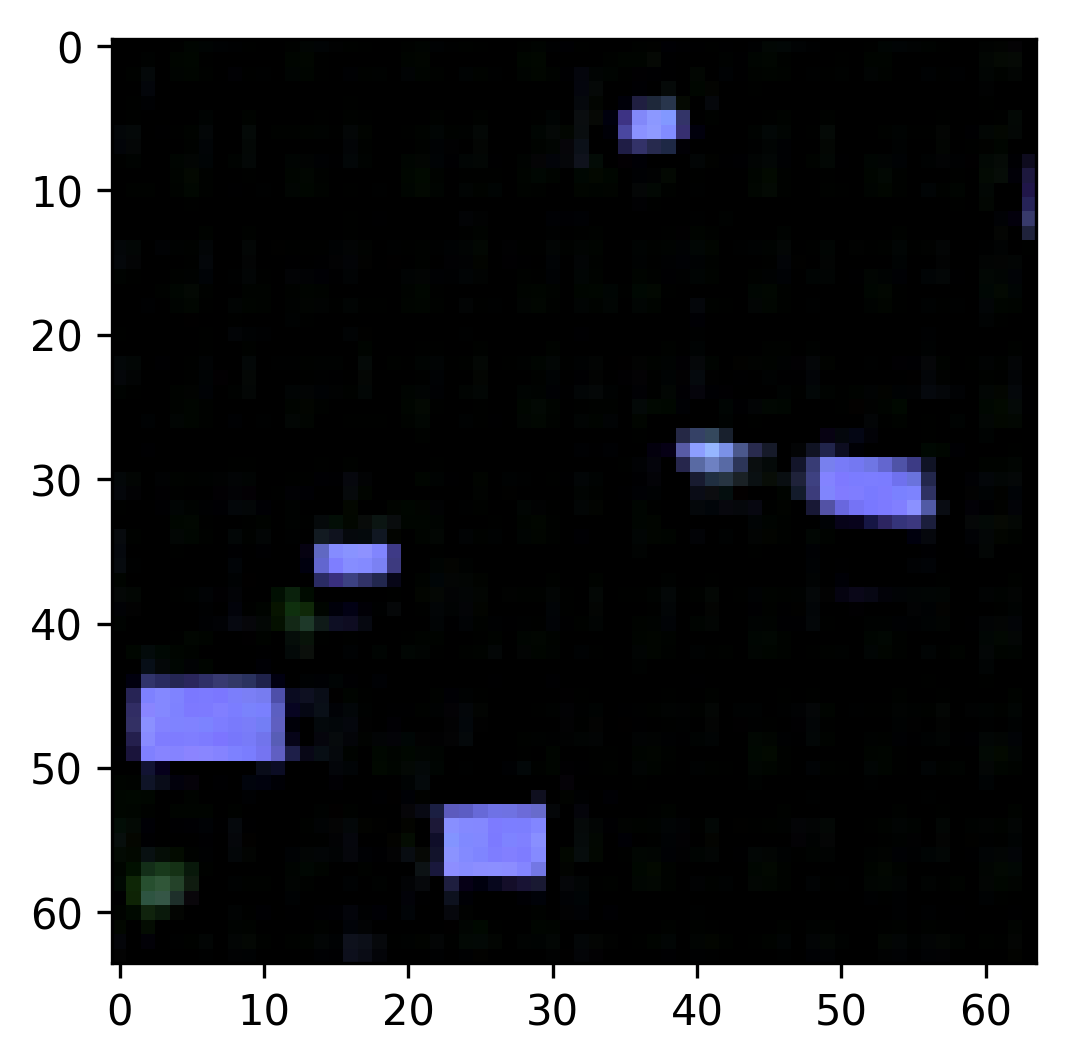

26
argm 1.270157814025879 110.79498291015625
argm 1.2704793214797974 110.89089965820312
argm 1.2669013738632202 110.36963653564453
argm 1.2699288129806519 110.59510803222656
argm 1.2646374702453613 111.25645446777344
argm 1.262458324432373 111.10352325439453
argm 1.2672412395477295 111.1856689453125
argm 1.272083044052124 111.48238372802734
argm 1.2717536687850952 111.6837387084961
argm 1.26556396484375 111.6190185546875
argm 1.274854063987732 111.36624145507812
argm 1.2786829471588135 111.11628723144531
argm 1.2809863090515137 110.99790954589844
argm 1.2835147380828857 111.06683349609375
argm 1.2827736139297485 110.93588256835938
argm 1.2817480564117432 110.59036254882812
argm 1.2785954475402832 110.62845611572266
argm 1.280714750289917 110.6890869140625
argm 1.2832832336425781 110.69290161132812
argm 1.2790794372558594 110.72344970703125
argm 1.2729779481887817 110.84349822998047
argm 1.2706775665283203 110.5535888671875
argm 1.2754762172698975 110.6831283569336
argm 1.27173185348510

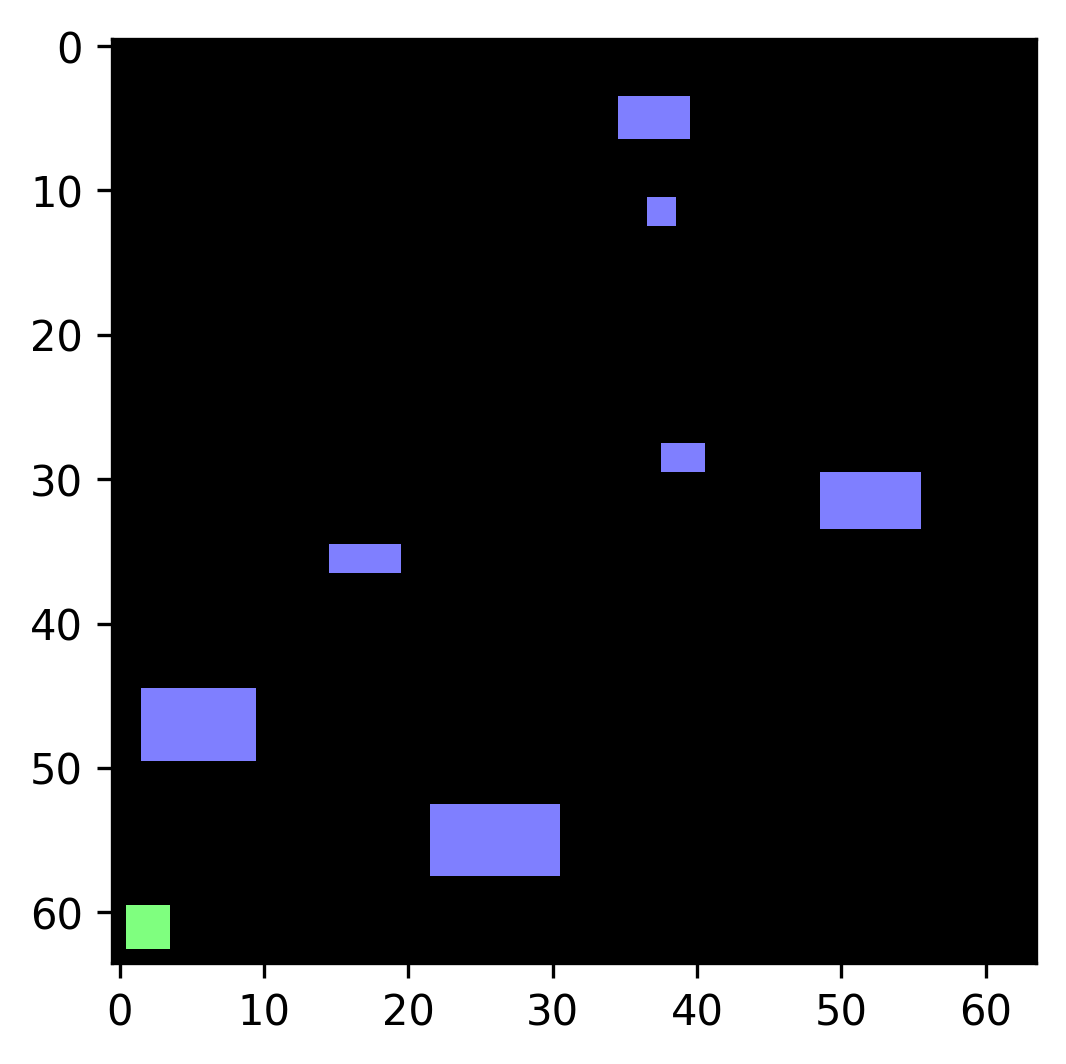

(3, 64, 64)


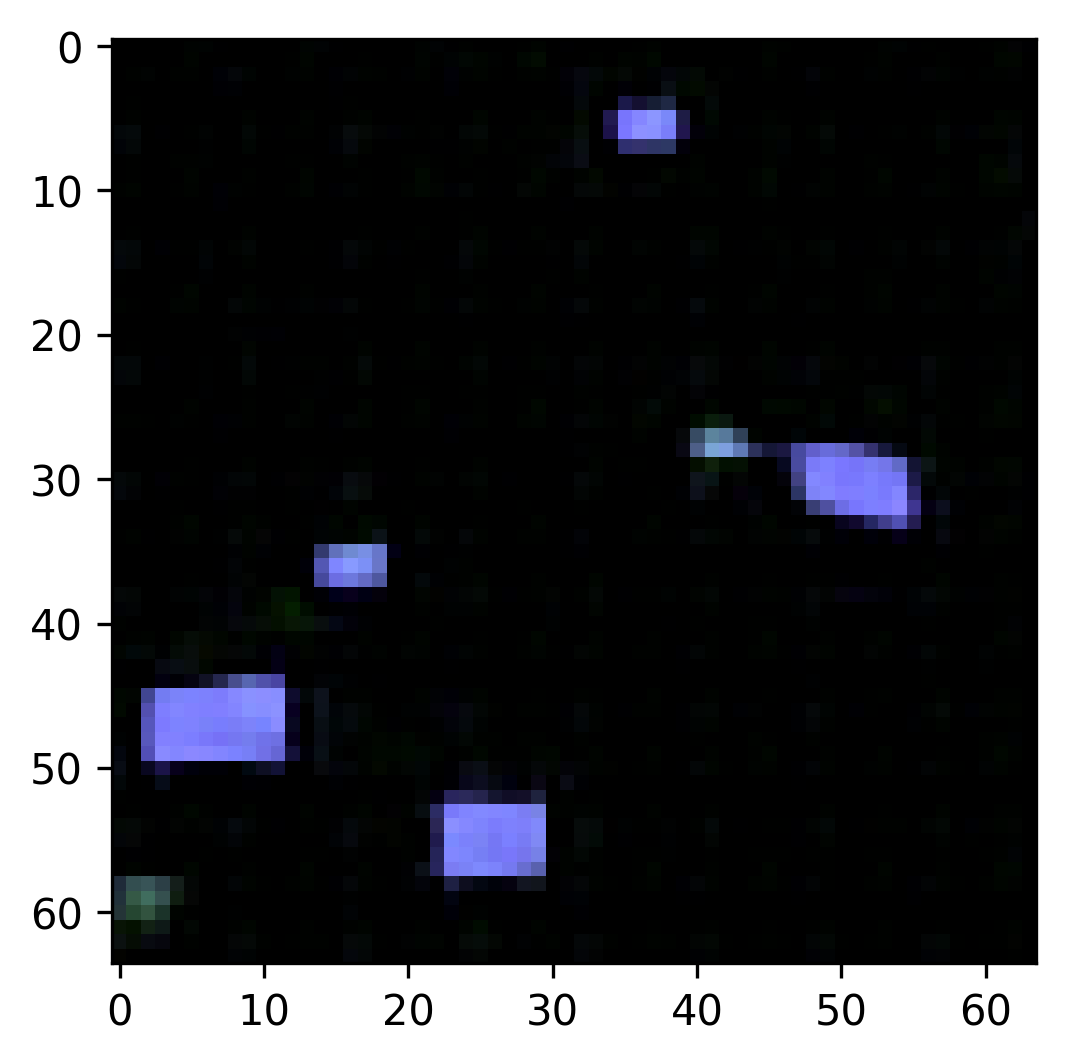

27
repr, std, cov, conv, closs 0.8795191049575806 0.476806640625 3.447616472840309e-05 0.005471884272992611 0.24804571270942688
24.745371102650147 0.007113524673027619 1.0
repr, std, cov, conv, closs 0.8683328628540039 0.476806640625 3.457698039710522e-05 0.004721641540527344 0.2490263432264328
24.844501158293582 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.8622735738754272 0.47607421875 3.9572594687342644e-05 0.005717703141272068 0.25816574692726135
24.62201456334452 0.007374144294084585 1.0
repr, std, cov, conv, closs 0.8703484535217285 0.476318359375 3.746571019291878e-05 0.005669638514518738 0.24808141589164734
24.548296005890542 0.007485534108970263 1.0
repr, std, cov, conv, closs 0.8763226866722107 0.475830078125 4.2537227272987366e-05 0.005359869450330734 0.25620219111442566
24.499272960696196 0.007523036709748977 1.0
repr, std, cov, conv, closs 0.8608033657073975 0.47509765625 4.6073924750089645e-05 0.005124969407916069 0.2514609098434448
24.062447639894256 0.00738889

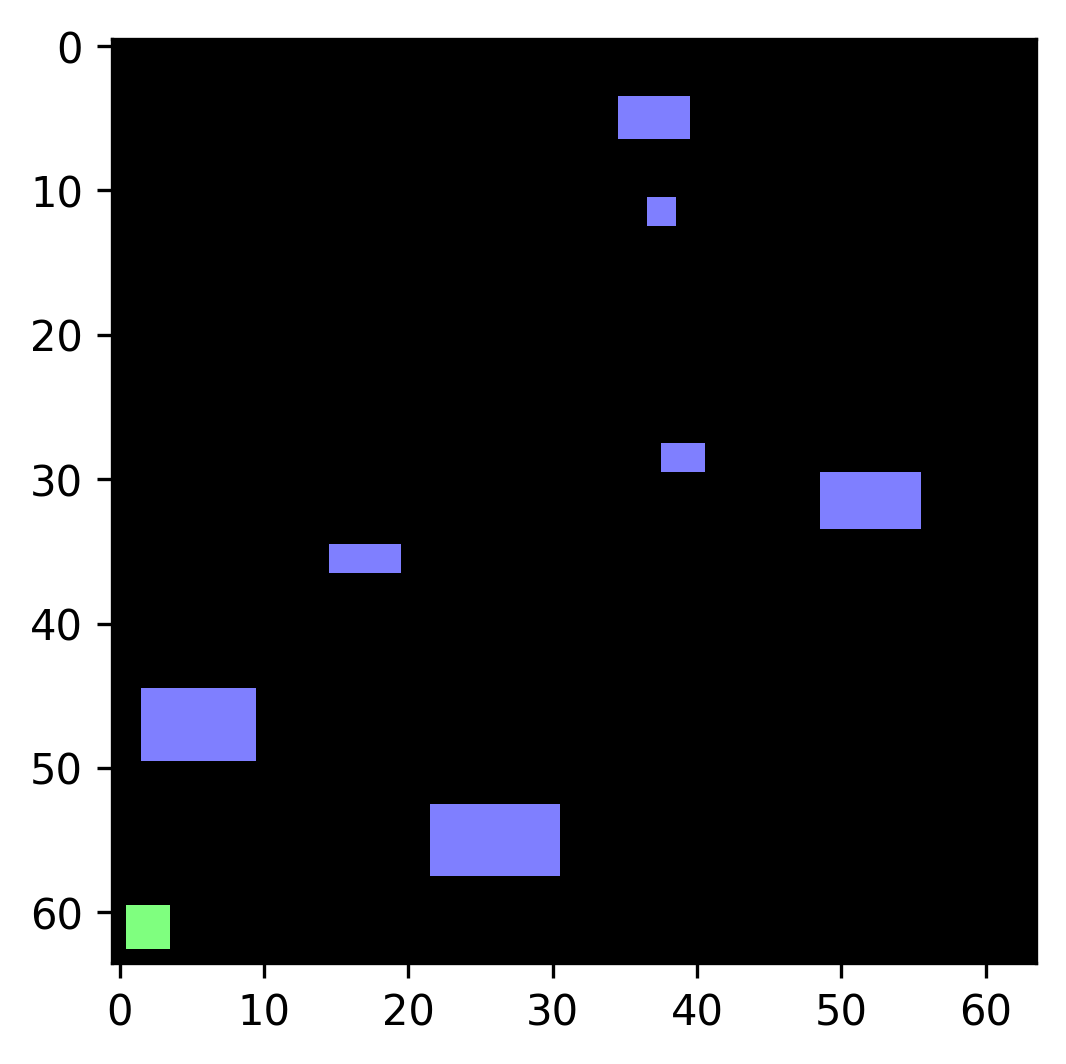

(3, 64, 64)


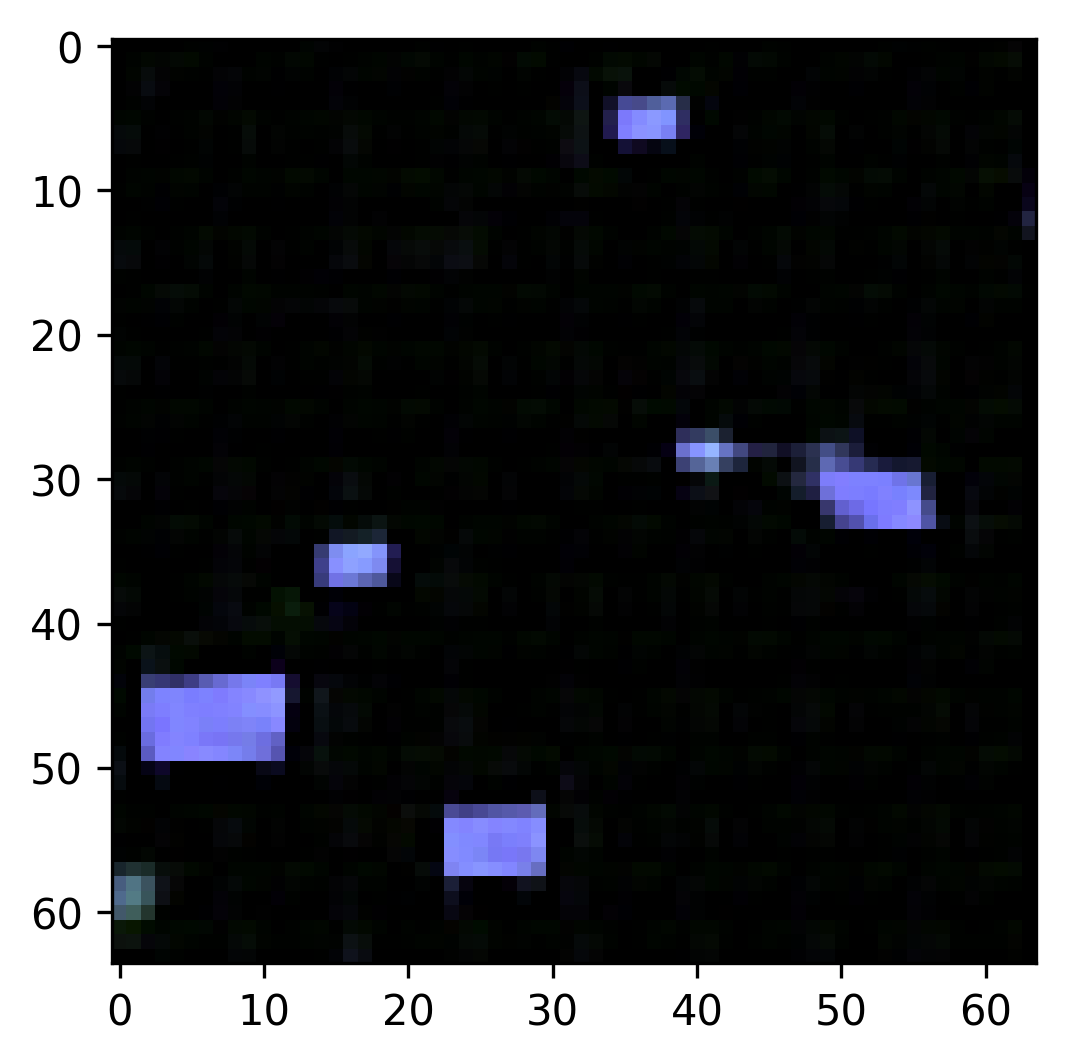

28
repr, std, cov, conv, closs 0.8377159833908081 0.475341796875 4.577450454235077e-05 0.004665805026888847 0.24956180155277252
22.32461566274827 0.006787083631326324 1.0
repr, std, cov, conv, closs 0.8438902497291565 0.4755859375 4.384852945804596e-05 0.003950544632971287 0.2516475319862366
22.168966571757768 0.006733030485070784 1.0
repr, std, cov, conv, closs 0.8501667976379395 0.4765625 3.7880148738622665e-05 0.00497030233964324 0.2503984272480011
22.88948006922822 0.006951860683026597 1.0
repr, std, cov, conv, closs 0.8477886915206909 0.47607421875 3.887573257088661e-05 0.004473135806620121 0.2511647343635559
23.235236111700296 0.0070639285829617645 1.0
repr, std, cov, conv, closs 0.8154616951942444 0.476806640625 3.499817103147507e-05 0.004471517167985439 0.2490125447511673
23.468636851555893 0.007293513298727238 1.0
repr, std, cov, conv, closs 0.8440872430801392 0.476806640625 3.507640212774277e-05 0.004679616075009108 0.2496502697467804
23.63341097311483 0.007418499919607042 1.

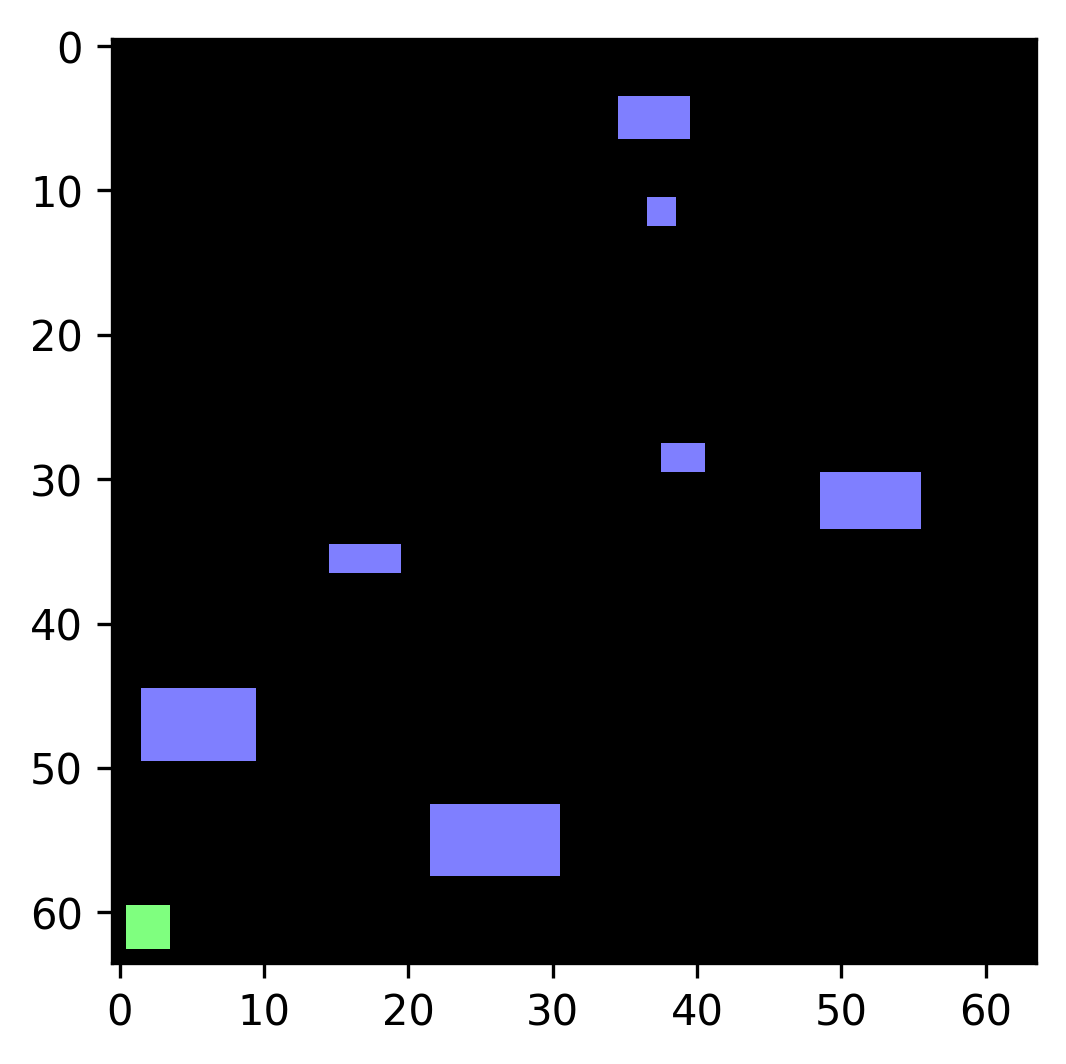

(3, 64, 64)


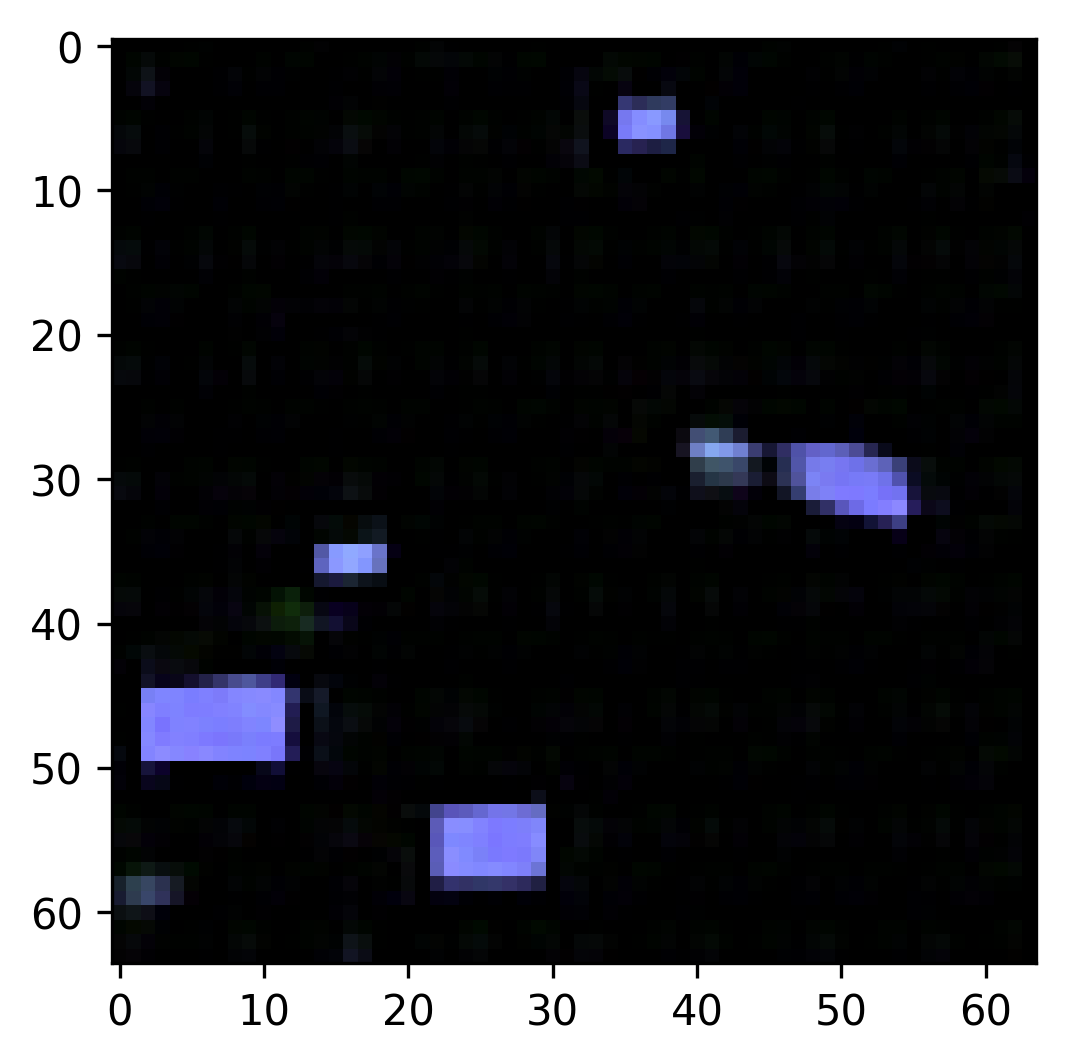

29
repr, std, cov, conv, closs 0.8264119029045105 0.47607421875 4.023616202175617e-05 0.0037608842831104994 0.25023701786994934
23.799341979554097 0.007560727198932804 1.0
repr, std, cov, conv, closs 0.8672804832458496 0.47607421875 3.910623490810394e-05 0.0045595732517540455 0.2498890459537506
23.704382129900495 0.007478056052917346 1.0
repr, std, cov, conv, closs 0.830361545085907 0.47607421875 4.1220104321837425e-05 0.004321591462939978 0.24963311851024628
23.05018791072767 0.007242662312881676 1.0
repr, std, cov, conv, closs 0.8285597562789917 0.475341796875 4.46452759206295e-05 0.004118240904062986 0.25205790996551514
22.639199970603823 0.007113524673027619 1.0
repr, std, cov, conv, closs 0.8093609809875488 0.475341796875 4.549603909254074e-05 0.004315330646932125 0.25062018632888794
22.280033316082793 0.006896495232612317 1.0
repr, std, cov, conv, closs 0.8065012097358704 0.47509765625 4.630954936146736e-05 0.0038120828103274107 0.24917542934417725
21.92656477306249 0.00678708363

In [ ]:
# @title wwwwwwwwwwww
from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

import torchvision.transforms.v2 as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


for i in range(30):
    print(i)
    # agent.train_ae(train_loader, optim)
    # agent.train_jepa(train_loader, optim)
    agent.train_jepa(train_loader, c_loader, optim)

    state = buffer[7][80][0]
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = agent.jepa.enc(state.unsqueeze(0))
    out= agent.deconv(sx_).squeeze(0)
    print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())

# 10 epochs 15m23s


In [10]:
# @title bin clss
# def train(model, train_loader, loss_function, optimizer):
#     model.train()
#     for image, _ in train_loader:
#         image = image.to(device)#.reshape(-1, 28*28)
#         reconstructed = model(image)
#         loss = loss_function(reconstructed, image)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


# class Agent(torch.nn.Module):
#     def __init__(self, d_model = 256):
#         super().__init__()
#         # d_list=[32, 64, 128, 256, 512, 1024] #
#         d_list=[32, 64, 128, 256, 256, 256] #
#         # d_list = [min(d, d_model) for d in d_list]
#         self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
#             nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
#             nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
#             nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
#             nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
#             nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
#             # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
#             nn.Flatten(start_dim=1),
#             # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
#             nn.Linear(4*d_list[4],d_model), nn.ReLU(),
#             nn.Linear(d_model,1),
#         )
#     def forward(self, x): return self.cnn(x)

d_model = 256
# tcost = nn.Sequential( # trained cost
#     # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, 1),
#     ).to(device)
mul=4
tcost = nn.Sequential( # trained cost
    # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
    nn.Dropout(), nn.Linear(d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, 2),
    ).to(device)


# agent = Agent(d_model=256).to(device)
# optim = torch.optim.AdamW(agent.parameters(), 1e-2, (0.9, 0.95))
optim = torch.optim.AdamW(tcost.parameters(), 1e-3, (0.9, 0.95))
# optim.param_groups[0]["lr"] = 1e-1

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

# loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.L1Loss()
loss_function = torch.nn.CrossEntropyLoss()
def train_cost(model, dataloader, optim, loss_function=loss_function):
    model.train()
    tcost.train()
    for batch, (st, r) in enumerate(dataloader):
        st, r = st.to(device), r.to(device)#.squeeze(-1)
        # st.requires_grad=True; r.requires_grad=True
        # print(st.requires_grad, r.requires_grad)
        # loss = F.mse_loss(model.tcost(model.jepa.enc(st)), r)
        # print(model.jepa.enc(st))
        # loss = loss_function(model.tcost(model.jepa.enc(st)), r)
        with torch.no_grad(): sx = model.jepa.enc(st)
        with torch.cuda.amp.autocast(): loss = loss_function(tcost(sx), r)
        # print(tcost(sx).squeeze(-1))
        # loss = loss_function(model(st), r)
        # print(next(model.tcost[0].parameters()).grad)
        # print(next(model.jepa.enc.parameters()).grad)
        # print(model.tcost.parameters()[0].grad)
        # print(loss)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        print(loss.item())
        try: wandb.log({"closs": loss.item()})
        except: pass


# for i in range(30):
#     train_cost(agent, c_loader, optim)


In [ ]:
# optim.param_groups[0]["lr"] = 1e-3

for i in range(30):
    train_cost(agent, c_loader, optim)


In [ ]:
for x in tcost.parameters():
    print(x)


Parameter containing:
tensor([[-0.0183, -0.0395, -0.0553,  ...,  0.0087,  0.0099,  0.0174],
        [-0.0558, -0.1075,  0.0386,  ..., -0.0029, -0.0503, -0.0063],
        [-0.0597, -0.0010, -0.0524,  ..., -0.0364, -0.0480, -0.0350],
        ...,
        [ 0.0060,  0.0112, -0.0471,  ...,  0.0037,  0.0260, -0.0601],
        [-0.0240, -0.0577, -0.0306,  ...,  0.0106, -0.0476,  0.0562],
        [ 0.0603, -0.0373,  0.0238,  ..., -0.0374, -0.0064, -0.0324]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0801, -0.1786, -0.2479,  ...,  0.1087, -0.1703, -0.0853],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0064,  0.1527,  0.0623,  ..., -0.0062,  0.0952, -0.0507],
        [ 0.0143, -0.0180,  0.0538,  ..., -0.0237,  0.0689, -0.0043],
        [-0.0677, -0.0027,  0.0921,  ..., -0.0120,  0.0166,  0.0875],
        ...,
        [ 0.0049,  0.0279,  0.1115,  ..., -0.0987,  0.0691, -0.0048],
        [ 0.1010,  0.0416,  0.0320,  ..., -0.0633,

In [18]:
# @title data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 64 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [14]:
# @title train


class Agent(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(1, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            # nn.Linear(4*d_list[4],d_model), nn.ReLU(),
            nn.Linear(4*d_list[3],d_model), nn.ReLU(),
            # nn.Linear(d_model,10),
        )

        mul=4
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Dropout(), nn.Linear(d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
            nn.Dropout(), nn.Linear(mul*d_model, 10),
            )
    # def forward(self, x): return self.cnn(x)

model = Agent(d_model=256).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    model.train()
    for image, r in train_loader:
        image, r = image.to(device), r.to(device)
        with torch.no_grad(): sx = model.cnn(image)
        # print(sx.shape, r.shape)
        with torch.cuda.amp.autocast(): loss = loss_function(model.tcost(sx), r)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(loss.item())
        # try: wandb.log({"loss": loss.item()})
        # except: pass

for epoch in range(10):
    train(model, train_loader, loss_function, optimizer)


Streaming output truncated to the last 5000 lines.
torch.Size([64, 256]) torch.Size([64])
1.1068038940429688
torch.Size([64, 256]) torch.Size([64])
0.8690791130065918
torch.Size([64, 256]) torch.Size([64])
0.9694504737854004
torch.Size([64, 256]) torch.Size([64])
1.051568865776062
torch.Size([64, 256]) torch.Size([64])
0.9903064966201782
torch.Size([64, 256]) torch.Size([64])
1.149724006652832
torch.Size([64, 256]) torch.Size([64])
1.536338448524475
torch.Size([64, 256]) torch.Size([64])
0.6801809072494507
torch.Size([64, 256]) torch.Size([64])
1.5099425315856934
torch.Size([64, 256]) torch.Size([64])
1.2786122560501099
torch.Size([64, 256]) torch.Size([64])
1.4165526628494263
torch.Size([64, 256]) torch.Size([64])
1.0018868446350098
torch.Size([64, 256]) torch.Size([64])
1.2992794513702393
torch.Size([64, 256]) torch.Size([64])
1.4725615978240967
torch.Size([64, 256]) torch.Size([64])
1.530504584312439
torch.Size([64, 256]) torch.Size([64])
1.4444475173950195
torch.Size([64, 256]) tor

In [21]:
images,r = next(iter(train_loader))

with torch.no_grad():
    pred = model.tcost(model.cnn(images.to(device))).argmax(-1).cpu()
    print(r)
    print(pred)
    print((r==pred).sum())


tensor([6, 3, 1, 3, 1, 0, 8, 2, 4, 2, 6, 7, 3, 2, 2, 4, 0, 5, 0, 5, 6, 3, 8, 9,
        2, 9, 0, 2, 6, 1, 4, 1, 7, 7, 2, 2, 8, 7, 0, 1, 6, 7, 0, 9, 3, 5, 4, 8,
        8, 3, 5, 1, 0, 3, 3, 5, 4, 8, 6, 1, 3, 7, 2, 6])
tensor([4, 3, 1, 3, 1, 0, 8, 2, 4, 2, 6, 7, 5, 4, 2, 7, 0, 5, 0, 4, 6, 3, 5, 7,
        8, 2, 0, 2, 6, 2, 4, 1, 5, 7, 2, 2, 2, 7, 2, 1, 6, 7, 5, 9, 3, 5, 4, 8,
        6, 3, 5, 1, 0, 3, 3, 8, 4, 9, 4, 1, 5, 7, 6, 6])
tensor(44)


In [ ]:
state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
sx_ = agent.jepa.enc(state.unsqueeze(0))
out= agent.deconv(sx_).squeeze(0)
print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())

In [ ]:
# @title simulate 4
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# buffer=[]

def simulate(agent, buffer=[]):
    # out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    out = cv2.VideoWriter('video{}.avi'.format(time.time()), cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    act=[]
    while True:
    # while not done:
        state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        if len(act)<=0: act = agent(state).cpu()[:1].tolist()
        action = act.pop(0)
        state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            print("ded")
            break
        episode.append((state, action, 0))
    print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

buffer = simulate(agent, buffer)
# _=simulate(agent)



In [ ]:
# @title wwwwwwwwwwww
for i in range(10):
    # # buffer=[]
    # print("#### simulate ####")
    # buffer = simulate(agent, buffer)

    print(i,"#### train ####")
    # train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
    # train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    agent.train_jepa(train_loader, optim)

# repr, std, cov 0.009419754147529602 0.478271484375 0.005037273280322552


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video.avi video.mp4 -y
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4', "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls autoplay><source src="{data_url}" type="video/mp4"></video>""")

###save

In [ ]:
# @title test search, argm
# # def search(self, sx, T=None, bptt=None):
T=20
bptt=None
if T==None: T = 256
if bptt==None: bptt = min(T,32)
d_model=agent.d_model
# sx=torch.randn((1, d_model), device=device)
# batch=sx.size(dim=0)
batch=32
# scale = torch.sqrt(torch.tensor((d_model,), device=device))

# x_ = torch.rand((batch, T, 3),device=device)
# x_ = torch.rand((batch, T, 3),device=device)*4 -2
# x_ = torch.rand((batch, T, 3),device=device)*3 -1.5
# x_ = torch.rand((batch, T, 3),device=device)*2 -1
# *self.dim_z**(-0.5) # 1/d^(1/2)
# x_ = torch.zeros((batch, T, 3),device=device) # dont, deterministic, stuck
x=nn.Parameter(x_.clone())
# optim = torch.optim.SGD([x], lr=1e3, momentum=0.9)
optim = torch.optim.SGD([x], lr=1e2)
optim = torch.optim.SGD([x], lr=1e5)
# optim = torch.optim.SGD([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=1e5)

# xx = torch.split(x, bptt, dim=1)
# for _ in range(10): # num epochs
#     sx_ = sx.detach()
#     # print(sx_[0][:10])
#     for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
#         la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
#         print(lact)
#         loss, sx_ = agent.rnn_pred(sx_, la)
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
#         sx_ = sx_.detach()
#         print("search",loss.item())


# argm
# sx = torch.rand((batch, d_model),device=device)*2 -1
# sy = torch.rand((batch, d_model),device=device)*2 -1
# a = torch.rand((batch, agent.dim_a),device=device)*2 -1
# z_ = torch.rand((batch, agent.dim_z),device=device)*2 -1
# # z_ = torch.rand((batch, agent.dim_z),device=device)
# # z_ = z_/scale

z=nn.Parameter(z_.clone()) # argm 0.38188403844833374 3.86767578125
# torch.nn.init.zeros_(z)
torch.nn.init.xavier_uniform_(z)
# print(z)
# optim = torch.optim.SGD([z], lr=1e2, momentum=0.9)
# optim = torch.optim.SGD([z], lr=1e4)
optim = torch.optim.SGD([z], lr=3e3)
# optim = torch.optim.SGD([z], lr=3e1)
# optim = torch.optim.AdamW([z], lr=3e-1)
lossfn = torch.nn.MSELoss()
num_steps = 100
agent.jepa.eval()
import time
start=time.time()
for i in range(num_steps):
    sxaz = torch.cat([sx, a, z], dim=-1)
    # loss, sx = agent.rnn_pred(sx, la)s
    sy_ = agent.jepa.pred(sxaz)
    # print("y_, y",y_.shape, y.shape)
    loss = lossfn(sy_, sy)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print("argm",loss.item(), z[0].item())
# print(time.time()-start)
print(z.squeeze())

want z around [-1,1], large lr, few steps, punish large z


In [34]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(
    project="procgen",
    config={
        "model": "res18",
    })


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin


In [ ]:
print(sum(p.numel() for p in agent.parameters() if p.requires_grad))
# 23921665 # agent # 6872065
# 12219840 # jepa # 3695040
# 24M params
# 24M * 3 * 4bytes
# 288MB

# 4 byte *3*64*64
# 4 *3*64*64 = 49152 # 1 img 50kb
# 64 img -> 3.2mb
# seq len 50 -> 160mb

# 64*64*3=12288
# 256*256=65536


6872065


In [ ]:
# @title gym
# https://gymnasium.farama.org/
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("Pendulum-v1") # https://gymnasium.farama.org/environments/classic_control/pendulum/
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

import torch
from vector_quantize_pytorch import FSQ

quantizer = FSQ(levels = [2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py



In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def strain(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast():
            x1, x2 = trs(x)
            loss = model.loss(x1,x2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        optimizer.zero_grad()
        # model.conv_ema.update_parameters(model.conv)
        # model.exp_ema.update_parameters(model.exp)

        scaler.update()
        if scheduler is not None: scheduler.step()
        train_loss = loss.item()/len(y)
        loss_list.append(loss.item())
        try: wandb.log({"train loss": train_loss})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x1, x2 = trs(x)
        loss = model.loss(x1,x2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        loss_list.append(loss.item())
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list


# def ctrain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
def ctrain(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            x = model(x)
        pred = model.classify(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % (size//10) == 0:
        # if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = model(x)
            pred = model.classify(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# @title rnn train, gen

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred,_ = model(X)
        loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()/ len(X)

        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train(dataloader, model, loss_fn, optimizer, bptt=32):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # hid = model.init_hidden(bptt)
        hid = model.init_hidden(X.shape[0])
        X, y = X.to(device), y.to(device)
        # print("X.shape:",X.shape) # [batch_size, seq_len]
        Xs, ys = torch.split(X, bptt, dim=1), torch.split(y, bptt, dim=1)
        for (X, y) in zip(Xs, ys): # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            optimizer.zero_grad()
            # print("X.shape:",X.shape) # [batch_size, bptt]
            pred, hid = model(X, hid)
            loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.flatten())
            # loss = loss_fn(pred.flatten(0,1), y.flatten())
            # loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            hid = hid.detach()

        train_loss = loss.item()/ len(X)
        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


import torch
from torch.nn import functional as F
def generate(model, context, max_steps = 64, temperature=1):
    # x = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    x=ix = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    model.eval()
    hidden=None
    with torch.no_grad():
        for n in range(max_steps):
            # output, hidden = model(x, hidden)
            output, hidden = model(ix, hidden)
            hidden=hidden[:, -1, :].unsqueeze(1)
            output = output[:, -1, :] # get logit for last character
            output = output/temperature
            output = F.softmax(output, dim = -1) # vocab_size to char
            ix = torch.multinomial(output, num_samples = 1) # rand sample by output distribution
            x = torch.cat((x, ix),1)
        completion = ''.join([train_dataset.itos[int(i)] for i in x.flatten()])
        return completion

# out=generate(model, "A wi")
# print(out)


In [ ]:
# @title simulate
from google.colab.patches import cv2_imshow
import cv2
# history = []
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
buffer = []
state = env.reset()
done = False
while not done:
    state = transform(state).unsqueeze(0)
    action = agent(state) # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
    # print(action.item(), reward)
    out.write(state)
    if done:
        buffer.append((state, action, reward-100))
        break
    buffer.append((state, action, reward))
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title mha
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention


class MHAme(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention

# @title test mha
# import torch
# batch_size=3
# L=5
# d_model=8
# n_heads=2

# trg = torch.rand(batch_size,L, d_model)
# src = torch.rand(batch_size,L, d_model)

# mha = MultiHeadAttention(d_model, n_heads)
# x, attn = mha(trg,src,src)

# head_dim = d_model // n_heads

# # trg1=trg.view(batch_size, -1, n_heads, head_dim).transpose(1, 2)
# trg=trg.view(batch_size, n_heads, -1, head_dim)
# src=src.view(batch_size, n_heads, -1, head_dim)
# # print(trg1)
# # print("##########")
# # print(trg2)
# attn = trg @ src.transpose(2, 3)
# x=attn@trg
# print(x.shape)
# print(attn.shape)

# # trg1=trg1.view(batch_size,L, d_model)
# trg1=trg1.reshape(batch_size,L, d_model)
# trg2=trg2.view(batch_size,L, d_model)
# print(trg1)
# print("##########")
# print(trg2)



In [ ]:
# @title simulate save
from google.colab.patches import cv2_imshow
import cv2

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))

# print(env.action_space)

state = env.reset()
done = False
while not done:
    # action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    action = agent(state)
    state, reward, done, info = env.step(action)
    # print(state.shape) # 0-255 (64, 64, 3)
    print(action, reward, done)
    out.write(state)

    # break
    if done:
        break
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder(256).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



2775104
2362625
torch.Size([4, 256])
torch.Size([4, 1, 32, 32])


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(model.parameters(), 3e-3, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(8):
    print(i)
    train(train_loader,model,optim)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = model.encode(state.unsqueeze(0))
    out= model.decode(sx_)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [ ]:
# @title text E norm (d/3)^(1/2)
# a=torch.rand(16, 1, 256)
# b=torch.tensor([])
# c=torch.cat((a,b),dim=1)

# a=torch.rand(16, 1, 1)
# b=torch.rand(16, 1, 256)
# # c=torch.bmm(a,b)
# c=a@b
# print(c.shape)

d=16
# a=torch.rand(d)/(d/3)**(1/2)
# a=torch.rand(d)*2-1
# # a=torch.rand(d,d)
# print(a)
# print(a.norm().item())

# w=torch.rand(d,d)*2-1
# w=(torch.rand(d,d)*2-1)*(3**0.5)/d
# print(w)
w = F.normalize(w)
k,v = torch.rand(1,d), torch.rand(1,d)
k,v = k*2-1, v*2-1
# k,v = F.normalize(k), F.normalize(v)
# print(k)
# print(k.T@v)
# print(k@v.T)
print((k.T@v).norm().item())
# print(w.norm().item())
# print(w[0].norm().item())
# print(w[:,0].norm().item())
# print((w@k.T).norm().item())

# (d/3)^(1/2) # E norm of dim d vec [0-1] or [-1-1]
# print(4/(3**0.5))
# k@v.T d/4 [0-1], 0 [-1-1],
# w norm: d^2 a^2 = print(16/(3**0.5))

# int int ab db da = int [1/2 a b^2] da = int 1/2 a da =
# 1/4



5.039520263671875


In [ ]:
# @title 514
n=100
a=torch.linspace(n,0,n)
i=0
o=0
# oo=[]
while True:
    m = torch.randint(0, n, (1,))
    a[m] = i
    o_=i-a.min()
    oo.append(o_.item())
    print(sum(oo)/len(oo))
    i+=1
# 514?
# p=1.064422028?


In [ ]:
n=100
tt=0
a=1+1/(n*(n-1))
print(a)
for i in range(n-1):
    a=(1+ 1/(n-i))*a
    print(a)
    tt+=a


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.0)
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=0.1),
                # transforms.RandomSolarize(threshold=130/255, p=0.2) # og threshold=130, /255 bec after normalising
                transforms.RandomSolarize(threshold=.9, p=0.2),
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

trs=TrainTransform()


In [ ]:
# @title vicreg next
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class VICReg(nn.Module):
    def __init__(self, dim_embd=256, ema=False):
        super().__init__()
        self.conv = get_res(dim_embd=dim_embd)

        # f=[dim_embd,1024,1024,1024]
        # f=[dim_embd,512,512,512]
        f=[dim_embd,256,256,256]
        self.exp = nn.Sequential(
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[2]), nn.BatchNorm1d(f[2]), nn.ReLU(),
            nn.Linear(f[-2], f[-1], bias=False)
            )
        self.ema = ema
        if ema:
            self.conv_ema = AveragedModel(self.conv, multi_avg_fn=get_ema_multi_avg_fn(0.999))
            self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=10.0 # 25.0 # λ
        std_coeff=10.0 # 25.0 # µ
        cov_coeff=1.0 # 1.0 # ν

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        print("in vicreg ",(sim_coeff * repr_loss).item() , (std_coeff * std_loss).item() , (cov_coeff * cov_loss).item())
        return loss

    def loss(self, sx, sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        with torch.no_grad(): # target encoder is ema
            sy = self.conv_ema(sy)
            vy = self.exp_ema(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss

    def forward(self, x):
        return self.conv(x)


model = VICReg().to(device) # create an instance and move it to device (cache?)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# @title simulate 512
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def simulate(agent, buffer=[]):
    out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    while True:
    # while not done:
        # state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # state, reward, done, info = env.step(action[0]) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        state, reward, done, info = env.step(action)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            # print("ded")
            break
        episode.append((state, action, 0))
    # print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
# _=simulate(agent)

buffer=[]
for i in range(512):
    buffer = simulate(agent, buffer)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

### trash

In [ ]:
# @title torch gru
# text_generation.ipynb https://colab.research.google.com/drive/1SguQZQYZBaalRuElJcxGdgF3YxhiwkAM
# RNNs.ipynb https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR

import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class gru(nn.Module):
    def __init__(self, emb_dim, rnn_units, num_layers):
        super().__init__()
        self.gru = nn.GRU(emb_dim, rnn_units, num_layers=num_layers, dropout=0.0, batch_first=True)
        self.dense = nn.Linear(rnn_units, vocab_size)
        self.rnn_units = rnn_units
        self.num_layers = num_layers

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.rnn_units, device=device) # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None: hidden = self.init_hidden(x.shape[0])
        # print('fwd',x.shape, hidden.shape) # fwd [batch_size, bptt, emb_dim], [num_layers, batch_size, rnn_units]
        output, hidden = self.gru(x, hidden)
        output = self.dense(output)
        return output, hidden


emb_dim = 256#256
rnn_units = 1024#1024
num_layers = 1
# model = gru(emb_dim, rnn_units, num_layers).to(device)
# model.summary()



In [ ]:
# @title ltm
import faiss
import numpy as np
import pickle
import torch

class Ltm():
    def __init__(self, ltmk=None, ltmv=None):
        self.index = None
        if ltmk is None:
            self.ltmk = torch.tensor([])
            self.ltmv = torch.tensor([])
        else:
            self.ltmk = ltmk # [len_ltm, d_model]
            self.ltmv = ltmv
        if len(self.ltmk)>=100:
            self.index = makefaissindex(ltmk)

    # def add(self, k, v):
    def add(self, k, v, mask=None):
        # self.ltmk.append(k)
        # self.ltmv.append(v)
        if k==None: return
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        if mask==None:
            self.ltmk = torch.cat([self.ltmk, k], dim=1)
            self.ltmv = torch.cat([self.ltmv, v], dim=1)
        else:
            self.ltmk[mask] = torch.cat([self.ltmk[mask], k], dim=1)
            self.ltmv[mask] = torch.cat([self.ltmv[mask], v], dim=1)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.1:
                self.index.train(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        return mask

    def __call__(self, query, k=5, treshold=36): # [batch_size, d_model]
        if self.index!=None and len(self.ltmk)>=100:
            mask = self.vecsearch(query, k, treshold)
            rag = self.ltmk[mask] # [len_rag, d_model]
        else:
            rag = self.ltmk
        if len(rag)==0: return 0
        # print("ltm call", query.shape, rag.shape)
        # attn = query @ rag.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ rag.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.ltmv
        return x # [batch_size, d_model]

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(file='ltm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv), f)

    def load(file='ltm.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv = pickle.load(f)

ltm = Ltm()


In [ ]:
# @title stm
import torch
import pickle

class Stm():
    def __init__(self, stmk=None, stmv=None, meta=None):
        self.stmk = stmk # [len_ltm, d_model]
        self.stmv = stmv
        self.meta = meta

    def __call__(self, query):
        # if len(rag)==0: return 0
        # print("stm call", query.shape, self.stmk.shape)
        # attn = query @ self.stmk.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.stmv
        self.meta = self.meta + attn.squeeze() # attention
        return x # [batch_size, d_model]

    def add(self, k, v):
        if k.ndim==1:
            k=k.unsqueeze(0)
            v=v.unsqueeze(0)
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)
        # self.meta = torch.cat([self.meta, torch.ones(1,1)], dim=-1)
        self.meta = torch.cat([self.meta, torch.ones(self.meta.shape[0],1)], dim=-1)
        # self.meta = torch.cat([self.meta, torch.ones(1)])

    def decay(self, g=0.9, k=256):
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
        self.meta = topk.values # cap stm size
        self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5):
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        popk, popv = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask]
        self.meta = self.meta[~mask]
        return popk, popv, mask.any(dim=-1)

    def save(file='stm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.stmk, self.stmv, self.meta), f)

    def load(file='stm.pkl'):
        with open(file, 'rb') as f: self.stmk, self.stmv, self.meta = pickle.load(f)



In [ ]:
# @title split params to train
# qkv for useful for critic predicting cost?

# train after each step: jepa(pred)(using SL)?

# train after each episode: critic, jepa()


# jepa is batch of same length episodes, take from history
# cost is single full episode buffer

# or combine string of episode buffers, batchify like rnn training


# batch_size = 64
# weights = torch.ones(len(buffer))#.expand(batch_size, -1)
# index = torch.multinomial(weights, num_samples=batch_size, replacement=False)
# buffer[index]


for name, p in agent.named_parameters():
    print(name, 'tcost' in name)
# https://pytorch.org/docs/stable/optim.html#per-parameter-options4
# optim.SGD([
#                 {'params': others},
#                 {'params': bias_params, 'weight_decay': 0}
#             ], weight_decay=1e-2, lr=1e-2)

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]

# # joptim = torch.optim.AdamW(agent.jepa.parameters(), lr=1e-3)
# joptim = torch.optim.AdamW([agent.jepa.parameters(),agent.q.parameters(), agent.k.parameters(), agent.v.parameters()], lr=1e-3)
# coptim = torch.optim.AdamW(agent.tcost.parameters(), lr=1e-3)
joptim = torch.optim.AdamW(tcost_params, lr=1e-3)
coptim = torch.optim.AdamW(others, lr=1e-3)
agent.train(buffer, joptim, coptim)


In [ ]:
# @title assorted
# print(type(buffer[0][0]))
# print(buffer[0][0])
# print(buffer[0][0].dtype)
import numpy as np

# b=np.random.randint(low=0, high=256, size=(1000, 64, 64, 3), dtype='uint8')
b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(1000)]
# print(b.shape)
# print(b[0])
def custom_collate(original_batch):
    return original_batch

train_data = BufferDataset(b, seq_len) # one line of poem is roughly 50 characters
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2) # num_workers = 4
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = False, batch_size = batch_size, collate_fn=custom_collate) # num_workers = 4
# train_loader = DataLoader(test_dataset, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 0)

    # def plan(self, ): # mpc
    #     # xs, us = locuslab_mpc(x_init, goal_state, self.jepa)
    #     xs, us = locuslab_mpc(x_init, goal_state, self.jepa)

# def train_cost(self, dataloader, buffer, optim):

#         c = c + self.icost(world_state_) + reward
#         c_ = c_ + cost
#     closs = nn.MSELoss()(c,c_) # L1Loss MSELoss ; Sum reward
#     closs.backward()
#     optim.step()



In [ ]:
# @title custom transforms ToTensorme
import torchvision.transforms as transforms
# 100,3
# seq_len,
# for batch, Sar in enumerate(train_data):
for batch, Sar in enumerate(train_loader):
# for batch, (State, Action, Reward) in enumerate(train_loader):
# for batch, (Sar,_) in enumerate(train_loader):
    # print(len(Sar[0]))
    # print(Sar[0][0].shape)
    # State, Action, Reward = zip(*Sar)
    # State=Sar
    break
for s,a,r in zip(*Sar):
    state=s
    break
print(len(State))
print(len(State[0]))
print(type(State[0]))


# transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)),

# def ToTensorme(x):
#     print("ToTensorme",type(x))
#     # if type(x) == np.ndarray: return x.astype(np.float32)
#     # if type(x) == np.ndarray: return torch.from_numpy(x).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.permute(2,0,1).to(torch.float32)
#     if type(x) == torch.Tensor: return x.permute(0,3,1,2).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.to(torch.float32)

# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.Lambda(ToTensorme), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(ToTensorme)])
# # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

print(State[0].shape)
# out=transform(State[0][0])
# out=transform(State[0])
# out=transform(list(State[0]))
# print(out)

# State = torch.tensor(State)
# print(State.shape)

# State[:,,]
# l=99
# lst=list(range(0,l,7))[1:]+[l]
# print(lst)


# b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(10)]
# for state in b:
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     transform(state)



50
16
<class 'torch.Tensor'>
torch.Size([16, 3, 64, 64])


In [ ]:
# @title batch pop to ltm
import torch
batch_size=8
d_model=4
# stmk=torch.rand(batch_size, 5, d_model)
# stmv=torch.rand(batch_size, 5, d_model)
# ltmk=torch.rand(batch_size, 5, d_model)
# ltmv=torch.rand(batch_size, 5, d_model)
# meta=torch.rand(batch_size, 5)*7
# mask = meta>5 # to pop to ltm
# popk, popv = stmk[mask], stmv[mask]
# print(popk.shape, popv.shape)
# stmk, stmv = stmk[~mask], stmv[~mask]
# meta = meta[~mask]
# # return popk, popv


# out=torch.rand(batch_size, 1, d_model)
out=[torch.rand(1, d_model) for _ in range(batch_size)]
lst=torch.rand(batch_size, 5, d_model)
mask=torch.rand(batch_size, 5) > 0.5
# out = torch.cat([out,lst[mask]], dim=1)
# batch, row = torch.where(mask)
# print(batch, row)
# out = torch.cat([out,lst[torch.where(mask)]], dim=1)
# print(out[batch].shape,lst[batch, row,:].shape)
# out[batch] = torch.cat([out[batch],lst[batch, row,:]], dim=1)
# out[batch] = torch.cat([out[batch],lst[batch, row,:].unsqueeze(1)], dim=1)

for b, m in enumerate(mask):
    # out[b] = torch.cat([out[b],lst[b][m]], dim=1)
    out[b] = torch.cat([out[b],lst[b][m]])



# num_masked = mask.sum(dim=1, keepdim=True)
# masked_elements = lst[torch.arange(lst.size(0))[:, None], mask]
# zeros = torch.zeros(batch_size, num_masked.max(), d_model)
# output = zeros.scatter(dim=1, index=masked_elements.nonzero(as_tuple=True)[1], src=masked_elements)
# torch.cat([out, output], dim=1)

# empty_mask = ~mask.any(dim=1)  # Find rows where all mask values are False
# padded_lst = torch.zeros(batch_size, 1, d_model)  # Create a zero tensor for padding
# padded_lst[~empty_mask] = lst[mask][~empty_mask]  # Fill non-empty masks with selected values
# out = torch.cat([out, padded_lst], dim=1)


# print(mask)
# print(mask[:, None])
# print(mask[:, None].expand(-1, lst.size(1), -1))

# out = torch.cat([out, lst[mask[:, None].expand(-1, lst.size(1), -1)]], dim=1)
# out = torch.cat([out, lst[mask[:, None]]], dim=1)

# print(out.shape)
print(out)


In [ ]:
# @title straight through estimator
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)
